# ИЗВЛЕЧЕНИЕ ПРИЗНАКОВ

## Методы для извлечения признаков из датасета с трёхфазным током

In [ ]:
# РЕАЛИЗАЦИЯ 2 (~120 признаков)

import numpy as np
import pandas as pd
from scipy import signal
from scipy.fft import fft, fftfreq
from scipy.signal import hilbert
import pywt
from pathlib import Path

class MotorDefectFeatures:
    def __init__(self, fs=25600, f_supply=50, n_nominal=1770, n_sync=1800, 
                 window_size=16384, window_step=4096, window_function='hann', n_poles=4):
        self.fs = fs
        self.f_supply = f_supply
        self.n_nominal = n_nominal
        self.n_sync = n_sync
        self.window_size = window_size
        self.window_step = window_step
        self.window_function = window_function
        self.n_poles = n_poles
        self.p = n_poles // 2
        
        self.slip = (n_sync - n_nominal) / n_sync
        self.f_rotor = n_nominal / 60
        
        # Роторные частоты
        self.f_sb1_lower = f_supply * (1 - 2 * self.slip)
        self.f_sb1_upper = f_supply * (1 + 2 * self.slip)
        self.f_sb2_lower = f_supply * (1 - 4 * self.slip)
        
        # Частоты подшипников NSK6205DDU
        self.f_bpfo = 105.4  
        self.f_bpfi = 160.1  
        self.f_bsf = 28.2   
        self.f_ftf = 11.7
        
        # Частоты эксцентриситета
        self.f_ecc_main_1_lower = f_supply - self.f_rotor
        self.f_ecc_main_1_upper = f_supply + self.f_rotor
        self.f_ecc_main_2_lower = f_supply - 2 * self.f_rotor

    def apply_window_function(self, data):
        if self.window_function == 'hann':
            window = np.hanning(len(data))
        elif self.window_function == 'hamming':
            window = np.hamming(len(data))
        else:
            window = np.ones(len(data))
        return data * window

    def get_fft_spectrum(self, current_a, current_b, current_c):
        windowed_a = self.apply_window_function(current_a)
        windowed_b = self.apply_window_function(current_b)
        windowed_c = self.apply_window_function(current_c)
        
        fft_a = fft(windowed_a)
        fft_b = fft(windowed_b)
        fft_c = fft(windowed_c)
        freqs = fftfreq(len(windowed_a), 1/self.fs)
        
        return fft_a, fft_b, fft_c, freqs

    def common_features(self, current_a, current_b, current_c):
        """18 основных признаков"""
        features = {}
        
        # Статистические признаки (9)
        for phase, current in [('A', current_a), ('B', current_b), ('C', current_c)]:
            features[f'rms_{phase}'] = np.sqrt(np.mean(current**2))
            features[f'mean_{phase}'] = np.mean(current)
            features[f'std_{phase}'] = np.std(current)
        
        # Несимметрия фаз (6)
        rms_a = features['rms_A']
        rms_b = features['rms_B'] 
        rms_c = features['rms_C']
        
        total_rms = rms_a + rms_b + rms_c
        if total_rms > 1e-10:
            features['total_imbalance'] = (abs(rms_a - rms_b) + abs(rms_b - rms_c) + abs(rms_c - rms_a)) / total_rms
            features['rms_imbalance'] = features['total_imbalance']
            features['imbalance_ab'] = abs(rms_a - rms_b) / (rms_a + rms_b)
            features['imbalance_bc'] = abs(rms_b - rms_c) / (rms_b + rms_c)
            features['imbalance_ca'] = abs(rms_c - rms_a) / (rms_c + rms_a)
        else:
            features['total_imbalance'] = 0
            features['rms_imbalance'] = 0
            features['imbalance_ab'] = 0
            features['imbalance_bc'] = 0
            features['imbalance_ca'] = 0
        
        # Park Vector (3)
        i_d = (2/3) * (current_a - 0.5*current_b - 0.5*current_c)
        i_q = (1/np.sqrt(3)) * (current_b - current_c)
        
        park_magnitude = np.sqrt(i_d**2 + i_q**2)
        park_mean = np.mean(park_magnitude)
        features['park_ellipticity'] = np.std(park_magnitude) / park_mean if park_mean > 1e-10 else 0
        features['park_mag_mean'] = park_mean
        features['park_mag_std'] = np.std(park_magnitude)
        
        return features

    def rotor_features(self, current_a, current_b, current_c):
        """15 роторных признаков"""
        features = {}
        
        fft_a, fft_b, fft_c, freqs = self.get_fft_spectrum(current_a, current_b, current_c)
        
        # Индексы частот
        idx_main = np.argmin(np.abs(freqs - self.f_supply))
        idx_sb1_l = np.argmin(np.abs(freqs - self.f_sb1_lower))
        idx_sb1_u = np.argmin(np.abs(freqs - self.f_sb1_upper))
        idx_sb2_l = np.argmin(np.abs(freqs - self.f_sb2_lower))
        
        combined_ratio = 0
        
        for phase, fft_phase in [('A', fft_a), ('B', fft_b), ('C', fft_c)]:
            amp_main = np.abs(fft_phase[idx_main])
            
            if amp_main > 1e-10:
                sb1_lower_ratio = np.abs(fft_phase[idx_sb1_l]) / amp_main
                combined_ratio += sb1_lower_ratio
                
                # Основные sideband признаки (4)
                if phase == 'A':
                    features['rotor_sb1_lower_ratio_A'] = sb1_lower_ratio
                    features['rotor_sb1_upper_ratio_A'] = np.abs(fft_phase[idx_sb1_u]) / amp_main
                    features['rotor_sb2_lower_ratio_A'] = np.abs(fft_phase[idx_sb2_l]) / amp_main
                    features['rotor_sb1_lower_amp_A'] = np.abs(fft_phase[idx_sb1_l])
                    features['rotor_sb1_upper_amp_A'] = np.abs(fft_phase[idx_sb1_u])
                elif phase == 'B':
                    features['rotor_sb1_lower_ratio_B'] = sb1_lower_ratio
                    features['rotor_sb1_upper_ratio_B'] = np.abs(fft_phase[idx_sb1_u]) / amp_main
                elif phase == 'C':
                    features['rotor_sb1_upper_ratio_C'] = np.abs(fft_phase[idx_sb1_u]) / amp_main
            else:
                if phase == 'A':
                    features['rotor_sb1_lower_ratio_A'] = 0
                    features['rotor_sb1_upper_ratio_A'] = 0
                    features['rotor_sb2_lower_ratio_A'] = 0
                    features['rotor_sb1_lower_amp_A'] = 0
                    features['rotor_sb1_upper_amp_A'] = 0
                elif phase == 'B':
                    features['rotor_sb1_lower_ratio_B'] = 0
                    features['rotor_sb1_upper_ratio_B'] = 0
                elif phase == 'C':
                    features['rotor_sb1_upper_ratio_C'] = 0
                    
        features['rotor_sb1_lower_ratio_combined'] = combined_ratio / 3
        
        # Time-frequency признаки (6)
        overlap = self.window_size - self.window_step
        
        for phase, current in [('A', current_a), ('B', current_b), ('C', current_c)]:
            f, t, Zxx = signal.stft(current, fs=self.fs, window=self.window_function, 
                                   nperseg=self.window_size, noverlap=overlap)
            
            psd = np.abs(Zxx)**2
            mean_psd = np.mean(psd, axis=1)
            
            idx_main_stft = np.argmin(np.abs(f - self.f_supply))
            idx_sb1_l_stft = np.argmin(np.abs(f - self.f_sb1_lower))
            idx_sb1_u_stft = np.argmin(np.abs(f - self.f_sb1_upper))
            
            if mean_psd[idx_main_stft] > 1e-10:
                features[f'rotor_stft_ratio_{phase}'] = (mean_psd[idx_sb1_l_stft] + mean_psd[idx_sb1_u_stft]) / mean_psd[idx_main_stft]
            else:
                features[f'rotor_stft_ratio_{phase}'] = 0
                
            if phase == 'A':  # Только для фазы A
                features['rotor_stft_main_energy_A'] = mean_psd[idx_main_stft]
                features['rotor_stft_sb1_energy_A'] = mean_psd[idx_sb1_l_stft] + mean_psd[idx_sb1_u_stft]
                features['rotor_stft_energy_var_A'] = np.var(np.sum(psd, axis=0))
        
        return features

    def stator_features(self, current_a, current_b, current_c):
        """28 статорных признаков"""
        features = {}
        
        # Асимметрия негативной последовательности (1)
        a = np.exp(1j * 2 * np.pi / 3)
        I_a = np.mean(current_a + 0j)
        I_b = np.mean(current_b + 0j)
        I_c = np.mean(current_c + 0j)
        I1 = (1/3) * (I_a + a * I_b + a**2 * I_c)
        I2 = (1/3) * (I_a + a**2 * I_b + a * I_c)
        features['k2_asymmetry'] = np.abs(I2) / np.abs(I1) if np.abs(I1) > 1e-10 else 0
        
        # THD расчет (3)
        fft_a, fft_b, fft_c, freqs = self.get_fft_spectrum(current_a, current_b, current_c)
        
        for phase, fft_phase in [('A', fft_a), ('B', fft_b), ('C', fft_c)]:
            idx_fundamental = np.argmin(np.abs(freqs - self.f_supply))
            fundamental_amp = np.abs(fft_phase[idx_fundamental])
            harmonics_power = 0
            
            for h in range(2, 11):  # До 10-й гармоники
                harmonic_freq = self.f_supply * h
                if harmonic_freq < self.fs / 2:
                    idx_harmonic = np.argmin(np.abs(freqs - harmonic_freq))
                    harmonics_power += np.abs(fft_phase[idx_harmonic])**2
                    
            features[f'thd_{phase}'] = np.sqrt(harmonics_power) / fundamental_amp if fundamental_amp > 1e-10 else 0
        
        # Высшие гармоники (9)
        idx_fundamental = np.argmin(np.abs(freqs - self.f_supply))
        
        for phase, fft_phase in [('A', fft_a), ('B', fft_b), ('C', fft_c)]:
            fundamental_amp = np.abs(fft_phase[idx_fundamental])
            for h in [3, 5, 7]:
                harmonic_freq = self.f_supply * h
                if harmonic_freq < self.fs / 2:
                    idx_harmonic = np.argmin(np.abs(freqs - harmonic_freq))
                    harmonic_amp = np.abs(fft_phase[idx_harmonic])
                    features[f'h{h}_ratio_{phase}'] = harmonic_amp / fundamental_amp if fundamental_amp > 1e-10 else 0
                else:
                    features[f'h{h}_ratio_{phase}'] = 0
        
        # Фазовые отклонения (3)
        analytic_a = hilbert(current_a)
        analytic_b = hilbert(current_b)
        analytic_c = hilbert(current_c)
        phase_a = np.angle(analytic_a)
        phase_b = np.angle(analytic_b)
        phase_c = np.angle(analytic_c)
        phase_diff_ab = np.mean(np.unwrap(phase_a - phase_b))
        phase_diff_bc = np.mean(np.unwrap(phase_b - phase_c))
        phase_diff_ca = np.mean(np.unwrap(phase_c - phase_a))
        ideal_phase_diff = 2 * np.pi / 3
        features['phase_deviation_ab'] = abs(phase_diff_ab - ideal_phase_diff)
        features['phase_deviation_bc'] = abs(phase_diff_bc - ideal_phase_diff)
        features['phase_deviation_ca'] = abs(phase_diff_ca - ideal_phase_diff)
        
        # Модуляционные коэффициенты (3)
        for phase, current in [('A', current_a), ('B', current_b), ('C', current_c)]:
            analytic_signal = hilbert(current)
            envelope = np.abs(analytic_signal)
            mean_env = np.mean(envelope)
            features[f'modulation_coeff_{phase}'] = np.std(envelope) / mean_env if mean_env > 1e-10 else 0
        
        # Энергетический анализ по полосам (9)
        bands = {'low': (0, 25), 'medium': (25, 100), 'high': (100, 500)}
        for phase, fft_phase in [('A', fft_a), ('B', fft_b), ('C', fft_c)]:
            spectrum_magnitude = np.abs(fft_phase)**2
            total_energy = np.sum(spectrum_magnitude)
            for band_name, (f_low, f_high) in bands.items():
                band_indices = np.where((np.abs(freqs) >= f_low) & (np.abs(freqs) <= f_high))
                band_energy = np.sum(spectrum_magnitude[band_indices])
                features[f'rel_energy_{band_name}_band_{phase}'] = band_energy / total_energy if total_energy > 1e-10 else 0
        
        return features

    def bearing_features(self, current_a, current_b, current_c):
        """30 подшипниковых признаков"""
        features = {}
        
        fft_a, fft_b, fft_c, freqs = self.get_fft_spectrum(current_a, current_b, current_c)
        
        # Основные частоты подшипников (6)
        bearing_freqs = {'bpfo': self.f_bpfo, 'bpfi': self.f_bpfi}
        
        for phase, fft_phase in [('A', fft_a), ('B', fft_b), ('C', fft_c)]:
            spectrum_magnitude = np.abs(fft_phase)
            
            for freq_name, freq_val in bearing_freqs.items():
                idx = np.argmin(np.abs(freqs - freq_val))
                features[f'bearing_{freq_name}_amp_{phase}'] = spectrum_magnitude[idx]
        
        # Дополнительные частоты (6) - только для фазы A
        for freq_name, freq_val in [('bsf', self.f_bsf), ('ftf', self.f_ftf)]:
            idx = np.argmin(np.abs(freqs - freq_val))
            features[f'bearing_{freq_name}_amp_A'] = np.abs(fft_a[idx])
        
        # 2-е гармоники (2)
        for freq_name, freq_val in [('bpfo', self.f_bpfo), ('bpfi', self.f_bpfi)]:
            harm_freq = freq_val * 2
            if harm_freq < self.fs / 2:
                idx_harm = np.argmin(np.abs(freqs - harm_freq))
                features[f'bearing_{freq_name}_2h_amp_A'] = np.abs(fft_a[idx_harm])
            else:
                features[f'bearing_{freq_name}_2h_amp_A'] = 0
                
        # Полосовая энергия (2)
        for freq_name, freq_val in [('bpfo', self.f_bpfo), ('bpfi', self.f_bpfi)]:
            freq_band = 0.1 * freq_val
            band_indices = np.where((np.abs(freqs) >= freq_val - freq_band) & 
                                  (np.abs(freqs) <= freq_val + freq_band))
            if len(band_indices[0]) > 0:
                features[f'bearing_{freq_name}_band_rms_A'] = np.sqrt(np.mean(np.abs(fft_a[band_indices])**2))
            else:
                features[f'bearing_{freq_name}_band_rms_A'] = 0
        
        # Envelope анализ
        kurtosis_values = []
        hf_energy_values = []
        
        for phase, current in [('A', current_a), ('B', current_b), ('C', current_c)]:
            # Высокочастотная фильтрация для envelope
            nyquist = self.fs / 2
            low_cut = 500 / nyquist
            high_cut = 5000 / nyquist
            
            if high_cut < 1.0:
                b, a = signal.butter(4, [low_cut, high_cut], btype='band')
                filtered_signal = signal.filtfilt(b, a, current)
                
                analytic_signal = hilbert(filtered_signal)
                envelope = np.abs(analytic_signal)
                
                kurtosis_val = self._kurtosis(envelope)
                features[f'bearing_env_kurtosis_{phase}'] = kurtosis_val
                kurtosis_values.append(kurtosis_val)
                
                # Envelope RMS (3)
                features[f'bearing_env_rms_{phase}'] = np.sqrt(np.mean(envelope**2))
                
                # Peak factor (3)
                rms_val = features[f'bearing_env_rms_{phase}']
                features[f'bearing_env_peak_factor_{phase}'] = np.max(envelope) / rms_val if rms_val > 1e-10 else 0
                
                # Envelope на характерных частотах (2) - только для A
                if phase == 'A':
                    envelope_fft = fft(envelope)
                    envelope_freqs = fftfreq(len(envelope), 1/self.fs)
                    envelope_magnitude = np.abs(envelope_fft)
                    
                    for freq_name, freq_val in [('bpfo', self.f_bpfo), ('bpfi', self.f_bpfi)]:
                        idx = np.argmin(np.abs(envelope_freqs - freq_val))
                        features[f'bearing_env_{freq_name}_A'] = envelope_magnitude[idx]
            else:
                features[f'bearing_env_kurtosis_{phase}'] = 0
                features[f'bearing_env_rms_{phase}'] = 0
                features[f'bearing_env_peak_factor_{phase}'] = 0
                kurtosis_values.append(0)
                if phase == 'A':
                    features['bearing_env_bpfo_A'] = 0
                    features['bearing_env_bpfi_A'] = 0
            
            # Высокочастотная энергия (3)
            fft_current = fft(self.apply_window_function(current))
            freqs_current = fftfreq(len(current), 1/self.fs)
            
            hf_indices = np.where((np.abs(freqs_current) >= 1000) & (np.abs(freqs_current) <= 5000))
            hf_energy = np.sum(np.abs(fft_current[hf_indices])**2)
            total_energy = np.sum(np.abs(fft_current)**2)
            
            hf_ratio = hf_energy / total_energy if total_energy > 1e-10 else 0
            features[f'bearing_hf_energy_{phase}'] = hf_ratio
            hf_energy_values.append(hf_ratio)
            
            # Crest factor (2) - только для A и B
            if phase in ['A', 'B']:
                rms_val = np.sqrt(np.mean(current**2))
                features[f'bearing_crest_factor_{phase}'] = np.max(np.abs(current)) / rms_val if rms_val > 1e-10 else 0
        
        # Максимальные значения (2)
        features['bearing_env_kurtosis_max'] = max(kurtosis_values) if kurtosis_values else 0
        features['bearing_hf_energy_max'] = max(hf_energy_values) if hf_energy_values else 0
        
        return features

    def eccentricity_features(self, current_a, current_b, current_c):
        """29 признаков эксцентриситета"""
        features = {}
        
        # Асимметрия токов (4)
        rms_a = np.sqrt(np.mean(current_a**2))
        rms_b = np.sqrt(np.mean(current_b**2))
        rms_c = np.sqrt(np.mean(current_c**2))
        
        currents_rms = np.array([rms_a, rms_b, rms_c])
        mean_rms = np.mean(currents_rms)
        
        if mean_rms > 1e-10:
            features['ecc_current_asymmetry'] = np.sqrt(np.sum((currents_rms - mean_rms)**2)) / mean_rms
            features['ecc_max_deviation'] = np.max(np.abs(currents_rms - mean_rms)) / mean_rms
            features['ecc_rms_variance'] = np.var(currents_rms) / (mean_rms**2)
        else:
            features['ecc_current_asymmetry'] = 0
            features['ecc_max_deviation'] = 0
            features['ecc_rms_variance'] = 0
            
        min_rms = np.min(currents_rms)
        features['ecc_max_min_ratio'] = np.max(currents_rms) / min_rms if min_rms > 1e-10 else 0
        
        # Корреляционные признаки (6)
        features['ecc_corr_ab'] = np.corrcoef(current_a, current_b)[0, 1]
        features['ecc_corr_bc'] = np.corrcoef(current_b, current_c)[0, 1]
        features['ecc_corr_ca'] = np.corrcoef(current_c, current_a)[0, 1]
        
        corr_values = [features['ecc_corr_ab'], features['ecc_corr_bc'], features['ecc_corr_ca']]
        features['ecc_mean_correlation'] = np.mean(corr_values)
        features['ecc_correlation_variance'] = np.var(corr_values)
        features['ecc_min_correlation'] = np.min(corr_values)
        
        # Спектральные признаки (9)
        fft_a, fft_b, fft_c, freqs = self.get_fft_spectrum(current_a, current_b, current_c)
        
        idx_main = np.argmin(np.abs(freqs - self.f_supply))
        
        # Основные частоты эксцентриситета
        ecc_freqs = {
            'main_1_lower': self.f_ecc_main_1_lower,
            'main_1_upper': self.f_ecc_main_1_upper,
            'main_2_lower': self.f_ecc_main_2_lower
        }
        
        for phase, fft_phase in [('A', fft_a), ('B', fft_b), ('C', fft_c)]:
            amp_main = np.abs(fft_phase[idx_main])
            spectrum_magnitude = np.abs(fft_phase)
            
            # Амплитуды для main_1 (6)
            if self.f_ecc_main_1_lower > 0:
                idx_lower = np.argmin(np.abs(freqs - self.f_ecc_main_1_lower))
                features[f'ecc_main_1_lower_amp_{phase}'] = spectrum_magnitude[idx_lower]
                if phase == 'A':
                    features['ecc_main_1_lower_ratio_A'] = spectrum_magnitude[idx_lower] / amp_main if amp_main > 1e-10 else 0
            else:
                features[f'ecc_main_1_lower_amp_{phase}'] = 0
                if phase == 'A':
                    features['ecc_main_1_lower_ratio_A'] = 0
            
            idx_upper = np.argmin(np.abs(freqs - self.f_ecc_main_1_upper))
            features[f'ecc_main_1_upper_amp_{phase}'] = spectrum_magnitude[idx_upper]
            if phase == 'A':
                features['ecc_main_1_upper_ratio_A'] = spectrum_magnitude[idx_upper] / amp_main if amp_main > 1e-10 else 0
        
        # main_2_lower ratio (1) - только для A
        if self.f_ecc_main_2_lower > 0:
            idx_2_lower = np.argmin(np.abs(freqs - self.f_ecc_main_2_lower))
            amp_main_a = np.abs(fft_a[idx_main])
            features['ecc_main_2_lower_ratio_A'] = np.abs(fft_a[idx_2_lower]) / amp_main_a if amp_main_a > 1e-10 else 0
        else:
            features['ecc_main_2_lower_ratio_A'] = 0
        
        # Временные модуляции (6)
        for phase, current in [('A', current_a), ('B', current_b), ('C', current_c)]:
            analytic_signal = hilbert(current)
            envelope = np.abs(analytic_signal)
            
            envelope_fft = fft(envelope)
            envelope_freqs = fftfreq(len(envelope), 1/self.fs)
            envelope_magnitude = np.abs(envelope_fft)
            
            idx_rotor = np.argmin(np.abs(envelope_freqs - self.f_rotor))
            features[f'ecc_rotor_freq_modulation_{phase}'] = envelope_magnitude[idx_rotor]
            
            if phase == 'A':
                idx_2rotor = np.argmin(np.abs(envelope_freqs - 2 * self.f_rotor))
                features['ecc_2rotor_freq_modulation_A'] = envelope_magnitude[idx_2rotor]
            
            if phase in ['A', 'B']:
                mean_env = np.mean(envelope)
                features[f'ecc_envelope_modulation_{phase}'] = np.std(envelope) / mean_env if mean_env > 1e-10 else 0
        
        # Гармонический анализ (4)
        idx_fund = np.argmin(np.abs(freqs - self.f_supply))
        
        for phase, fft_phase in [('A', fft_a), ('B', fft_b), ('C', fft_c)]:
            spectrum_magnitude = np.abs(fft_phase)
            fund_amp = spectrum_magnitude[idx_fund]
            
            ecc_harmonics_energy = 0
            for freq_name, freq_val in ecc_freqs.items():
                if freq_val > 0 and freq_val < self.fs / 2:
                    idx = np.argmin(np.abs(freqs - freq_val))
                    ecc_harmonics_energy += spectrum_magnitude[idx]**2
            
            features[f'ecc_harmonic_ratio_{phase}'] = ecc_harmonics_energy / (fund_amp**2) if fund_amp > 1e-10 else 0
            
            if phase == 'A':
                features['ecc_total_harmonic_energy_A'] = ecc_harmonics_energy
        
        return features

    def extract_all_features(self, current_a, current_b, current_c, save_to_disk=False):
        """Извлечение всех 120 признаков"""
        
        # Собираем все признаки
        common_features = self.common_features(current_a, current_b, current_c)
        rotor_features = self.rotor_features(current_a, current_b, current_c)
        stator_features = self.stator_features(current_a, current_b, current_c)
        bearing_features = self.bearing_features(current_a, current_b, current_c)
        eccentricity_features = self.eccentricity_features(current_a, current_b, current_c)
        
        # Создаем DataFrame'ы
        common_df = pd.DataFrame([common_features])
        rotor_df = pd.DataFrame([rotor_features])
        stator_df = pd.DataFrame([stator_features])
        bearing_df = pd.DataFrame([bearing_features])
        eccentricity_df = pd.DataFrame([eccentricity_features])
        
        if save_to_disk:
            base_path = Path("data/optimized_features")
            base_path.mkdir(parents=True, exist_ok=True)
            
            common_df.to_csv(base_path / "common_features.csv", index=False)
            rotor_df.to_csv(base_path / "rotor_features.csv", index=False)
            stator_df.to_csv(base_path / "stator_features.csv", index=False)
            bearing_df.to_csv(base_path / "bearing_features.csv", index=False)
            eccentricity_df.to_csv(base_path / "eccentricity_features.csv", index=False)
            
            # Сохраняем объединенный файл
            all_features = {**common_features, **rotor_features, **stator_features, 
                          **bearing_features, **eccentricity_features}
            all_df = pd.DataFrame([all_features])
            all_df.to_csv(base_path / "all_features.csv", index=False)
        
        return common_df, rotor_df, stator_df, bearing_df, eccentricity_df

    def _skewness(self, x):
        """Расчет коэффициента асимметрии"""
        mean_x = np.mean(x)
        std_x = np.std(x)
        if std_x < 1e-10:
            return 0
        return np.mean(((x - mean_x) / std_x) ** 3)

    def _kurtosis(self, x):
        """Расчет коэффициента эксцесса"""
        mean_x = np.mean(x)
        std_x = np.std(x)
        if std_x < 1e-10:
            return 0
        return np.mean(((x - mean_x) / std_x) ** 4) - 3


## Непостредственно проходим по датасету и извлекаем признаки с окном в 16800 наблюдений

In [ ]:
# Реализация 2

import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import glob


def process_dataset(input_folder='data/time_series', output_folder='data/optimized_features'):
    os.makedirs(output_folder, exist_ok=True)
    
    feature_extractor = MotorDefectFeatures(fs=25600, f_supply=50, n_nominal=1770, n_sync=1800)
    
    file_pattern = os.path.join(input_folder, 'current_*.csv')
    csv_files = sorted(glob.glob(file_pattern))
    
    print(f"Найдено {len(csv_files)} файлов для обработки")
    
    all_features = {'common': [], 'rotor': [], 'stator': [], 'bearing': [], 'eccentricity': []}
    
    window_size = 16800
    overlap_ratio = 0.75
    step_size = int(window_size * (1 - overlap_ratio))
    
    for file_idx, file_path in enumerate(tqdm(csv_files, desc="Обработка файлов")):
        df = pd.read_csv(file_path)
        
        possible_names = {
            'phase_a': ['current_R', 'current_r', 'R', 'phase_R'],
            'phase_b': ['current_S', 'current_s', 'S', 'phase_S'], 
            'phase_c': ['current_T', 'current_t', 'T', 'phase_T']
        }

        phase_columns = {}
        for phase, candidates in possible_names.items():
            for candidate in candidates:
                if candidate in df.columns:
                    phase_columns[phase] = candidate
                    break

        if len(phase_columns) != 3:
            continue
            
        current_a = df[phase_columns['phase_a']].values
        current_b = df[phase_columns['phase_b']].values  
        current_c = df[phase_columns['phase_c']].values
        
        for window_idx, start_idx in enumerate(range(0, len(current_a) - window_size + 1, step_size)):
            end_idx = start_idx + window_size
            
            common_df, rotor_df, stator_df, bearing_df, eccentricity_df = feature_extractor.extract_all_features(
                current_a[start_idx:end_idx],
                current_b[start_idx:end_idx],
                current_c[start_idx:end_idx]
            )
            
            metadata = {
                'file_name': os.path.basename(file_path),
                'file_index': file_idx + 1,
                'window_index': window_idx,
                'window_start_sample': start_idx,
                'window_end_sample': end_idx,
                'time_start_sec': start_idx / 25600,
                'time_end_sec': end_idx / 25600
            }
            
            for key, value in metadata.items():
                common_df[key] = value
                rotor_df[key] = value
                stator_df[key] = value
                bearing_df[key] = value
                eccentricity_df[key] = value
            
            all_features['common'].append(common_df)
            all_features['rotor'].append(rotor_df)
            all_features['stator'].append(stator_df)
            all_features['bearing'].append(bearing_df)
            all_features['eccentricity'].append(eccentricity_df)
    
    final_dataframes = {}
    
    if all_features['common']:
        common_features_df = pd.concat(all_features['common'], ignore_index=True)
        rotor_features_df = pd.concat(all_features['rotor'], ignore_index=True)
        stator_features_df = pd.concat(all_features['stator'], ignore_index=True)
        bearing_features_df = pd.concat(all_features['bearing'], ignore_index=True)
        eccentricity_features_df = pd.concat(all_features['eccentricity'], ignore_index=True)
        
        dataframes = {
            'common': common_features_df,
            'rotor': rotor_features_df,
            'stator': stator_features_df,
            'bearing': bearing_features_df,
            'eccentricity': eccentricity_features_df
        }
        
        for feature_type, df in dataframes.items():
            file_path = os.path.join(output_folder, f'df_{feature_type}_features.csv')
            df.to_csv(file_path, index=False)
            print(f"Сохранено {feature_type}: {df.shape}")
        
        final_dataframes = dataframes
    
    print("Обработка завершена")
    return final_dataframes


def analyze_features(output_folder='data/optimized_features'):
    print("\nПРИЗНАКИ")
    
    metadata_cols = ['file_name', 'file_index', 'window_index', 'window_start_sample', 
                    'window_end_sample', 'time_start_sec', 'time_end_sec']
    
    for file_name in os.listdir(output_folder):
        if file_name.endswith('.csv'):
            file_path = os.path.join(output_folder, file_name)
            df = pd.read_csv(file_path)
            feature_cols = [col for col in df.columns if col not in metadata_cols]
            
            feature_type = file_name.replace('df_', '').replace('_features.csv', '')
            print(f"{feature_type}: {len(feature_cols)} признаков, {df.shape[0]} окон")


if __name__ == "__main__":
    result = process_dataset(
        input_folder='data/time_series',
        output_folder='data/optimized_features'
    )
    
    if result:
        analyze_features(output_folder='data/optimized_features')
        
        print("\nПример признаков:")
        common_df = result['common']
        metadata_cols = ['file_name', 'file_index', 'window_index', 'window_start_sample', 
                        'window_end_sample', 'time_start_sec', 'time_end_sec']
        feature_cols = [col for col in common_df.columns if col not in metadata_cols]
        print(common_df[feature_cols].head(3))


Найдено 38 файлов для обработки


Обработка файлов: 100%|██████████| 38/38 [10:26<00:00, 16.48s/it]


Сохранено common: (23272, 24)
Сохранено rotor: (23272, 22)
Сохранено stator: (23272, 35)
Сохранено bearing: (23272, 37)
Сохранено eccentricity: (23272, 36)
Обработка завершена
АНАЛИЗ ИЗВЛЕЧЕННЫХ ПРИЗНАКОВ
bearing: 30 признаков, 23272 окон
common: 17 признаков, 23272 окон
eccentricity: 29 признаков, 23272 окон
rotor: 15 признаков, 23272 окон
stator: 28 признаков, 23272 окон

Пример признаков:
      rms_A    mean_A     std_A     rms_B    mean_B     std_B     rms_C  \
0  2.322933  0.030523  2.322733  2.320195 -0.099133  2.318076  1.808602   
1  2.322386  0.031933  2.322166  2.317548 -0.098965  2.315434  1.809542   
2  2.322824  0.035058  2.322560  2.317139 -0.100597  2.314954  1.811401   

     mean_C     std_C  total_imbalance  rms_imbalance  imbalance_ab  \
0  0.041423  1.808127         0.159440       0.159440      0.000590   
1  0.040683  1.809084         0.159034       0.159034      0.001043   
2  0.039772  1.810964         0.158547       0.158547      0.001225   

   imbalance_bc  im

# Модель - Многоголовый физико-информированный автоэнкодер с механизмом внимания
- https://arxiv.org/pdf/1903.00904
- https://arxiv.org/pdf/2401.03322
- https://arxiv.org/abs/1907.01702v1

```
🎯 MULTI-HEAD ATTENTION AUTOENCODER ARCHITECTURE

INPUT DATA (75 features)
📊 [common(17) + bearing(15) + eccentricity(14) + rotor(10) + stator(19)]
                           │
                           ▼
              ┌─────────────────────────┐
              │   SHARED ENCODER        │
              │    [128] → [64]         │
              └─────────────┬───────────┘
                           │ (64)
          ┌────────────────┼────────────────┐
          │                │                │
     Common(17)      Shared Latent(64)      │
          │                │                │
          │         ┌──────┴──────┐         │
          │         │Component    │         │
          │         │Encoders(32) │         │
          │         └──────┬──────┘         │
          │                │                │
          │      ┌─────────┼─────────┐      │
          │      │         │         │      │
          ▼      ▼         ▼         ▼      ▼
    ┌─────────┐ ┌────┐ ┌────┐ ┌────┐ ┌────┐
    │Common   │ │Bear│ │Ecc │ │Rotor│ │Stat│
    │Proj.    │ │(32)│ │(32)│ │(32) │ │(32)│
    └────┬────┘ └─┬──┘ └─┬──┘ └─┬───┘ └─┬──┘
         │        │      │      │       │
         │        │      │      │       │
    Keys(17x32)   │      │      │       │
    Values(17x32) │      │      │       │
         │        │      │      │       │
         └────────┼──────┼──────┼───────┘
                  │      │      │
              ┌───▼──┐┌──▼──┐┌──▼──┐┌────▼──┐
              │ATTEN││ATTEN││ATTEN││ATTEN  │
              │TION ││TION ││TION ││TION   │
              │Bear ││Ecc  ││Rotor││Stator │
              └───┬─┘└──┬──┘└──┬──┘└────┬──┘
                  │     │     │        │
              ┌───▼─┐┌──▼─┐┌──▼─┐┌─────▼─┐
              │DECO││DECO││DECO││DECODER│
              │DER ││DER ││DER ││       │
              │Bear││Ecc ││Rotr││Stator │
              └───┬┘└──┬─┘└──┬─┘└─────┬─┘
                  │   │    │        │
                  ▼   ▼    ▼        ▼
              ┌─────┬────┬────┬─────────┐
              │Bear │Ecc │Rotr│ Stator  │
              │(15) │(14)│(10)│  (19)   │
              └─────┴────┴────┴─────────┘
                        │
                   Reconstruction
                        Loss
                        │
              ┌─────────▼─────────┐
              │   PHYSICS LOSS    │
              │   (Common → 17)   │
              └───────────────────┘

KEY FEATURES:
• Shared Encoder: общие признаки для всех компонентов
• Component Encoders: специализация каждой головы  
• Cross-Attention: головы "спрашивают" common признаки
• Physics Loss: физические ограничения двигателя
• Monte Carlo Dropout: uncertainty estimation
• 4 Independent Heads: bearing, eccentricity, rotor, stator

FLOW:
Input → Shared → Split → [Attention × 4] → [Decode × 4] → Output
                     ↓
               Physics Loss
```

## Загрузка данных для автоэнкодера

In [21]:
files = [
    'data/window_features/optimized_features/df_bearing_features.csv',
    'data/window_features/optimized_features/df_common_features.csv', 
    'data/window_features/optimized_features/df_eccentricity_features.csv',
    'data/window_features/optimized_features/df_rotor_features.csv',
    'data/window_features/optimized_features/df_stator_features.csv'
]

In [22]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer, KNNImputer

df_bearing, df_common, df_eccentricity, df_rotor, df_stator = [pd.read_csv(f) for f in files]

meta_cols = [
    'file_name', 'file_index', 'window_index', 'window_start_sample',
    'window_end_sample', 'time_start_sec', 'time_end_sec'
]

dfs = [df_bearing, df_common, df_eccentricity, df_rotor, df_stator]
names = ['bearing', 'common', 'eccentricity', 'rotor', 'stator']
info = []

for i, df in enumerate(dfs):
    rows = df.shape[0]
    cols_before = df.shape[1]
    df = df.drop(columns=[col for col in meta_cols if col in df.columns], errors='ignore')
    missing_before = df.isnull().sum().sum()

    # SimpleImputer - mean
    imputer_mean = SimpleImputer(strategy='mean')
    df_imputed_mean = pd.DataFrame(imputer_mean.fit_transform(df), columns=df.columns)

    # SimpleImputer - median
    imputer_median = SimpleImputer(strategy='median')
    df_imputed_median = pd.DataFrame(imputer_median.fit_transform(df), columns=df.columns)

    # SimpleImputer - most_frequent
    imputer_most = SimpleImputer(strategy='most_frequent')
    df_imputed_most = pd.DataFrame(imputer_most.fit_transform(df), columns=df.columns)

    # SimpleImputer - constant (0)
    imputer_const = SimpleImputer(strategy='constant', fill_value=0)
    df_imputed_const = pd.DataFrame(imputer_const.fit_transform(df), columns=df.columns)

    # KNNImputer - k=3
    imputer_knn = KNNImputer(n_neighbors=3)
    df_imputed_knn = pd.DataFrame(imputer_knn.fit_transform(df), columns=df.columns)

    missing_after_mean = df_imputed_mean.isnull().sum().sum()
    missing_after_median = df_imputed_median.isnull().sum().sum()
    missing_after_most = df_imputed_most.isnull().sum().sum()
    missing_after_const = df_imputed_const.isnull().sum().sum()
    missing_after_knn = df_imputed_knn.isnull().sum().sum()

    info.append({
        'Датафрейм': names[i],
        'Строк': rows,
        'Столбцов до': cols_before,
        'Пропусков до': missing_before,
        'Пропусков после mean': missing_after_mean,
        'Пропусков после median': missing_after_median,
        'Пропусков после most': missing_after_most,
        'Пропусков после constant': missing_after_const,
        'Пропусков после knn': missing_after_knn,
        'Финальных признаков': df_imputed_knn.shape[1]
    })

    dfs[i] = df_imputed_knn

df_bearing, df_common, df_eccentricity, df_rotor, df_stator = dfs

display(pd.DataFrame(info))


,Датафрейм,Строк,Столбцов до,Пропусков до,Пропусков после mean,Пропусков после median,Пропусков после most,Пропусков после constant,Пропусков после knn,Финальных признаков
0,bearing,23272,37,26064,0,0,0,0,0,30
1,common,23272,24,26064,0,0,0,0,0,17
2,eccentricity,23272,36,39096,0,0,0,0,0,29
3,rotor,23272,22,0,0,0,0,0,0,15
4,stator,23272,35,9774,0,0,0,0,0,28


## Вывод всех признаков

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

dfs = [df_bearing, df_common, df_eccentricity, df_rotor, df_stator]
names = ['df_bearing', 'df_common', 'df_eccentricity', 'df_rotor', 'df_stator']

features_info = []
for i, df in enumerate(dfs):
    features_info.append({
        'Датафрейм': names[i],
        'Признаки': ', '.join(df.columns.tolist())
    })

display(pd.DataFrame(features_info))


,Датафрейм,Признаки
0,df_bearing,"bearing_bpfo_amp_A, bearing_bpfi_amp_A, bearing_bpfo_amp_B, bearing_bpfi_amp_B, bearing_bpfo_amp_C, bearing_bpfi_amp_C, bearing_bsf_amp_A, bearing_ftf_amp_A, bearing_bpfo_2h_amp_A, bearing_bpfi_2h_amp_A, bearing_bpfo_band_rms_A, bearing_bpfi_band_rms_A, bearing_env_kurtosis_A, bearing_env_rms_A, bearing_env_peak_factor_A, bearing_env_bpfo_A, bearing_env_bpfi_A, bearing_hf_energy_A, bearing_crest_factor_A, bearing_env_kurtosis_B, bearing_env_rms_B, bearing_env_peak_factor_B, bearing_hf_energy_B, bearing_crest_factor_B, bearing_env_kurtosis_C, bearing_env_rms_C, bearing_env_peak_factor_C, bearing_hf_energy_C, bearing_env_kurtosis_max, bearing_hf_energy_max"
1,df_common,"rms_A, mean_A, std_A, rms_B, mean_B, std_B, rms_C, mean_C, std_C, total_imbalance, rms_imbalance, imbalance_ab, imbalance_bc, imbalance_ca, park_ellipticity, park_mag_mean, park_mag_std"
2,df_eccentricity,"ecc_current_asymmetry, ecc_max_deviation, ecc_rms_variance, ecc_max_min_ratio, ecc_corr_ab, ecc_corr_bc, ecc_corr_ca, ecc_mean_correlation, ecc_correlation_variance, ecc_min_correlation, ecc_main_1_lower_amp_A, ecc_main_1_lower_ratio_A, ecc_main_1_upper_amp_A, ecc_main_1_upper_ratio_A, ecc_main_1_lower_amp_B, ecc_main_1_upper_amp_B, ecc_main_1_lower_amp_C, ecc_main_1_upper_amp_C, ecc_main_2_lower_ratio_A, ecc_rotor_freq_modulation_A, ecc_2rotor_freq_modulation_A, ecc_envelope_modulation_A, ecc_rotor_freq_modulation_B, ecc_envelope_modulation_B, ecc_rotor_freq_modulation_C, ecc_harmonic_ratio_A, ecc_total_harmonic_energy_A, ecc_harmonic_ratio_B, ecc_harmonic_ratio_C"
3,df_rotor,"rotor_sb1_lower_ratio_A, rotor_sb1_upper_ratio_A, rotor_sb2_lower_ratio_A, rotor_sb1_lower_amp_A, rotor_sb1_upper_amp_A, rotor_sb1_lower_ratio_B, rotor_sb1_upper_ratio_B, rotor_sb1_upper_ratio_C, rotor_sb1_lower_ratio_combined, rotor_stft_ratio_A, rotor_stft_main_energy_A, rotor_stft_sb1_energy_A, rotor_stft_energy_var_A, rotor_stft_ratio_B, rotor_stft_ratio_C"
4,df_stator,"k2_asymmetry, thd_A, thd_B, thd_C, h3_ratio_A, h5_ratio_A, h7_ratio_A, h3_ratio_B, h5_ratio_B, h7_ratio_B, h3_ratio_C, h5_ratio_C, h7_ratio_C, phase_deviation_ab, phase_deviation_bc, phase_deviation_ca, modulation_coeff_A, modulation_coeff_B, modulation_coeff_C, rel_energy_low_band_A, rel_energy_medium_band_A, rel_energy_high_band_A, rel_energy_low_band_B, rel_energy_medium_band_B, rel_energy_high_band_B, rel_energy_low_band_C, rel_energy_medium_band_C, rel_energy_high_band_C"


## Обучение

In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from datetime import datetime

# Hyperparameters
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
EPOCHS = 600
PHYSICS_LOSS_WEIGHT = 10
THRESHOLD_MULTIPLIER = 3.0

# Architecture parameters  
SHARED_ENCODER_DIMS = [128, 64]
ATTENTION_HEADS = 4
ATTENTION_KEY_DIM = 17
COMPONENT_LATENT_DIM = 32

BEARING_DECODER_DIMS = [48, 24, 30]   
ECC_DECODER_DIMS = [32, 29]            
ROTOR_DECODER_DIMS = [64, 32, 15]     
STATOR_DECODER_DIMS = [40, 28]       

EXPERIMENT_ID = datetime.now().strftime("%Y%m%d_%H%M%S")
MODEL_NAME = f"multihead_attention_autoencoder_{EXPERIMENT_ID}"

# Data preparation
input_data = np.concatenate([
    df_common.values,
    df_bearing.values, 
    df_eccentricity.values,
    df_rotor.values,
    df_stator.values
], axis=1)

normalized_data = (input_data - input_data.mean(axis=0)) / (input_data.std(axis=0) + 1e-8)

class MultiHeadAttentionAutoencoder(keras.Model):
    def __init__(self):
        super().__init__()
        
        self.shared_encoder = keras.Sequential([
            layers.Dense(SHARED_ENCODER_DIMS[0], activation='relu'),
            layers.BatchNormalization(),
            layers.Dense(SHARED_ENCODER_DIMS[1], activation='relu'),
            layers.BatchNormalization()
        ])
        
        self.bearing_encoder = layers.Dense(COMPONENT_LATENT_DIM, activation='tanh')
        self.eccentricity_encoder = layers.Dense(COMPONENT_LATENT_DIM, activation='selu') 
        self.rotor_encoder = layers.Dense(COMPONENT_LATENT_DIM, activation='relu')
        self.stator_encoder = layers.Dense(COMPONENT_LATENT_DIM, activation='relu')
        
        self.bearing_attention = layers.MultiHeadAttention(
            num_heads=ATTENTION_HEADS, key_dim=ATTENTION_KEY_DIM, dropout=0.1)
        self.eccentricity_attention = layers.MultiHeadAttention(
            num_heads=ATTENTION_HEADS, key_dim=ATTENTION_KEY_DIM, dropout=0.1)
        self.rotor_attention = layers.MultiHeadAttention(
            num_heads=ATTENTION_HEADS, key_dim=ATTENTION_KEY_DIM, dropout=0.1)
        self.stator_attention = layers.MultiHeadAttention(
            num_heads=ATTENTION_HEADS, key_dim=ATTENTION_KEY_DIM, dropout=0.1)
        
        self.common_key_projection = layers.Dense(COMPONENT_LATENT_DIM, activation='linear')
        self.common_value_projection = layers.Dense(COMPONENT_LATENT_DIM, activation='linear')
        
        self.common_physics_projection = layers.Dense(17, activation='linear')
        
        self.bearing_decoder = keras.Sequential([
            layers.Dense(BEARING_DECODER_DIMS[1], activation='relu'),
            layers.Dense(BEARING_DECODER_DIMS[2], activation='linear')
        ])
        
        self.eccentricity_decoder = keras.Sequential([
            layers.Dense(ECC_DECODER_DIMS[1], activation='linear')
        ])
        
        self.rotor_decoder = keras.Sequential([
            layers.Dense(ROTOR_DECODER_DIMS[1], activation='relu'),
            layers.Dense(ROTOR_DECODER_DIMS[2], activation='linear')
        ])
        
        self.stator_decoder = keras.Sequential([
            layers.Dense(STATOR_DECODER_DIMS[0], activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(STATOR_DECODER_DIMS[1], activation='linear')
        ])
    
    def get_common_representation(self, inputs, training=False):
        """Generate common feature representation for physics constraints"""
        shared_latent = self.shared_encoder(inputs, training=training)
        return self.common_physics_projection(shared_latent)
    
    def call(self, inputs, training=False, return_attention=False):
        common_features = inputs[:, :17]
        shared_latent = self.shared_encoder(inputs, training=training)
        
        common_features_expanded = tf.expand_dims(common_features, -1)
        common_keys = self.common_key_projection(
            tf.broadcast_to(common_features_expanded, [tf.shape(common_features)[0], 17, 1])
        )
        common_values = self.common_value_projection(
            tf.broadcast_to(common_features_expanded, [tf.shape(common_features)[0], 17, 1])
        )
        
        position_encoding = tf.cast(tf.range(17), tf.float32) / 17.0
        position_encoding = tf.expand_dims(tf.expand_dims(position_encoding, 0), -1)
        common_keys = common_keys + tf.broadcast_to(position_encoding, tf.shape(common_keys))
        common_values = common_values + tf.broadcast_to(position_encoding, tf.shape(common_values))
        
        attention_weights = {}
        predictions = []
        
        components = [
            ('bearing', self.bearing_encoder, self.bearing_attention, self.bearing_decoder),
            ('eccentricity', self.eccentricity_encoder, self.eccentricity_attention, self.eccentricity_decoder),
            ('rotor', self.rotor_encoder, self.rotor_attention, self.rotor_decoder),
            ('stator', self.stator_encoder, self.stator_attention, self.stator_decoder)
        ]
        
        for component_name, encoder, attention, decoder in components:

            component_latent = encoder(shared_latent)
            component_query = tf.expand_dims(component_latent, 1)
            
            if return_attention:
                attended_features, attention_scores = attention(
                    query=component_query,
                    key=common_keys,
                    value=common_values,
                    return_attention_scores=True,
                    training=training
                )
                attention_weights[component_name] = tf.reduce_mean(
                    tf.squeeze(attention_scores, axis=2), axis=1)
            else:
                attended_features = attention(
                    query=component_query,
                    key=common_keys,
                    value=common_values,
                    training=training
                )

            attended_features = tf.squeeze(attended_features, 1)
            combined_features = component_latent + 0.5 * attended_features
            
            output = decoder(combined_features, training=training if component_name == 'stator' else False)
            predictions.append(output)
        
        if return_attention:
            return predictions, attention_weights
        return predictions

def physics_constraint_loss(raw_inputs, common_predictions):
    """Physics-informed loss based on electrical motor constraints"""
    std_values = input_data[:, :17].std(axis=0)
    mean_values = input_data[:, :17].mean(axis=0)
    denormalized_common = common_predictions * std_values + mean_values
    
    rms_A, mean_A = denormalized_common[:, 0], denormalized_common[:, 1]
    rms_B, mean_B = denormalized_common[:, 3], denormalized_common[:, 4]
    rms_C, mean_C = denormalized_common[:, 6], denormalized_common[:, 7]
    
    total_imbalance = denormalized_common[:, 9]
    imbalance_ab = denormalized_common[:, 11]
    imbalance_bc = denormalized_common[:, 12]
    imbalance_ca = denormalized_common[:, 13]
    
    phase_balance = tf.square(mean_A + mean_B + mean_C) * 1000
    rms_positivity = (tf.nn.relu(-rms_A) + tf.nn.relu(-rms_B) + tf.nn.relu(-rms_C)) * 100
    imbalance_consistency = tf.square(
        total_imbalance - tf.sqrt(tf.square(imbalance_ab) + tf.square(imbalance_bc) + tf.square(imbalance_ca))
    ) * 10
    
    return tf.reduce_mean(phase_balance + rms_positivity + imbalance_consistency)

def get_model_summary(model, input_shape):
    dummy_input = tf.random.normal((1, input_shape))
    _ = model(dummy_input)
    
    total_params = model.count_params()
    model_size_mb = total_params * 4 / (1024 * 1024)
    
    architecture_df = pd.DataFrame({
        'Component': ['Shared Encoder', 'Common Projections', 'Bearing Branch', 
                     'Eccentricity Branch', 'Rotor Branch', 'Stator Branch'],
        'Parameters': [f"{model.shared_encoder.count_params():,}",
                      f"{model.common_key_projection.count_params() + model.common_value_projection.count_params():,}",
                      f"{model.bearing_encoder.count_params() + model.bearing_decoder.count_params():,}",
                      f"{model.eccentricity_encoder.count_params() + model.eccentricity_decoder.count_params():,}",
                      f"{model.rotor_encoder.count_params() + model.rotor_decoder.count_params():,}",
                      f"{model.stator_encoder.count_params() + model.stator_decoder.count_params():,}"],
        'Output Shape': [f"({SHARED_ENCODER_DIMS[-1]},)",
                        f"({COMPONENT_LATENT_DIM},)",
                        f"({BEARING_DECODER_DIMS[-1]},)",
                        f"({ECC_DECODER_DIMS[-1]},)",
                        f"({ROTOR_DECODER_DIMS[-1]},)",
                        f"({STATOR_DECODER_DIMS[-1]},)"]
    })
    
    model_stats_df = pd.DataFrame({
        'Metric': ['Total Parameters', 'Model Size (MB)', 'Attention Heads', 'Component Latent Dim'],
        'Value': [f"{total_params:,}", f"{model_size_mb:.2f}", str(ATTENTION_HEADS), str(COMPONENT_LATENT_DIM)]
    })
    
    print("Model Architecture")
    display(architecture_df)
    print("\nModel Statistics")
    display(model_stats_df)

autoencoder = MultiHeadAttentionAutoencoder()
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

get_model_summary(autoencoder, normalized_data.shape[1])

dataset_normalized = tf.data.Dataset.from_tensor_slices(normalized_data.astype(np.float32))
dataset_raw = tf.data.Dataset.from_tensor_slices(input_data.astype(np.float32))
training_dataset = tf.data.Dataset.zip((dataset_normalized, dataset_raw)).batch(BATCH_SIZE)

@tf.function
def training_step(batch_normalized, batch_raw):
    with tf.GradientTape() as tape:
        predictions = autoencoder(batch_normalized, training=True)
        bearing_pred, eccentricity_pred, rotor_pred, stator_pred = predictions
        
        common_pred = autoencoder.get_common_representation(batch_normalized, training=True)
      
        bearing_loss = 0.3 * tf.reduce_mean(tf.square(batch_normalized[:, 17:47] - bearing_pred))     
        eccentricity_loss = tf.reduce_mean(tf.square(batch_normalized[:, 47:76] - eccentricity_pred)) 
        rotor_loss = 1.5 * tf.reduce_mean(tf.square(batch_normalized[:, 76:91] - rotor_pred))        
        stator_loss = tf.reduce_mean(tf.square(batch_normalized[:, 91:119] - stator_pred))       
        
        reconstruction_loss = bearing_loss + eccentricity_loss + rotor_loss + stator_loss
        physics_loss = physics_constraint_loss(batch_raw, common_pred)
        total_loss = reconstruction_loss + PHYSICS_LOSS_WEIGHT * physics_loss
    
    gradients = tape.gradient(total_loss, autoencoder.trainable_variables)
    optimizer.apply_gradients(zip(gradients, autoencoder.trainable_variables))
    
    return total_loss, reconstruction_loss, physics_loss, bearing_loss, eccentricity_loss, rotor_loss, stator_loss

from IPython.display import display

print("\nTraining Progress")

start_time = time.time()
training_progress = []
batches_list = list(training_dataset)
num_batches = len(batches_list)

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    
    progbar = tf.keras.utils.Progbar(
        target=num_batches,
        stateful_metrics=['loss', 'recon_loss', 'physics_loss', 'bearing_loss', 'ecc_loss', 'rotor_loss', 'stator_loss']
    )
    
    epoch_metrics = [0] * 7
    
    for batch_idx, (batch_norm, batch_raw) in enumerate(batches_list):
        metrics = training_step(batch_norm, batch_raw)
        for i, metric in enumerate(metrics):
            epoch_metrics[i] += metric
        
        current_avg_metrics = [m/(batch_idx+1) for m in epoch_metrics]
        progbar.update(batch_idx + 1, values=[
            ('loss', current_avg_metrics[0]),
            ('recon_loss', current_avg_metrics[1]),
            ('physics_loss', current_avg_metrics[2]),
            ('bearing_loss', current_avg_metrics[3]),
            ('ecc_loss', current_avg_metrics[4]),
            ('rotor_loss', current_avg_metrics[5]),
            ('stator_loss', current_avg_metrics[6])
        ])
    
    epoch_metrics = [m/num_batches for m in epoch_metrics]
    
    training_progress.append({
        'Epoch': epoch + 1,
        'Total': f"{epoch_metrics[0]:.4f}",
        'Recon': f"{epoch_metrics[1]:.4f}",
        'Physics': f"{epoch_metrics[2]:.4f}",
        'Bearing': f"{epoch_metrics[3]:.4f}",
        'Eccentricity': f"{epoch_metrics[4]:.4f}",
        'Rotor': f"{epoch_metrics[5]:.4f}",
        'Stator': f"{epoch_metrics[6]:.4f}"
    })

training_time = time.time() - start_time

full_df = pd.DataFrame(training_progress)
display_df = full_df[(full_df['Epoch'] % 10 == 0) | (full_df['Epoch'] == 1)]
print("\nTraining Results:")
display(display_df)

def get_detailed_analysis_data(normalized_inputs, sample_size=5000):
    sample_indices = np.random.choice(len(normalized_inputs), size=min(sample_size, len(normalized_inputs)), replace=False)
    sample_data = normalized_inputs[sample_indices]
    
    predictions, attention_weights = autoencoder(sample_data, return_attention=True)
    
    components = ['bearing', 'eccentricity', 'rotor', 'stator']
    feature_ranges = [(17, 47), (47, 76), (76, 91), (91, 119)]
    
    detailed_data = {}
    for i, (component, (start, end)) in enumerate(zip(components, feature_ranges)):
        reconstruction_errors = tf.reduce_mean(tf.square(sample_data[:, start:end] - predictions[i]), axis=1)
        detailed_data[component] = {
            'reconstruction_errors': reconstruction_errors.numpy(),
            'attention_weights': attention_weights[component].numpy(),
            'predictions': predictions[i].numpy(),
            'true_values': sample_data[:, start:end]
        }
    
    return detailed_data, sample_indices

detailed_analysis_data, sample_indices = get_detailed_analysis_data(normalized_data.astype(np.float32))

def anomaly_detection_with_attention_analysis(normalized_inputs):
    predictions, attention_weights = autoencoder(normalized_inputs, return_attention=True)
    
    components = ['bearing', 'eccentricity', 'rotor', 'stator']
    feature_ranges = [(17, 47), (47, 76), (76, 91), (91, 119)]
    common_feature_names = ['rms_A', 'mean_A', 'std_A', 'rms_B', 'mean_B', 'std_B', 
                           'rms_C', 'mean_C', 'std_C', 'total_imbalance', 'rms_imbalance',
                           'imbalance_ab', 'imbalance_bc', 'imbalance_ca', 'park_ellipticity',
                           'park_mag_mean', 'park_mag_std']
    
    detection_results = []
    attention_analysis = []
    
    for i, (component, (start, end)) in enumerate(zip(components, feature_ranges)):
        pred = predictions[i]
        true_vals = normalized_inputs[:, start:end]
        errors = tf.reduce_mean(tf.square(true_vals - pred), axis=1)
        
        mean_error = tf.reduce_mean(errors)
        std_error = tf.math.reduce_std(errors)
        threshold = mean_error + THRESHOLD_MULTIPLIER * std_error
        anomaly_count = tf.reduce_sum(tf.cast(errors > threshold, tf.int32))
        
        detection_results.append({
            'Component': component.capitalize(),
            'Anomalies': int(anomaly_count),
            'Percentage': f"{float(anomaly_count) / len(normalized_inputs) * 100:.2f}%",
            'Mean_Error': f"{float(mean_error):.4f}",
            'Threshold': f"{float(threshold):.4f}"
        })
        
        attention_scores = attention_weights[component]
        avg_attention = tf.reduce_mean(attention_scores, axis=0)
        top_features = tf.nn.top_k(avg_attention, k=3)
        
        top_feature_names = [common_feature_names[idx] for idx in top_features.indices.numpy()]
        top_feature_weights = [f"{w:.4f}" for w in top_features.values.numpy()]
        
        attention_analysis.append({
            'Component': component.capitalize(),
            'Top_Features': ', '.join(top_feature_names),
            'Top_Weights': ', '.join(top_feature_weights),
            'Attention_Std': f"{float(tf.math.reduce_std(avg_attention)):.4f}",
            'Attention_Range': f"{float(tf.reduce_max(avg_attention) - tf.reduce_min(avg_attention)):.4f}"
        })
    
    return pd.DataFrame(detection_results), pd.DataFrame(attention_analysis)

results_df, attention_analysis_df = anomaly_detection_with_attention_analysis(normalized_data.astype(np.float32))

print(f"\nTraining completed in {training_time:.2f} seconds")

print("\nAnomaly Detection Results")
display(results_df)

print("\nAttention Pattern Analysis")
display(attention_analysis_df)

os.makedirs('models', exist_ok=True)
weights_path = f'models/{MODEL_NAME}.weights.h5'
autoencoder.save_weights(weights_path)

def calibrate_and_save_thresholds(model, normalized_data, model_path):
    predictions, _ = model(normalized_data, return_attention=True)
    
    components = ['bearing', 'eccentricity', 'rotor', 'stator']
    feature_ranges = [(17, 47), (47, 76), (76, 91), (91, 119)]
    
    thresholds = {}
    
    for i, (component, (start, end)) in enumerate(zip(components, feature_ranges)):
        pred = predictions[i]
        true_vals = normalized_data[:, start:end]
        errors = tf.reduce_mean(tf.square(true_vals - pred), axis=1)
        
        mean_error = float(tf.reduce_mean(errors))
        std_error = float(tf.math.reduce_std(errors))
        threshold = mean_error + THRESHOLD_MULTIPLIER * std_error
        
        thresholds[component] = {
            'mean_error': mean_error,
            'std_error': std_error, 
            'threshold': threshold
        }
    
    import json
    threshold_path = model_path.replace('.weights.h5', '_thresholds.json')
    with open(threshold_path, 'w') as f:
        json.dump(thresholds, f, indent=2)
    
    print(f"Thresholds saved to: {threshold_path}")
    return thresholds, threshold_path

thresholds, threshold_path = calibrate_and_save_thresholds(
    autoencoder, 
    normalized_data.astype(np.float32), 
    weights_path
)


experiment_summary_df = pd.DataFrame({
    'Metric': ['Total Samples', 'Input Features', 'Training Time', 'Model Parameters', 'Model Size', 'Attention Heads', 'Save Path'],
    'Value': [f"{len(normalized_data):,}",
              str(normalized_data.shape[1]),
              f"{training_time:.2f}s",
              f"{autoencoder.count_params():,}",
              f"{autoencoder.count_params() * 4 / (1024 * 1024):.2f} MB",
              f"{ATTENTION_HEADS} heads x 4 components",
              weights_path]
})

print("\nExperiment Summary")
display(experiment_summary_df)


Model Architecture


C:\Users\maxik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\layer.py:395: UserWarning: `build()` was called on layer 'multi_head_attention_autoencoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


,Component,Parameters,Output Shape
0,Shared Encoder,"24,384","(64,)"
1,Common Projections,128,"(32,)"
2,Bearing Branch,"3,622","(30,)"
3,Eccentricity Branch,"3,037","(29,)"
4,Rotor Branch,"3,631","(15,)"
5,Stator Branch,"4,548","(28,)"



Model Statistics


,Metric,Value
0,Total Parameters,"75,110"
1,Model Size (MB),0.29
2,Attention Heads,4
3,Component Latent Dim,32



Training Progress

Epoch 1/600
728/728 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 4.1276 - recon_loss: 3.4480 - physics_loss: 0.0680 - bearing_loss: 0.2799 - ecc_loss: 0.8241 - rotor_loss: 1.4242 - stator_loss: 0.9198

Epoch 2/600
728/728 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 2.0311 - recon_loss: 1.9882 - physics_loss: 0.0043 - bearing_loss: 0.2143 - ecc_loss: 0.4287 - rotor_loss: 0.8094 - stator_loss: 0.5359

Epoch 3/600
728/728 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.4518 - recon_loss: 1.4430 - physics_loss: 8.8123e-04 - bearing_loss: 0.1755 - ecc_loss: 0.3078 - rotor_loss: 0.5059 - stator_loss: 0.4538

Epoch 4/600
728/728 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.0850 - recon_loss: 1.0827 - physics_loss: 2.2997e-04 - bearing_loss: 0.1480 - ecc_loss: 0.2377 - rotor_loss: 0.2885 - stator_loss: 0.4086

Epoch 5/600
728/728 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.9093 - recon_loss: 0.9086 - physics_loss: 7.1500e-05 - bearing_loss: 0.1378 - ecc_loss: 0.2120 - rotor_loss: 0.1820 

,Epoch,Total,Recon,Physics,Bearing,Eccentricity,Rotor,Stator
0,1,4.1276,3.4480,0.0680,0.2799,0.8241,1.4242,0.9198
9,10,0.5532,0.5532,0.0000,0.0950,0.1279,0.0438,0.2864
19,20,0.3827,0.3826,0.0000,0.0555,0.0757,0.0247,0.2268
29,30,0.3225,0.3222,0.0000,0.0462,0.0619,0.0195,0.1946
39,40,0.2916,0.2916,0.0000,0.0396,0.0534,0.0159,0.1826
...,...,...,...,...,...,...,...,...
559,560,0.1970,0.1970,0.0000,0.0229,0.0269,0.0050,0.1423
569,570,0.1966,0.1966,0.0000,0.0228,0.0269,0.0051,0.1417
579,580,0.1968,0.1968,0.0000,0.0228,0.0267,0.0052,0.1422
589,590,0.1950,0.1950,0.0000,0.0226,0.0265,0.0047,0.1411



Training completed in 1937.72 seconds

Anomaly Detection Results


,Component,Anomalies,Percentage,Mean_Error,Threshold
0,Bearing,692,2.97%,0.3171,2.0544
1,Eccentricity,630,2.71%,0.3440,1.7592
2,Rotor,575,2.47%,0.1953,1.2925
3,Stator,545,2.34%,0.1668,1.4178



Attention Pattern Analysis


,Component,Top_Features,Top_Weights,Attention_Std,Attention_Range
0,Bearing,"rms_A, mean_A, std_A","0.1259, 0.0950, 0.0811",0.0230,0.0875
1,Eccentricity,"rms_A, park_mag_std, park_mag_mean","0.1805, 0.1076, 0.0847",0.0368,0.1485
2,Rotor,"park_mag_std, park_mag_mean, mean_A","0.1358, 0.0979, 0.0944",0.0278,0.1027
3,Stator,"park_mag_std, rms_A, park_mag_mean","0.0821, 0.0806, 0.0712",0.0108,0.0372


Thresholds saved to: models/multihead_attention_autoencoder_20250805_195221_thresholds.json

Experiment Summary


,Metric,Value
0,Total Samples,"23,272"
1,Input Features,119
2,Training Time,1937.72s
3,Model Parameters,"76,215"
4,Model Size,0.29 MB
5,Attention Heads,4 heads x 4 components
6,Save Path,models/multihead_attention_autoencoder_20250805_195221.weights.h5


## Инференс

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import json
from minio import Minio
from minio.error import S3Error
import tempfile
import os
from contextlib import contextmanager


def get_minio_client():
    return Minio("localhost:9000", access_key="minioadmin", secret_key="minioadmin123", secure=False)


def download_model_files(bucket_name, weights_object_name):
    client = get_minio_client()
    temp_dir = tempfile.gettempdir()
    
    weights_local_path = os.path.join(temp_dir, weights_object_name)
    client.fget_object(bucket_name, weights_object_name, weights_local_path)
    
    thresholds_object_name = weights_object_name.replace('.weights.h5', '_thresholds.json')
    thresholds_local_path = os.path.join(temp_dir, thresholds_object_name)
    client.fget_object(bucket_name, thresholds_object_name, thresholds_local_path)
    
    print(f"✓ Скачаны веса ({os.path.getsize(weights_local_path):,} байт), пороги ({os.path.getsize(thresholds_local_path):,} байт)")
    
    return weights_local_path, thresholds_local_path


@contextmanager
def download_model_files_temp(bucket_name, weights_object_name):
    weights_path, thresholds_path = download_model_files(bucket_name, weights_object_name)
    try:
        yield weights_path, thresholds_path
    finally:
        for path in [weights_path, thresholds_path]:
            if os.path.exists(path):
                os.remove(path)


BUCKET_NAME = "models"
MODEL_OBJECT_NAME = "multihead_attention_autoencoder_20250805_195221.weights.h5"
MODEL_WEIGHTS_PATH, MODEL_THRESHOLDS_PATH = download_model_files(BUCKET_NAME, MODEL_OBJECT_NAME)
MONTE_CARLO_RUNS = 5
SAMPLE_SIZE = 10


SHARED_ENCODER_DIMS = [128, 64]
ATTENTION_HEADS = 4
ATTENTION_KEY_DIM = 17
COMPONENT_LATENT_DIM = 32

BEARING_DECODER_DIMS = [48, 24, 30]   
ECC_DECODER_DIMS = [32, 29]        
ROTOR_DECODER_DIMS = [64, 32, 15]    
STATOR_DECODER_DIMS = [40, 28]     

class MultiHeadAttentionAutoencoder(keras.Model):
    def __init__(self):
        super().__init__()
        
        self.shared_encoder = keras.Sequential([
            layers.Dense(SHARED_ENCODER_DIMS[0], activation='relu'),
            layers.BatchNormalization(),
            layers.Dense(SHARED_ENCODER_DIMS[1], activation='relu'),
            layers.BatchNormalization()
        ])
        
        self.bearing_encoder = layers.Dense(COMPONENT_LATENT_DIM, activation='tanh')
        self.eccentricity_encoder = layers.Dense(COMPONENT_LATENT_DIM, activation='selu')
        self.rotor_encoder = layers.Dense(COMPONENT_LATENT_DIM, activation='relu')
        self.stator_encoder = layers.Dense(COMPONENT_LATENT_DIM, activation='relu')
        
        self.bearing_attention = layers.MultiHeadAttention(num_heads=ATTENTION_HEADS, key_dim=ATTENTION_KEY_DIM, dropout=0.1)
        self.eccentricity_attention = layers.MultiHeadAttention(num_heads=ATTENTION_HEADS, key_dim=ATTENTION_KEY_DIM, dropout=0.1)
        self.rotor_attention = layers.MultiHeadAttention(num_heads=ATTENTION_HEADS, key_dim=ATTENTION_KEY_DIM, dropout=0.1)
        self.stator_attention = layers.MultiHeadAttention(num_heads=ATTENTION_HEADS, key_dim=ATTENTION_KEY_DIM, dropout=0.1)
        
        self.common_key_projection = layers.Dense(COMPONENT_LATENT_DIM, activation='linear')
        self.common_value_projection = layers.Dense(COMPONENT_LATENT_DIM, activation='linear')
        self.common_physics_projection = layers.Dense(17, activation='linear')
        
        self.bearing_decoder = keras.Sequential([layers.Dense(BEARING_DECODER_DIMS[1], activation='relu'), layers.Dense(BEARING_DECODER_DIMS[2], activation='linear')])
        self.eccentricity_decoder = keras.Sequential([layers.Dense(ECC_DECODER_DIMS[1], activation='linear')])
        self.rotor_decoder = keras.Sequential([layers.Dense(ROTOR_DECODER_DIMS[1], activation='relu'), layers.Dense(ROTOR_DECODER_DIMS[2], activation='linear')])
        self.stator_decoder = keras.Sequential([layers.Dense(STATOR_DECODER_DIMS[0], activation='relu'), layers.Dropout(0.2), layers.Dense(STATOR_DECODER_DIMS[1], activation='linear')])
    
    def call(self, inputs, training=False, return_attention=False):
        common_features = inputs[:, :17]
        shared_latent = self.shared_encoder(inputs, training=training)
        
        common_features_expanded = tf.expand_dims(common_features, -1)
        common_keys = self.common_key_projection(tf.broadcast_to(common_features_expanded, [tf.shape(common_features)[0], 17, 1]))
        common_values = self.common_value_projection(tf.broadcast_to(common_features_expanded, [tf.shape(common_features)[0], 17, 1]))
        
        position_encoding = tf.cast(tf.range(17), tf.float32) / 17.0
        position_encoding = tf.expand_dims(tf.expand_dims(position_encoding, 0), -1)
        common_keys = common_keys + tf.broadcast_to(position_encoding, tf.shape(common_keys))
        common_values = common_values + tf.broadcast_to(position_encoding, tf.shape(common_values))
        
        attention_weights = {}
        predictions = []
        
        components = [
            ('bearing', self.bearing_encoder, self.bearing_attention, self.bearing_decoder),
            ('eccentricity', self.eccentricity_encoder, self.eccentricity_attention, self.eccentricity_decoder),
            ('rotor', self.rotor_encoder, self.rotor_attention, self.rotor_decoder),
            ('stator', self.stator_encoder, self.stator_attention, self.stator_decoder)
        ]
        
        for component_name, encoder, attention, decoder in components:
            component_latent = encoder(shared_latent)
            component_query = tf.expand_dims(component_latent, 1)
            
            if return_attention:
                attended_features, attention_scores = attention(query=component_query, key=common_keys, value=common_values, return_attention_scores=True, training=training)
                attention_weights[component_name] = tf.reduce_mean(tf.squeeze(attention_scores, axis=2), axis=1)
            else:
                attended_features = attention(query=component_query, key=common_keys, value=common_values, training=training)
            
            attended_features = tf.squeeze(attended_features, 1)
            combined_features = component_latent + 0.5 * attended_features
            output = decoder(combined_features, training=training if component_name == 'stator' else False)
            predictions.append(output)
        
        if return_attention:
            return predictions, attention_weights
        return predictions

def production_inference(weights_path, sample_data, normalization_stats, n_monte_carlo=5):
    threshold_path = weights_path.replace('.weights.h5', '_thresholds.json')
    
    if not os.path.exists(weights_path):
        raise FileNotFoundError(f"Model weights not found: {weights_path}")
    if not os.path.exists(threshold_path):
        raise FileNotFoundError(f"Thresholds not found: {threshold_path}")
    
    model = MultiHeadAttentionAutoencoder()
    
    if len(sample_data.shape) == 1:
        sample_data = sample_data.reshape(1, -1)
    
    normalized_sample = (sample_data - normalization_stats['mean']) / normalization_stats['std']
    normalized_sample_tf = tf.convert_to_tensor(normalized_sample.astype(np.float32))
    
    _ = model(normalized_sample_tf)
    model.load_weights(weights_path)
    
    with open(threshold_path, 'r') as f:
        fixed_thresholds = json.load(f)
    
    baseline_predictions, baseline_attention = model(normalized_sample_tf, training=False, return_attention=True)
    baseline_predictions_np = [pred.numpy() for pred in baseline_predictions]
    baseline_attention_np = {k: v.numpy() for k, v in baseline_attention.items()}
    
    # Monte Carlo for uncertainty
    mc_predictions = []
    mc_attention_weights = []
    
    for _ in range(n_monte_carlo):
        preds, att_weights = model(normalized_sample_tf, training=True, return_attention=True)
        mc_predictions.append([pred.numpy() for pred in preds])
        mc_attention_weights.append({k: v.numpy() for k, v in att_weights.items()})
    
    components = ['bearing', 'eccentricity', 'rotor', 'stator']
    feature_ranges = [(17, 47), (47, 76), (76, 91), (91, 119)]
    common_feature_names = ['rms_A', 'mean_A', 'std_A', 'rms_B', 'mean_B', 'std_B', 
                           'rms_C', 'mean_C', 'std_C', 'total_imb', 'rms_imb',
                           'imb_ab', 'imb_bc', 'imb_ca', 'park_ell', 'park_mean', 'park_std']
    
    results = []
    
    for sample_idx in range(len(normalized_sample)):
        sample_result = {'Sample_ID': sample_idx}
        component_errors = []
        component_confidences = []
        component_anomalies = []
        
        for comp_idx, (component, (start, end)) in enumerate(zip(components, feature_ranges)):
            true_values = normalized_sample[sample_idx, start:end]

            baseline_pred = baseline_predictions_np[comp_idx][sample_idx]
            baseline_error = np.mean((true_values - baseline_pred) ** 2)

            fixed_threshold = fixed_thresholds[component]['threshold']

            is_anomaly = baseline_error > fixed_threshold

            if is_anomaly:
                confidence = max(0.1, 1.0 - (baseline_error - fixed_threshold) / fixed_threshold)
            else:
                confidence = min(0.9, (fixed_threshold - baseline_error) / fixed_threshold)

            mc_component_preds = np.array([mc_run[comp_idx][sample_idx] for mc_run in mc_predictions])
            mc_errors = [np.mean((true_values - pred) ** 2) for pred in mc_component_preds]
            prediction_uncertainty = np.std(mc_errors)

            uncertainty_confidence = 1.0 / (1.0 + prediction_uncertainty * 20)
            composite_confidence = 0.7 * confidence + 0.3 * uncertainty_confidence

            mc_attention = np.array([mc_att[component][sample_idx] for mc_att in mc_attention_weights])
            mean_attention = np.mean(mc_attention, axis=0)
            attention_stability = 1.0 - np.mean(np.std(mc_attention, axis=0))
            
            attention_entropy = -np.sum(mean_attention * np.log(mean_attention + 1e-8))
            max_entropy = np.log(len(mean_attention))
            attention_focus = 1.0 - (attention_entropy / max_entropy)

            top_indices = np.argsort(mean_attention)[-3:][::-1]
            top_features_with_weights = [f"{common_feature_names[i]}({mean_attention[i]:.3f})" for i in top_indices]
            top_features_combined = ", ".join(top_features_with_weights)
            
            sample_result.update({
                f'{component}_reconstruction_error': f"{baseline_error:.6f}",
                f'{component}_is_anomaly': is_anomaly,
                f'{component}_confidence_score': f"{composite_confidence:.4f}",
                f'{component}_prediction_uncertainty': f"{prediction_uncertainty:.6f}",
                f'{component}_attention_stability': f"{attention_stability:.4f}",
                f'{component}_attention_focus': f"{attention_focus:.4f}",
                f'{component}_top3_features': top_features_combined,
                f'{component}_anomaly_severity': f"{baseline_error / fixed_threshold:.2f}" if is_anomaly else "0.00"
            })
            
            component_errors.append(baseline_error)
            component_confidences.append(composite_confidence)
            component_anomalies.append(is_anomaly)
        
        # System level assessment
        weights = [1.2, 1.0, 1.1, 1.3]
        overall_error = sum(e * w for e, w in zip(component_errors, weights)) / sum(weights)
        overall_confidence = sum(c * w for c, w in zip(component_confidences, weights)) / sum(weights)
        
        anomaly_count = sum(component_anomalies)
        critical_components_anomalous = component_anomalies[0] or component_anomalies[3]
        
        if anomaly_count == 0:
            system_health = 'Healthy'
        elif anomaly_count == 1 and not critical_components_anomalous:
            system_health = 'Monitor'
        elif anomaly_count <= 2:
            system_health = 'Anomalous'
        else:
            system_health = 'Critical'
        
        is_system_anomaly = system_health in ['Anomalous', 'Critical']
        
        sample_result.update({
            'bearing_is_anomaly': component_anomalies[0],
            'eccentricity_is_anomaly': component_anomalies[1],
            'rotor_is_anomaly': component_anomalies[2],
            'stator_is_anomaly': component_anomalies[3],
            'system_is_anomaly': is_system_anomaly,
            'system_health_status': system_health,
            'overall_reconstruction_error': f"{overall_error:.6f}",
            'overall_confidence_score': f"{overall_confidence:.4f}",
            'anomaly_count': anomaly_count,
            'most_uncertain_component': components[np.argmin(component_confidences)],
            'highest_error_component': components[np.argmax(component_errors)]
        })
        
        results.append(sample_result)
    
    return pd.DataFrame(results), fixed_thresholds

# Sample data preparation
sample_indices = np.random.choice(len(df_common), size=SAMPLE_SIZE, replace=False)

sample_input_data = np.concatenate([
    df_common.iloc[sample_indices].values,
    df_bearing.iloc[sample_indices].values,
    df_eccentricity.iloc[sample_indices].values,
    df_rotor.iloc[sample_indices].values,
    df_stator.iloc[sample_indices].values
], axis=1)

full_input_data = np.concatenate([
    df_common.values,
    df_bearing.values,
    df_eccentricity.values,
    df_rotor.values,
    df_stator.values
], axis=1)

normalization_stats = {
    'mean': full_input_data.mean(axis=0),
    'std': full_input_data.std(axis=0) + 1e-8
}

print(f"Running production inference on {len(sample_input_data)} samples...")

try:
    results_df, loaded_thresholds = production_inference(
        weights_path=MODEL_WEIGHTS_PATH,
        sample_data=sample_input_data,
        normalization_stats=normalization_stats,
        n_monte_carlo=MONTE_CARLO_RUNS
    )
    
    print("Production inference completed.\n")
    
    print("Loaded Training Thresholds:")
    threshold_df = pd.DataFrame([
        {'Component': comp.capitalize(), 
         'Training_Mean_Error': f"{data['mean_error']:.6f}",
         'Training_Std_Error': f"{data['std_error']:.6f}",
         'Fixed_Threshold': f"{data['threshold']:.6f}"}
        for comp, data in loaded_thresholds.items()
    ])
    display(threshold_df)
    
    summary_cols = ['Sample_ID', 'bearing_is_anomaly', 'eccentricity_is_anomaly', 'rotor_is_anomaly', 'stator_is_anomaly', 
                    'system_is_anomaly', 'system_health_status', 'overall_confidence_score', 'anomaly_count']
    print("\nSummary Results:")
    display(results_df[summary_cols])
    
    error_cols = ['Sample_ID'] + [col for col in results_df.columns if 'reconstruction_error' in col and 'overall' not in col]
    print("\nReconstruction Errors:")
    display(results_df[error_cols])
    
    confidence_cols = ['Sample_ID'] + [col for col in results_df.columns if 'confidence_score' in col]
    print("\nConfidence Scores:")
    display(results_df[confidence_cols])
    
    print("\nPrediction Uncertainty (стандартное отклонение ошибок между MC прогонами - показывает неуверенность модели):")
    uncertainty_cols = ['Sample_ID'] + [col for col in results_df.columns if 'prediction_uncertainty' in col]
    display(results_df[uncertainty_cols])
    
    print("\nAnomaly Severity (отношение ошибки к порогу - показывает насколько сильно превышен порог):")
    severity_cols = ['Sample_ID'] + [col for col in results_df.columns if 'anomaly_severity' in col]
    display(results_df[severity_cols])
    
    print("\nAttention Analysis:")
    print("Stability (1.0=стабильное внимание между MC прогонами, 0.0=нестабильное)")
    print("Focus (1.0=сфокусированное внимание на немногих признаках, 0.0=равномерное внимание на всех)")
    attention_cols = ['Sample_ID'] + [col for col in results_df.columns if 'attention_stability' in col or 'attention_focus' in col]
    display(results_df[attention_cols])
    
    print("\nTop-3 Attention Features (с весами внимания):")
    top_features_cols = ['Sample_ID'] + [col for col in results_df.columns if 'top3_features' in col]
    display(results_df[top_features_cols])

except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please ensure both model weights and thresholds files exist.")
except Exception as e:
    print(f"Error during inference: {e}")
    import traceback
    traceback.print_exc()


✓ Скачаны веса (445,072 байт), пороги (543 байт)
Running production inference on 10 samples...


C:\Users\maxik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\layer.py:395: UserWarning: `build()` was called on layer 'multi_head_attention_autoencoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Production inference completed.

Loaded Training Thresholds:


,Component,Training_Mean_Error,Training_Std_Error,Fixed_Threshold
0,Bearing,0.317081,0.579098,2.054374
1,Eccentricity,0.343992,0.471748,1.759237
2,Rotor,0.195338,0.365708,1.292462
3,Stator,0.166800,0.417000,1.417801



Summary Results:


,Sample_ID,bearing_is_anomaly,eccentricity_is_anomaly,rotor_is_anomaly,stator_is_anomaly,system_is_anomaly,system_health_status,overall_confidence_score,anomaly_count
0,0,False,True,False,True,True,Anomalous,0.3315,2
1,1,False,False,False,False,False,Healthy,0.8842,0
2,2,False,False,False,False,False,Healthy,0.7671,0
3,3,False,False,True,False,False,Monitor,0.6926,1
4,4,False,False,True,False,False,Monitor,0.7446,1
5,5,False,False,False,False,False,Healthy,0.8572,0
6,6,False,False,False,False,False,Healthy,0.8515,0
7,7,False,False,False,False,False,Healthy,0.8597,0
8,8,True,True,False,True,True,Critical,0.5809,3
9,9,False,False,False,False,False,Healthy,0.6268,0



Reconstruction Errors:


,Sample_ID,bearing_reconstruction_error,eccentricity_reconstruction_error,rotor_reconstruction_error,stator_reconstruction_error
0,0,1.915861,2.550721,1.224724,3.169682
1,1,0.061402,0.031792,0.016808,0.023774
2,2,0.078836,0.580334,0.296934,0.202633
3,3,0.342902,1.376698,1.513019,0.070903
4,4,0.331360,0.501950,1.565029,0.229898
5,5,0.081842,0.351399,0.070062,0.144047
6,6,0.105453,0.104455,0.014774,0.061170
7,7,0.093845,0.307857,0.197404,0.051982
8,8,2.130689,2.045501,1.167403,2.688980
9,9,1.844185,0.579746,0.278273,0.059111



Confidence Scores:


,Sample_ID,bearing_confidence_score,eccentricity_confidence_score,rotor_confidence_score,stator_confidence_score,overall_confidence_score
0,0,0.3052,0.6239,0.3352,0.1277,0.3315
1,1,0.9071,0.9255,0.8424,0.8668,0.8842
2,2,0.8459,0.7177,0.8167,0.6905,0.7671
3,3,0.7691,0.4363,0.7099,0.8044,0.6926
4,4,0.7853,0.6950,0.8294,0.6736,0.7446
5,5,0.9019,0.7941,0.9273,0.8050,0.8572
6,6,0.8896,0.8173,0.9275,0.7783,0.8515
7,7,0.9140,0.8495,0.8886,0.7931,0.8597
8,8,0.9399,0.8374,0.3594,0.2397,0.5809
9,9,0.3347,0.7202,0.7588,0.7130,0.6268



Prediction Uncertainty (стандартное отклонение ошибок между MC прогонами - показывает неуверенность модели):


,Sample_ID,bearing_prediction_uncertainty,eccentricity_prediction_uncertainty,rotor_prediction_uncertainty,stator_prediction_uncertainty
0,0,0.008141,0.012796,0.000243,0.210114
1,1,0.004135,0.000769,0.020624,0.013332
2,2,0.019486,0.010345,0.004042,0.115612
3,3,0.030654,0.002805,0.065986,0.035990
4,4,0.025684,0.027017,0.004143,0.122260
5,5,0.005166,0.014113,0.000446,0.035165
6,6,0.007773,0.030093,0.000417,0.051144
7,7,0.002811,0.005140,0.000765,0.041971
8,8,0.006417,0.009699,0.001428,0.039679
9,9,0.007022,0.009799,0.021593,0.130665



Anomaly Severity (отношение ошибки к порогу - показывает насколько сильно превышен порог):


,Sample_ID,bearing_anomaly_severity,eccentricity_anomaly_severity,rotor_anomaly_severity,stator_anomaly_severity
0,0,0.00,1.45,0.00,2.24
1,1,0.00,0.00,0.00,0.00
2,2,0.00,0.00,0.00,0.00
3,3,0.00,0.00,1.17,0.00
4,4,0.00,0.00,1.21,0.00
5,5,0.00,0.00,0.00,0.00
6,6,0.00,0.00,0.00,0.00
7,7,0.00,0.00,0.00,0.00
8,8,1.04,1.16,0.00,1.90
9,9,0.00,0.00,0.00,0.00



Attention Analysis:
Stability (1.0=стабильное внимание между MC прогонами, 0.0=нестабильное)
Focus (1.0=сфокусированное внимание на немногих признаках, 0.0=равномерное внимание на всех)


,Sample_ID,bearing_attention_stability,bearing_attention_focus,eccentricity_attention_stability,eccentricity_attention_focus,rotor_attention_stability,rotor_attention_focus,stator_attention_stability,stator_attention_focus
0,0,1.0000,0.0121,1.0000,0.2086,1.0000,0.0188,1.0000,0.0908
1,1,1.0000,0.0972,1.0000,0.0601,1.0000,0.0928,1.0000,0.0772
2,2,1.0000,0.0376,1.0000,0.0201,1.0000,0.0774,1.0000,0.0017
3,3,1.0000,0.0477,1.0000,0.1037,1.0000,0.1258,1.0000,0.0989
4,4,1.0000,0.0123,1.0000,0.0492,1.0000,0.1845,1.0000,0.0579
5,5,1.0000,0.0193,1.0000,0.0458,1.0000,0.0483,1.0000,0.0012
6,6,1.0000,0.0151,1.0000,0.1217,1.0000,0.0202,1.0000,0.0006
7,7,1.0000,0.0575,1.0000,0.0020,1.0000,0.0182,1.0000,0.0068
8,8,1.0000,0.0108,1.0000,0.1796,1.0000,0.0266,1.0000,0.0680
9,9,1.0000,0.0017,1.0000,0.0327,1.0000,0.0112,1.0000,0.0032



Top-3 Attention Features (с весами внимания):


,Sample_ID,bearing_top3_features,eccentricity_top3_features,rotor_top3_features,stator_top3_features
0,0,"park_mean(0.080), park_std(0.078), rms_A(0.077)","rms_A(0.309), park_ell(0.172), imb_ca(0.117)","park_ell(0.077), imb_ca(0.075), imb_bc(0.072)","park_ell(0.204), imb_ca(0.130), imb_bc(0.083)"
1,1,"rms_A(0.192), mean_A(0.153), std_A(0.111)","mean_A(0.190), rms_A(0.125), std_A(0.081)","mean_C(0.243), rms_A(0.104), std_A(0.078)","mean_A(0.186), rms_A(0.129), std_A(0.093)"
2,2,"rms_A(0.134), std_A(0.102), mean_B(0.090)","park_std(0.110), park_mean(0.089), park_ell(0....","mean_B(0.204), park_std(0.105), park_mean(0.103)","mean_C(0.068), imb_ca(0.068), park_ell(0.068)"
3,3,"park_std(0.120), park_ell(0.107), park_mean(0....","park_ell(0.194), mean_A(0.128), park_std(0.114)","park_std(0.187), park_mean(0.160), mean_A(0.132)","park_ell(0.197), imb_ca(0.133), mean_A(0.094)"
4,4,"total_imb(0.079), rms_imb(0.078), imb_bc(0.076)","park_ell(0.128), mean_A(0.122), park_std(0.096)","park_std(0.240), park_mean(0.186), park_ell(0....","park_ell(0.173), imb_ca(0.110), mean_C(0.108)"
5,5,"rms_A(0.123), std_A(0.092), rms_B(0.082)","rms_A(0.184), park_std(0.082), std_A(0.077)","park_std(0.129), park_mean(0.121), rms_A(0.074)","imb_ab(0.074), mean_A(0.067), rms_A(0.062)"
6,6,"rms_A(0.114), mean_A(0.087), std_A(0.079)","park_std(0.235), park_mean(0.172), park_ell(0....","park_std(0.099), park_mean(0.093), park_ell(0....","park_std(0.067), park_mean(0.066), mean_B(0.064)"
7,7,"rms_A(0.143), mean_A(0.123), std_A(0.103)","park_std(0.076), park_mean(0.073), imb_ab(0.064)","imb_ab(0.130), park_mean(0.082), park_std(0.069)","park_std(0.086), park_mean(0.084), imb_ab(0.075)"
8,8,"rms_A(0.081), park_mean(0.079), park_std(0.078)","rms_A(0.276), park_ell(0.148), imb_ca(0.114)","rms_A(0.102), std_A(0.090), rms_B(0.085)","park_ell(0.160), imb_ca(0.125), imb_bc(0.095)"
9,9,"mean_C(0.076), rms_A(0.065), mean_A(0.064)","rms_A(0.152), std_A(0.092), mean_A(0.073)","rms_A(0.081), std_A(0.077), rms_B(0.076)","rms_A(0.083), std_A(0.073), rms_B(0.068)"


## Графики

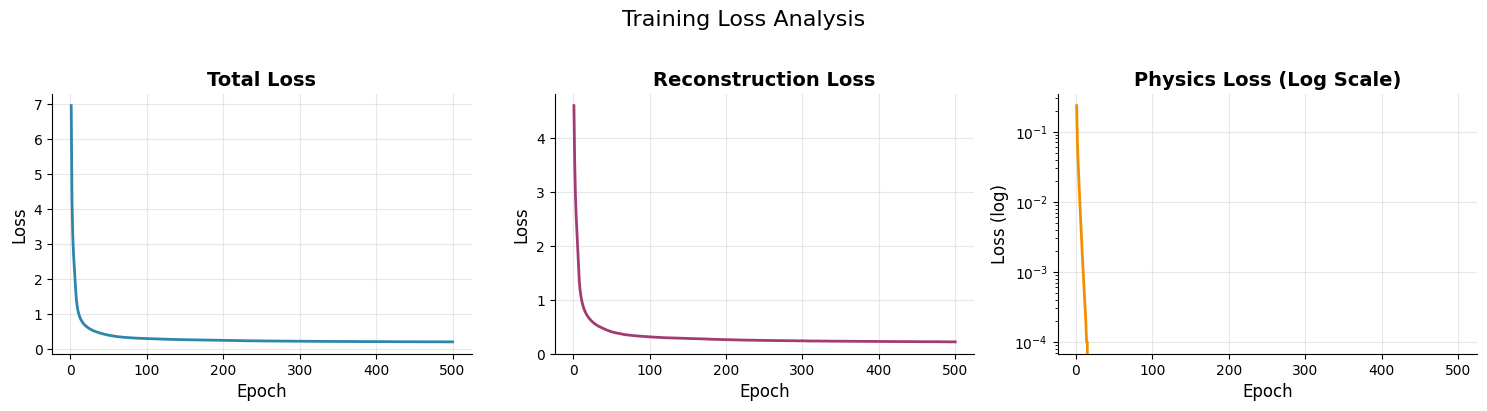

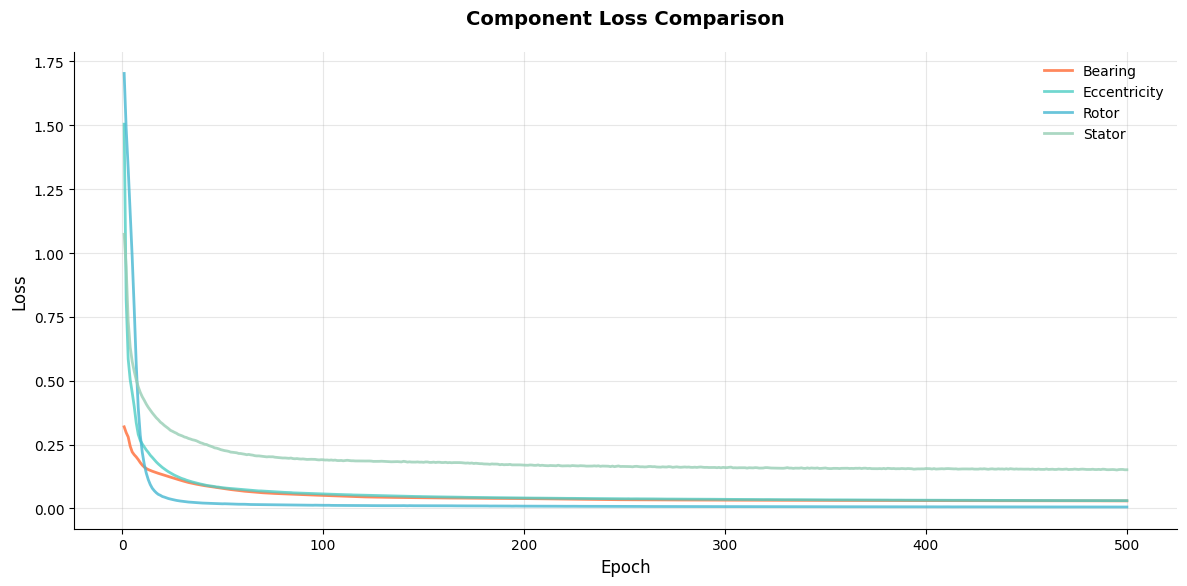

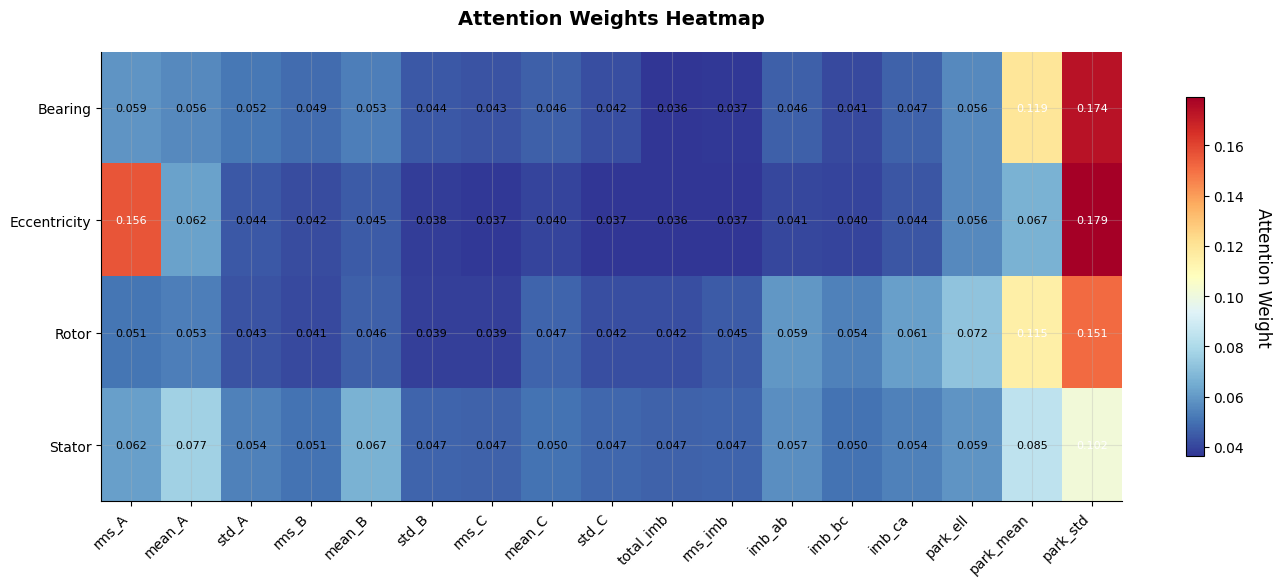

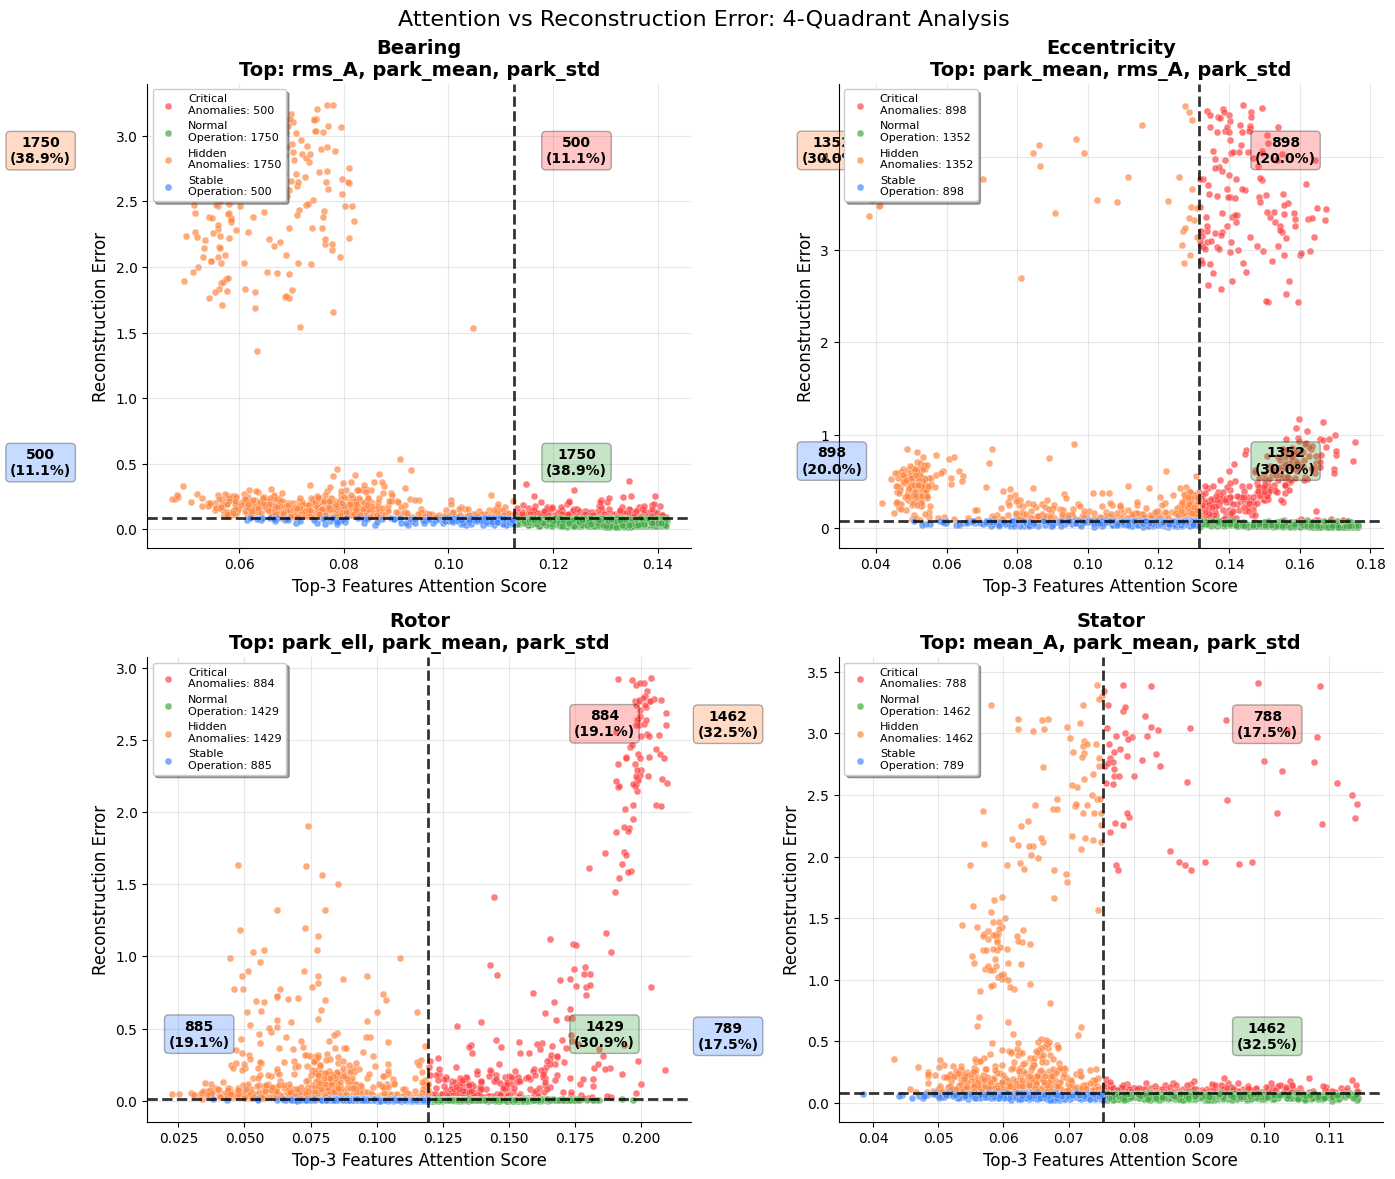

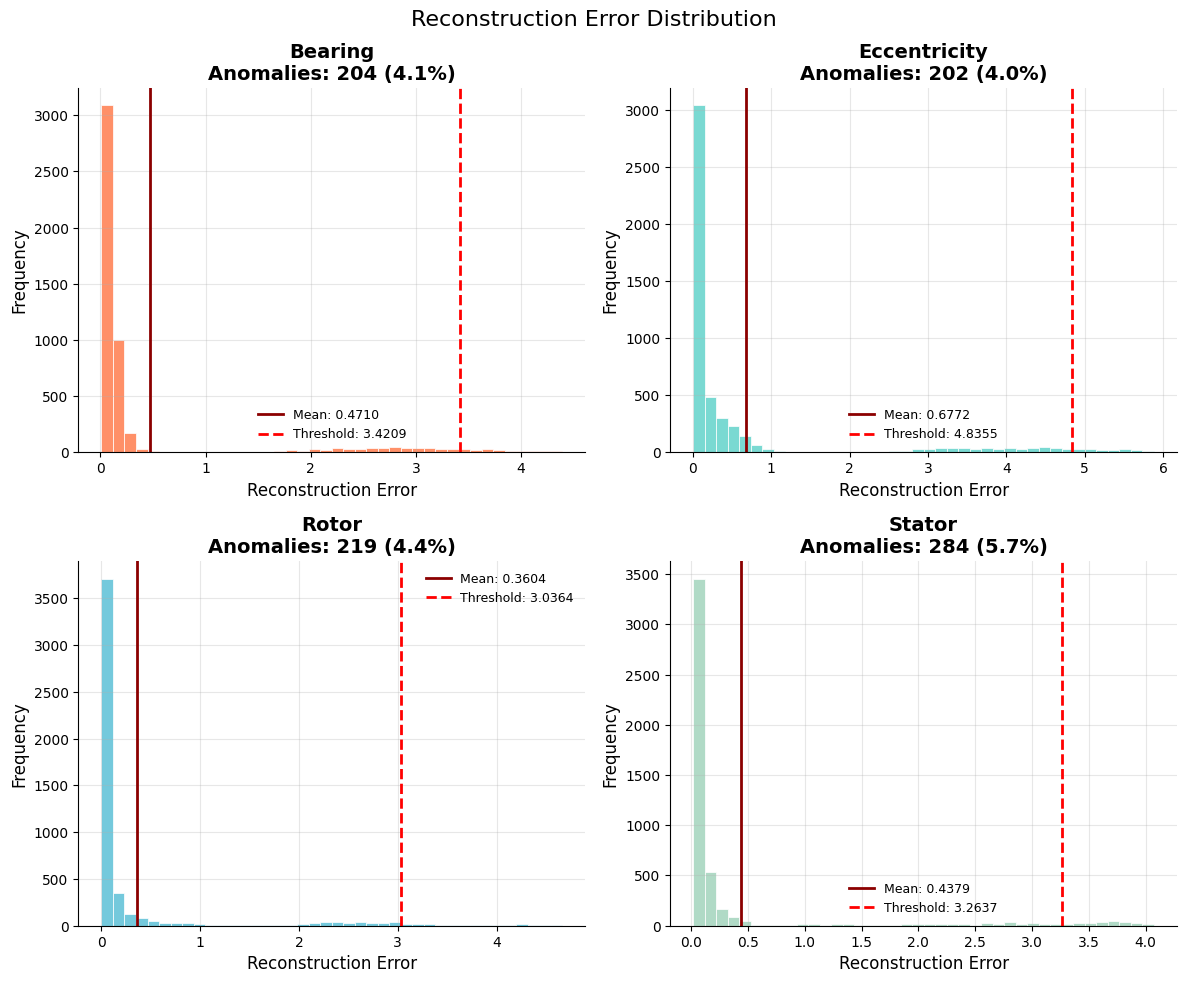

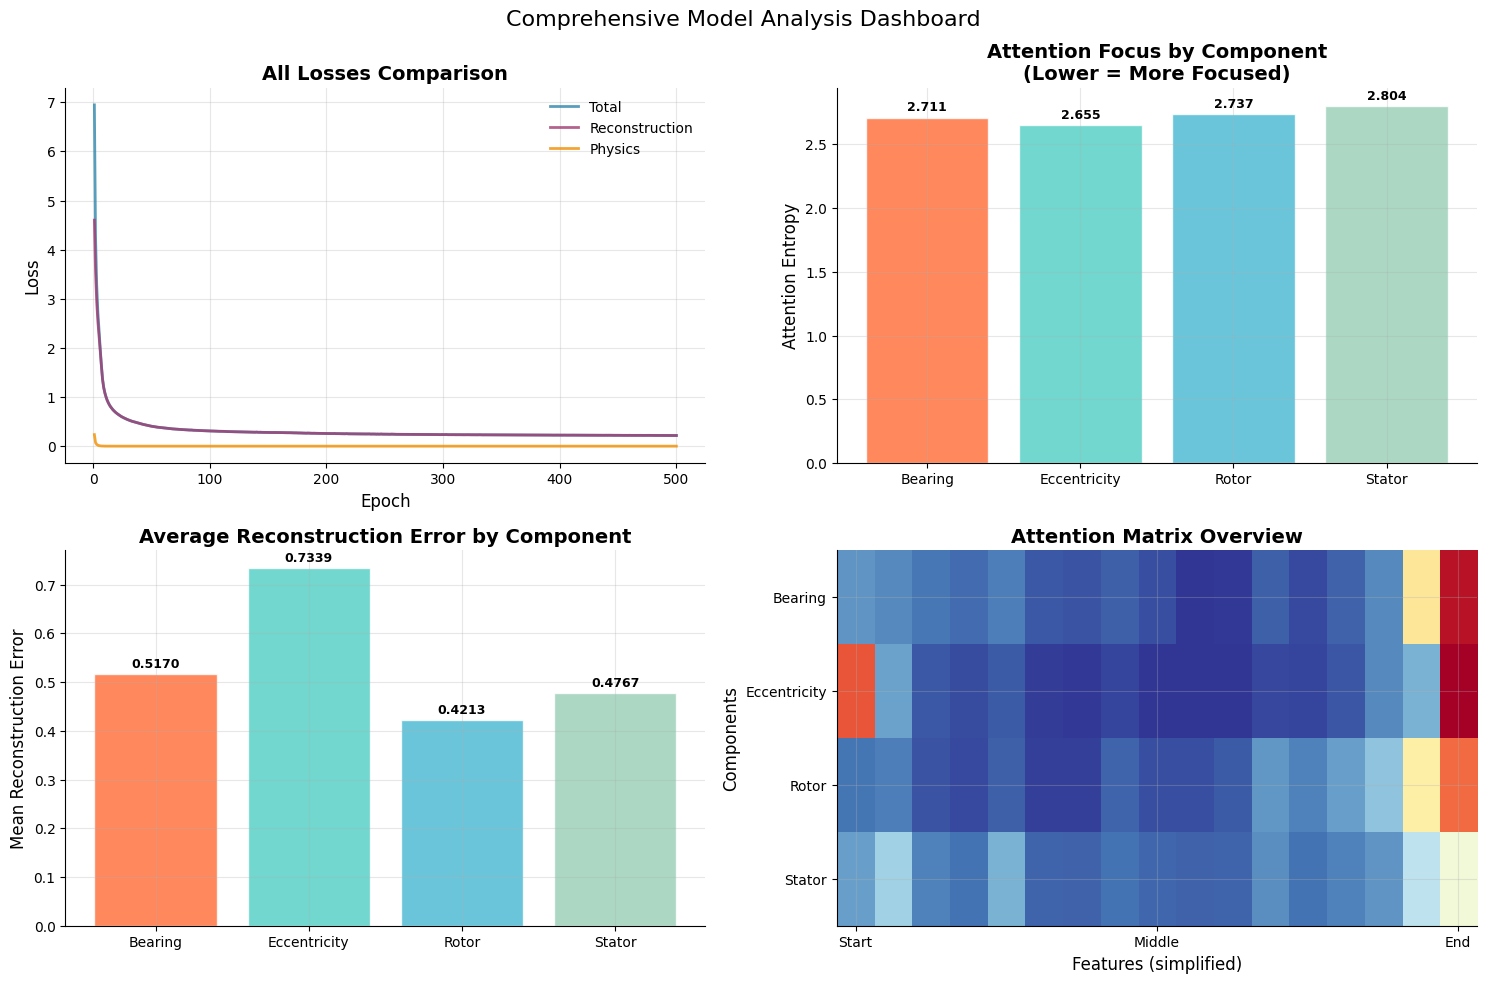

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use('default')
sns.set_palette("husl")
plt.rcParams.update({
    'font.size': 11, 'font.family': 'sans-serif', 'axes.labelsize': 12, 'axes.titlesize': 14,
    'xtick.labelsize': 10, 'ytick.labelsize': 10, 'legend.fontsize': 10, 'figure.titlesize': 16,
    'axes.spines.top': False, 'axes.spines.right': False, 'axes.grid': True, 'grid.alpha': 0.3, 'lines.linewidth': 2,
})

components = ['bearing', 'eccentricity', 'rotor', 'stator']
colors = ['#FF6B35', '#4ECDC4', '#45B7D1', '#96CEB4']

epochs = [int(item['Epoch']) for item in training_progress]
total_loss = [float(item['Total']) for item in training_progress]
recon_loss = [float(item['Recon']) for item in training_progress]
physics_loss = [float(item['Physics']) for item in training_progress]
bearing_loss = [float(item['Bearing']) for item in training_progress]
ecc_loss = [float(item['Eccentricity']) for item in training_progress]
rotor_loss = [float(item['Rotor']) for item in training_progress]
stator_loss = [float(item['Stator']) for item in training_progress]

predictions, attention_weights = autoencoder(normalized_data.astype(np.float32)[:1000], return_attention=True)
attention_matrix = np.array([
    np.mean(attention_weights['bearing'], axis=0),
    np.mean(attention_weights['eccentricity'], axis=0),
    np.mean(attention_weights['rotor'], axis=0),
    np.mean(attention_weights['stator'], axis=0)
])

common_feature_names = ['rms_A', 'mean_A', 'std_A', 'rms_B', 'mean_B', 'std_B', 
                       'rms_C', 'mean_C', 'std_C', 'total_imb', 'rms_imb',
                       'imb_ab', 'imb_bc', 'imb_ca', 'park_ell', 'park_mean', 'park_std']

# График 1: Анализ лоссов
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Training Loss Analysis', fontsize=16, y=1.02)

axes[0].plot(epochs, total_loss, color='#2E86AB', linewidth=2)
axes[0].set_title('Total Loss', fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True, alpha=0.3)

axes[1].plot(epochs, recon_loss, color='#A23B72', linewidth=2)
axes[1].set_title('Reconstruction Loss', fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].grid(True, alpha=0.3)

axes[2].semilogy(epochs, physics_loss, color='#F18F01', linewidth=2)
axes[2].set_title('Physics Loss (Log Scale)', fontweight='bold')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss (log)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# График 2: Компонентные лоссы
fig, ax = plt.subplots(figsize=(12, 6))
for component, color, loss_data in zip(components, colors, [bearing_loss, ecc_loss, rotor_loss, stator_loss]):
    ax.plot(epochs, loss_data, color=color, linewidth=2, label=component.capitalize(), alpha=0.8)
ax.set_title('Component Loss Comparison', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(frameon=False, loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# График 3: Attention Heatmap
fig, ax = plt.subplots(figsize=(14, 6))
im = ax.imshow(attention_matrix, cmap='RdYlBu_r', aspect='auto')
ax.set_xticks(range(len(common_feature_names)))
ax.set_xticklabels(common_feature_names, rotation=45, ha='right')
ax.set_yticks(range(len(components)))
ax.set_yticklabels([comp.capitalize() for comp in components])
for i in range(len(components)):
    for j in range(len(common_feature_names)):
        ax.text(j, i, f'{attention_matrix[i, j]:.3f}', ha="center", va="center", 
                color="white" if attention_matrix[i, j] > np.max(attention_matrix)/2 else "black", fontsize=8)
ax.set_title('Attention Weights Heatmap', fontsize=14, fontweight='bold', pad=20)
plt.colorbar(im, ax=ax, shrink=0.8).set_label('Attention Weight', rotation=270, labelpad=20)
plt.tight_layout()
plt.show()

# График 4: Attention vs Reconstruction Error
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Attention vs Reconstruction Error: 4-Quadrant Analysis', fontsize=16, y=0.98)
axes = axes.ravel()

quadrant_colors = {
    'high_att_high_err': '#FF4444',    # Красный - критические аномалии
    'high_att_low_err': '#44AA44',     # Зеленый - нормальная работа  
    'low_att_high_err': '#FF8844',     # Оранжевый - скрытые аномалии
    'low_att_low_err': '#4488FF'       # Синий - стабильная работа
}

quadrant_names = {
    'high_att_high_err': 'Critical\nAnomalies',
    'high_att_low_err': 'Normal\nOperation', 
    'low_att_high_err': 'Hidden\nAnomalies',
    'low_att_low_err': 'Stable\nOperation'
}

for i, (component, base_color) in enumerate(zip(components, colors)):
    errors = detailed_analysis_data[component]['reconstruction_errors']
    attention_weights_full = detailed_analysis_data[component]['attention_weights']
    top_features = np.argsort(attention_matrix[i])[-3:]
    attention_scores = np.mean(attention_weights_full[:, top_features], axis=1)
    
    attention_threshold = np.median(attention_scores)
    error_threshold = np.median(errors)

    error_limit = np.percentile(errors, 95)
    attention_limit = np.percentile(attention_scores, 95)
    outlier_mask = (errors < error_limit) & (attention_scores < attention_limit)

    errors = errors[outlier_mask]
    attention_scores = attention_scores[outlier_mask]

    attention_threshold = np.median(attention_scores) 
    error_threshold = np.median(errors)
    
    high_attention = attention_scores > attention_threshold
    high_error = errors > error_threshold
    
    masks = {
        'high_att_high_err': high_attention & high_error,
        'high_att_low_err': high_attention & ~high_error,
        'low_att_high_err': ~high_attention & high_error,
        'low_att_low_err': ~high_attention & ~high_error
    }
    
    n_samples = min(2000, len(errors))
    idx = np.random.choice(len(errors), n_samples, replace=False)

    for quadrant, mask in masks.items():
        mask_sampled = mask[idx]
        if np.any(mask_sampled):
            axes[i].scatter(attention_scores[idx][mask_sampled], 
                           errors[idx][mask_sampled], 
                           c=quadrant_colors[quadrant], 
                           alpha=0.7, s=25, 
                           label=f'{quadrant_names[quadrant]}: {np.sum(mask)}',
                           edgecolors='white', linewidth=0.3)

    axes[i].axvline(attention_threshold, color='black', linestyle='--', alpha=0.8, linewidth=2)
    axes[i].axhline(error_threshold, color='black', linestyle='--', alpha=0.8, linewidth=2)

    x_range = axes[i].get_xlim()
    y_range = axes[i].get_ylim()

    positions = {
        'high_att_high_err': (x_range[1]*0.85, y_range[1]*0.85),
        'high_att_low_err': (x_range[1]*0.85, y_range[1]*0.15),
        'low_att_high_err': (x_range[1]*0.15, y_range[1]*0.85),
        'low_att_low_err': (x_range[1]*0.15, y_range[1]*0.15)
    }
    
    for quadrant, (x_pos, y_pos) in positions.items():
        count = np.sum(masks[quadrant])
        percentage = (count / len(errors)) * 100
        axes[i].text(x_pos, y_pos, f'{count}\n({percentage:.1f}%)', 
                    ha='center', va='center',
                    bbox=dict(boxstyle='round,pad=0.3', 
                             facecolor=quadrant_colors[quadrant], 
                             alpha=0.3, edgecolor='black'),
                    fontsize=10, fontweight='bold')

    top_feature_names = [common_feature_names[idx] for idx in top_features]
    axes[i].set_title(f'{component.capitalize()}\nTop: {", ".join(top_feature_names)}', fontweight='bold')
    axes[i].set_xlabel('Top-3 Features Attention Score')
    axes[i].set_ylabel('Reconstruction Error')
    axes[i].grid(True, alpha=0.3)
    axes[i].legend(loc='upper left', fontsize=8, frameon=True, fancybox=True, shadow=True)

plt.tight_layout()
plt.show()

# Сводная таблица по квадрантам
quadrant_summary = []
for i, component in enumerate(components):
    errors = detailed_analysis_data[component]['reconstruction_errors']
    attention_weights_full = detailed_analysis_data[component]['attention_weights']
    top_features = np.argsort(attention_matrix[i])[-3:]
    attention_scores = np.mean(attention_weights_full[:, top_features], axis=1)
    
    attention_threshold = np.median(attention_scores)
    error_threshold = np.median(errors)
    
    high_attention = attention_scores > attention_threshold
    high_error = errors > error_threshold
    
    masks = {
        'Critical Anomalies': high_attention & high_error,
        'Normal Operation': high_attention & ~high_error,
        'Hidden Anomalies': ~high_attention & high_error,
        'Stable Operation': ~high_attention & ~high_error
    }
    
    for quadrant_name, mask in masks.items():
        count = np.sum(mask)
        percentage = (count / len(errors)) * 100
        avg_attention = np.mean(attention_scores[mask]) if count > 0 else 0
        avg_error = np.mean(errors[mask]) if count > 0 else 0
        
        quadrant_summary.append({
            'Component': component.capitalize(),
            'Quadrant': quadrant_name,
            'Count': count,
            'Percentage': f'{percentage:.1f}%',
            'Avg_Attention': f'{avg_attention:.4f}',
            'Avg_Error': f'{avg_error:.4f}'
        })

quadrant_df = pd.DataFrame(quadrant_summary)

# График 5: Распределения ошибок
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Reconstruction Error Distribution', fontsize=16, y=0.98)
axes = axes.ravel()

for i, (component, color) in enumerate(zip(components, colors)):
    errors = detailed_analysis_data[component]['reconstruction_errors']

    error_limit = np.percentile(errors, 99)
    errors_clipped = errors[errors < error_limit]

    mean_error = np.mean(errors_clipped)
    std_error = np.std(errors_clipped)
    threshold = mean_error + 3 * std_error

    anomalies = np.sum(errors > threshold)
    anomaly_rate = (anomalies / len(errors)) * 100

    axes[i].hist(errors_clipped, bins=40, color=color, alpha=0.75, edgecolor='white', linewidth=0.7)
    axes[i].axvline(mean_error, color='darkred', linestyle='-', linewidth=2, label=f'Mean: {mean_error:.4f}')
    axes[i].axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold: {threshold:.4f}')
    
    axes[i].set_title(
        f'{component.capitalize()}\nAnomalies: {anomalies} ({anomaly_rate:.1f}%)',
        fontweight='bold'
    )
    axes[i].set_xlabel('Reconstruction Error')
    axes[i].set_ylabel('Frequency')
    axes[i].legend(frameon=False, fontsize=9)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# График 6: Dashboard
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Comprehensive Model Analysis Dashboard', fontsize=16, y=0.98)

for loss, label, color in [(total_loss, 'Total', '#2E86AB'), (recon_loss, 'Reconstruction', '#A23B72'), (physics_loss, 'Physics', '#F18F01')]:
    ax1.plot(epochs, loss, color=color, linewidth=2, label=label, alpha=0.8)
ax1.set_title('All Losses Comparison', fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(frameon=False)
ax1.grid(True, alpha=0.3)


attention_entropy = [-np.sum(row * np.log(row + 1e-8)) for row in attention_matrix]
comp_labels = [comp.capitalize() for comp in components]

bars = ax2.bar(comp_labels, attention_entropy, color=colors, alpha=0.8, edgecolor='white', linewidth=1)
ax2.set_title('Attention Focus by Component\n(Lower = More Focused)', fontweight='bold')
ax2.set_ylabel('Attention Entropy')
ax2.grid(True, alpha=0.3, axis='y')
for bar, value in zip(bars, attention_entropy):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(attention_entropy)*0.01,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

error_means = [np.mean(detailed_analysis_data[comp]['reconstruction_errors']) for comp in components]
bars = ax3.bar(comp_labels, error_means, color=colors, alpha=0.8, edgecolor='white', linewidth=1)
ax3.set_title('Average Reconstruction Error by Component', fontweight='bold')
ax3.set_ylabel('Mean Reconstruction Error')
ax3.grid(True, alpha=0.3, axis='y')
for bar, value in zip(bars, error_means):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(error_means)*0.01,
             f'{value:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

im = ax4.imshow(attention_matrix, cmap='RdYlBu_r', aspect='auto')
ax4.set_title('Attention Matrix Overview', fontweight='bold')
ax4.set_xlabel('Features (simplified)')
ax4.set_ylabel('Components')
ax4.set_xticks([0, len(common_feature_names)//2, len(common_feature_names)-1])
ax4.set_xticklabels(['Start', 'Middle', 'End'])
ax4.set_yticks(range(len(components)))
ax4.set_yticklabels(comp_labels)

plt.tight_layout()
plt.show()


## Извлечение признаков для прогнозной модели

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import json
import os
from pathlib import Path

MODEL_WEIGHTS_PATH = 'models/multihead_attention_autoencoder_20250805_195221.weights.h5'

SHARED_ENCODER_DIMS = [128, 64]
ATTENTION_HEADS = 4
ATTENTION_KEY_DIM = 17
COMPONENT_LATENT_DIM = 32

BEARING_DECODER_DIMS = [48, 24, 30]   
ECC_DECODER_DIMS = [32, 29]        
ROTOR_DECODER_DIMS = [64, 32, 15]    
STATOR_DECODER_DIMS = [40, 28]

class MultiHeadAttentionAutoencoder(keras.Model):
    def __init__(self):
        super().__init__()
        
        self.shared_encoder = keras.Sequential([
            layers.Dense(SHARED_ENCODER_DIMS[0], activation='relu'),
            layers.BatchNormalization(),
            layers.Dense(SHARED_ENCODER_DIMS[1], activation='relu'),
            layers.BatchNormalization()
        ])
        
        self.bearing_encoder = layers.Dense(COMPONENT_LATENT_DIM, activation='tanh')
        self.eccentricity_encoder = layers.Dense(COMPONENT_LATENT_DIM, activation='selu')
        self.rotor_encoder = layers.Dense(COMPONENT_LATENT_DIM, activation='relu')
        self.stator_encoder = layers.Dense(COMPONENT_LATENT_DIM, activation='relu')
        
        self.bearing_attention = layers.MultiHeadAttention(num_heads=ATTENTION_HEADS, key_dim=ATTENTION_KEY_DIM, dropout=0.1)
        self.eccentricity_attention = layers.MultiHeadAttention(num_heads=ATTENTION_HEADS, key_dim=ATTENTION_KEY_DIM, dropout=0.1)
        self.rotor_attention = layers.MultiHeadAttention(num_heads=ATTENTION_HEADS, key_dim=ATTENTION_KEY_DIM, dropout=0.1)
        self.stator_attention = layers.MultiHeadAttention(num_heads=ATTENTION_HEADS, key_dim=ATTENTION_KEY_DIM, dropout=0.1)
        
        self.common_key_projection = layers.Dense(COMPONENT_LATENT_DIM, activation='linear')
        self.common_value_projection = layers.Dense(COMPONENT_LATENT_DIM, activation='linear')
        self.common_physics_projection = layers.Dense(17, activation='linear')
        
        self.bearing_decoder = keras.Sequential([layers.Dense(BEARING_DECODER_DIMS[1], activation='relu'), layers.Dense(BEARING_DECODER_DIMS[2], activation='linear')])
        self.eccentricity_decoder = keras.Sequential([layers.Dense(ECC_DECODER_DIMS[1], activation='linear')])
        self.rotor_decoder = keras.Sequential([layers.Dense(ROTOR_DECODER_DIMS[1], activation='relu'), layers.Dense(ROTOR_DECODER_DIMS[2], activation='linear')])
        self.stator_decoder = keras.Sequential([layers.Dense(STATOR_DECODER_DIMS[0], activation='relu'), layers.Dropout(0.2), layers.Dense(STATOR_DECODER_DIMS[1], activation='linear')])
    
    def call(self, inputs, training=False, return_attention=False):
        common_features = inputs[:, :17]
        shared_latent = self.shared_encoder(inputs, training=training)
        
        common_features_expanded = tf.expand_dims(common_features, -1)
        common_keys = self.common_key_projection(tf.broadcast_to(common_features_expanded, [tf.shape(common_features)[0], 17, 1]))
        common_values = self.common_value_projection(tf.broadcast_to(common_features_expanded, [tf.shape(common_features)[0], 17, 1]))
        
        position_encoding = tf.cast(tf.range(17), tf.float32) / 17.0
        position_encoding = tf.expand_dims(tf.expand_dims(position_encoding, 0), -1)
        common_keys = common_keys + tf.broadcast_to(position_encoding, tf.shape(common_keys))
        common_values = common_values + tf.broadcast_to(position_encoding, tf.shape(common_values))
        
        attention_weights = {}
        predictions = []
        
        components = [
            ('bearing', self.bearing_encoder, self.bearing_attention, self.bearing_decoder),
            ('eccentricity', self.eccentricity_encoder, self.eccentricity_attention, self.eccentricity_decoder),
            ('rotor', self.rotor_encoder, self.rotor_attention, self.rotor_decoder),
            ('stator', self.stator_encoder, self.stator_attention, self.stator_decoder)
        ]
        
        for component_name, encoder, attention, decoder in components:
            component_latent = encoder(shared_latent)
            component_query = tf.expand_dims(component_latent, 1)
            
            if return_attention:
                attended_features, attention_scores = attention(query=component_query, key=common_keys, value=common_values, return_attention_scores=True, training=training)
                attention_weights[component_name] = tf.reduce_mean(tf.squeeze(attention_scores, axis=2), axis=1)
            else:
                attended_features = attention(query=component_query, key=common_keys, value=common_values, training=training)
            
            attended_features = tf.squeeze(attended_features, 1)
            combined_features = component_latent + 0.5 * attended_features
            output = decoder(combined_features, training=training if component_name == 'stator' else False)
            predictions.append(output)
        
        if return_attention:
            return predictions, attention_weights
        return predictions
    
    def extract_component_latents(self, inputs, training=False):
        """Извлекает латентные представления компонентов"""
        shared_latent = self.shared_encoder(inputs, training=training)
        
        component_latents = {
            'bearing': self.bearing_encoder(shared_latent),
            'eccentricity': self.eccentricity_encoder(shared_latent),
            'rotor': self.rotor_encoder(shared_latent),
            'stator': self.stator_encoder(shared_latent)
        }
        
        return shared_latent, component_latents


def extract_autoencoder_features(df_common, df_bearing, df_eccentricity, df_rotor, df_stator, 
                                weights_path, output_dir='data/window_features/optimized_features', 
                                batch_size=1000):
    """
    Извлекает все признаки автоэнкодера для полного датасета
    
    Returns:
        pd.DataFrame: датафрейм с 268 новыми признаками автоэнкодера
    """
    
    print("🚀 Starting autoencoder feature extraction...")
    
    full_input_data = np.concatenate([
        df_common.values,
        df_bearing.values,
        df_eccentricity.values,
        df_rotor.values,
        df_stator.values
    ], axis=1)
    
    print(f"📊 Dataset shape: {full_input_data.shape}")
    
    normalization_stats = {
        'mean': full_input_data.mean(axis=0),
        'std': full_input_data.std(axis=0) + 1e-8
    }
    
    normalized_data = (full_input_data - normalization_stats['mean']) / normalization_stats['std']
    normalized_data_tf = tf.convert_to_tensor(normalized_data.astype(np.float32))
    
    model = MultiHeadAttentionAutoencoder()
    
    dummy_input = tf.random.normal((1, full_input_data.shape[1]))
    _ = model(dummy_input)
    model.load_weights(weights_path)
    
    threshold_path = MODEL_THRESHOLDS_PATH
    with open(threshold_path, 'r') as f:
        fixed_thresholds = json.load(f)
    
    print("✅ Model and thresholds loaded successfully")
    
    components = ['bearing', 'eccentricity', 'rotor', 'stator']
    feature_ranges = [(17, 47), (47, 76), (76, 91), (91, 119)]
    common_feature_names = ['rms_A', 'mean_A', 'std_A', 'rms_B', 'mean_B', 'std_B', 
                           'rms_C', 'mean_C', 'std_C', 'total_imb', 'rms_imb',
                           'imb_ab', 'imb_bc', 'imb_ca', 'park_ell', 'park_mean', 'park_std']
    
    all_features = []

    n_samples = len(normalized_data)
    n_batches = (n_samples + batch_size - 1) // batch_size
    
    print(f"🔄 Processing {n_samples} samples in {n_batches} batches...")
    
    for batch_idx in range(n_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, n_samples)
        
        batch_data = normalized_data_tf[start_idx:end_idx]
        
        print(f"   Batch {batch_idx + 1}/{n_batches}: samples {start_idx}-{end_idx-1}")

        predictions, attention_weights = model(batch_data, training=False, return_attention=True)
        shared_latent, component_latents = model.extract_component_latents(batch_data, training=False)

        predictions_np = [pred.numpy() for pred in predictions]
        attention_weights_np = {k: v.numpy() for k, v in attention_weights.items()}
        shared_latent_np = shared_latent.numpy()
        component_latents_np = {k: v.numpy() for k, v in component_latents.items()}

        for sample_idx in range(len(batch_data)):
            features = {}
            
            # 1. Shared latent features (64)
            for i in range(64):
                features[f'ae_shared_latent_{i+1}'] = shared_latent_np[sample_idx, i]
            
            # 2. Component latent features (32 * 4 = 128)
            for component in components:
                component_latent = component_latents_np[component][sample_idx]
                for i in range(32):
                    features[f'ae_{component}_latent_{i+1}'] = component_latent[i]
            
            # 3. Attention weights (17 * 4 = 68)
            for component in components:
                attention_weights_sample = attention_weights_np[component][sample_idx]
                for i, feature_name in enumerate(common_feature_names):
                    features[f'ae_{component}_att_{feature_name}'] = attention_weights_sample[i]
            
            # 4. Reconstruction errors (4)
            for comp_idx, (component, (start, end)) in enumerate(zip(components, feature_ranges)):
                true_values = batch_data[sample_idx, start:end].numpy()
                pred_values = predictions_np[comp_idx][sample_idx]
                reconstruction_error = np.mean((true_values - pred_values) ** 2)
                features[f'ae_{component}_error'] = reconstruction_error
            
            # 5. Confidence scores (4)
            for comp_idx, component in enumerate(components):
                baseline_error = features[f'ae_{component}_error']
                fixed_threshold = fixed_thresholds[component]['threshold']
                
                if baseline_error > fixed_threshold:
                    confidence = max(0.1, 1.0 - (baseline_error - fixed_threshold) / fixed_threshold)
                else:
                    confidence = min(0.9, (fixed_threshold - baseline_error) / fixed_threshold)
                
                features[f'ae_{component}_confidence'] = confidence
            
            all_features.append(features)

    autoencoder_features_df = pd.DataFrame(all_features)
    
    print(f"✅ Feature extraction completed!")
    print(f"📈 Extracted {len(autoencoder_features_df.columns)} autoencoder features:")
    print(f"   - Shared latent: 64 features")
    print(f"   - Component latents: 128 features (32 * 4)")
    print(f"   - Attention weights: 68 features (17 * 4)")
    print(f"   - Reconstruction errors: 4 features")
    print(f"   - Confidence scores: 4 features")
    print(f"   Total: {len(autoencoder_features_df.columns)} features")

    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, 'autoencoder_features.csv')
    autoencoder_features_df.to_csv(output_path, index=False)
    
    print(f"💾 Saved to: {output_path}")

    stats_df = pd.DataFrame({
        'Feature': autoencoder_features_df.columns,
        'Mean': autoencoder_features_df.mean(),
        'Std': autoencoder_features_df.std(),
        'Min': autoencoder_features_df.min(),
        'Max': autoencoder_features_df.max()
    })
    
    stats_path = os.path.join(output_dir, 'autoencoder_features_stats.csv')
    stats_df.to_csv(stats_path, index=False)
    
    print(f"📊 Feature statistics saved to: {stats_path}")
    
    return autoencoder_features_df


if __name__ == "__main__":
    
    try:
        autoencoder_features = extract_autoencoder_features(
            df_common=df_common,
            df_bearing=df_bearing, 
            df_eccentricity=df_eccentricity,
            df_rotor=df_rotor,
            df_stator=df_stator,
            weights_path=MODEL_WEIGHTS_PATH,
            batch_size=1000
        )
        
        print("\n🎉 SUCCESS! Autoencoder features extracted and saved!")
        print(f"📊 Shape: {autoencoder_features.shape}")
        print("\n📋 Sample of first 5 features:")
        print(autoencoder_features.iloc[:5, :5])
        
        # Проверяем наличие всех ожидаемых колонок
        expected_features = 64 + 128 + 68 + 4 + 4  # 268
        actual_features = len(autoencoder_features.columns)
        
        if actual_features == expected_features:
            print(f"✅ Perfect! Expected {expected_features} features, got {actual_features}")
        else:
            print(f"⚠️  Warning: Expected {expected_features} features, got {actual_features}")
            
    except Exception as e:
        print(f"❌ Error: {e}")
        import traceback
        traceback.print_exc()


🚀 Starting autoencoder feature extraction...
📊 Dataset shape: (23272, 119)


C:\Users\maxik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\layer.py:395: UserWarning: `build()` was called on layer 'multi_head_attention_autoencoder_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


✅ Model and thresholds loaded successfully
🔄 Processing 23272 samples in 24 batches...
   Batch 1/24: samples 0-999
   Batch 2/24: samples 1000-1999
   Batch 3/24: samples 2000-2999
   Batch 4/24: samples 3000-3999
   Batch 5/24: samples 4000-4999
   Batch 6/24: samples 5000-5999
   Batch 7/24: samples 6000-6999
   Batch 8/24: samples 7000-7999
   Batch 9/24: samples 8000-8999
   Batch 10/24: samples 9000-9999
   Batch 11/24: samples 10000-10999
   Batch 12/24: samples 11000-11999
   Batch 13/24: samples 12000-12999
   Batch 14/24: samples 13000-13999
   Batch 15/24: samples 14000-14999
   Batch 16/24: samples 15000-15999
   Batch 17/24: samples 16000-16999
   Batch 18/24: samples 17000-17999
   Batch 19/24: samples 18000-18999
   Batch 20/24: samples 19000-19999
   Batch 21/24: samples 20000-20999
   Batch 22/24: samples 21000-21999
   Batch 23/24: samples 22000-22999
   Batch 24/24: samples 23000-23271
✅ Feature extraction completed!
📈 Extracted 268 autoencoder features:
   - Shared 

🔍 Loading autoencoder features...
📊 Original shape: (23272, 268)

📋 Feature groups:
   shared_latent: 64 features
   component_latents: 128 features
   attention_weights: 68 features
   errors_confidence: 8 features

⚙️ Standardizing features...

🔬 ГРУППОВОЙ PCA АНАЛИЗ (target variance: 95.0%)

📊 Анализ группы: shared_latent
   Original features: 64
   PCA components: 43
   Explained variance: 0.950
   Compression ratio: 1.5x

📊 Анализ группы: component_latents
   Original features: 128
   PCA components: 57
   Explained variance: 0.952
   Compression ratio: 2.2x

📊 Анализ группы: attention_weights
   Original features: 68
   PCA components: 17
   Explained variance: 0.951
   Compression ratio: 4.0x

📊 Анализ группы: errors_confidence
   Original features: 8
   PCA components: 5
   Explained variance: 0.953
   Compression ratio: 1.6x

🔬 ОБЩИЙ PCA АНАЛИЗ (target variance: 95.0%)
   Original features: 268
   PCA components: 68
   Explained variance: 0.952
   Compression ratio: 3.9x

📊 СР

TypeError: Object of type int64 is not JSON serializable

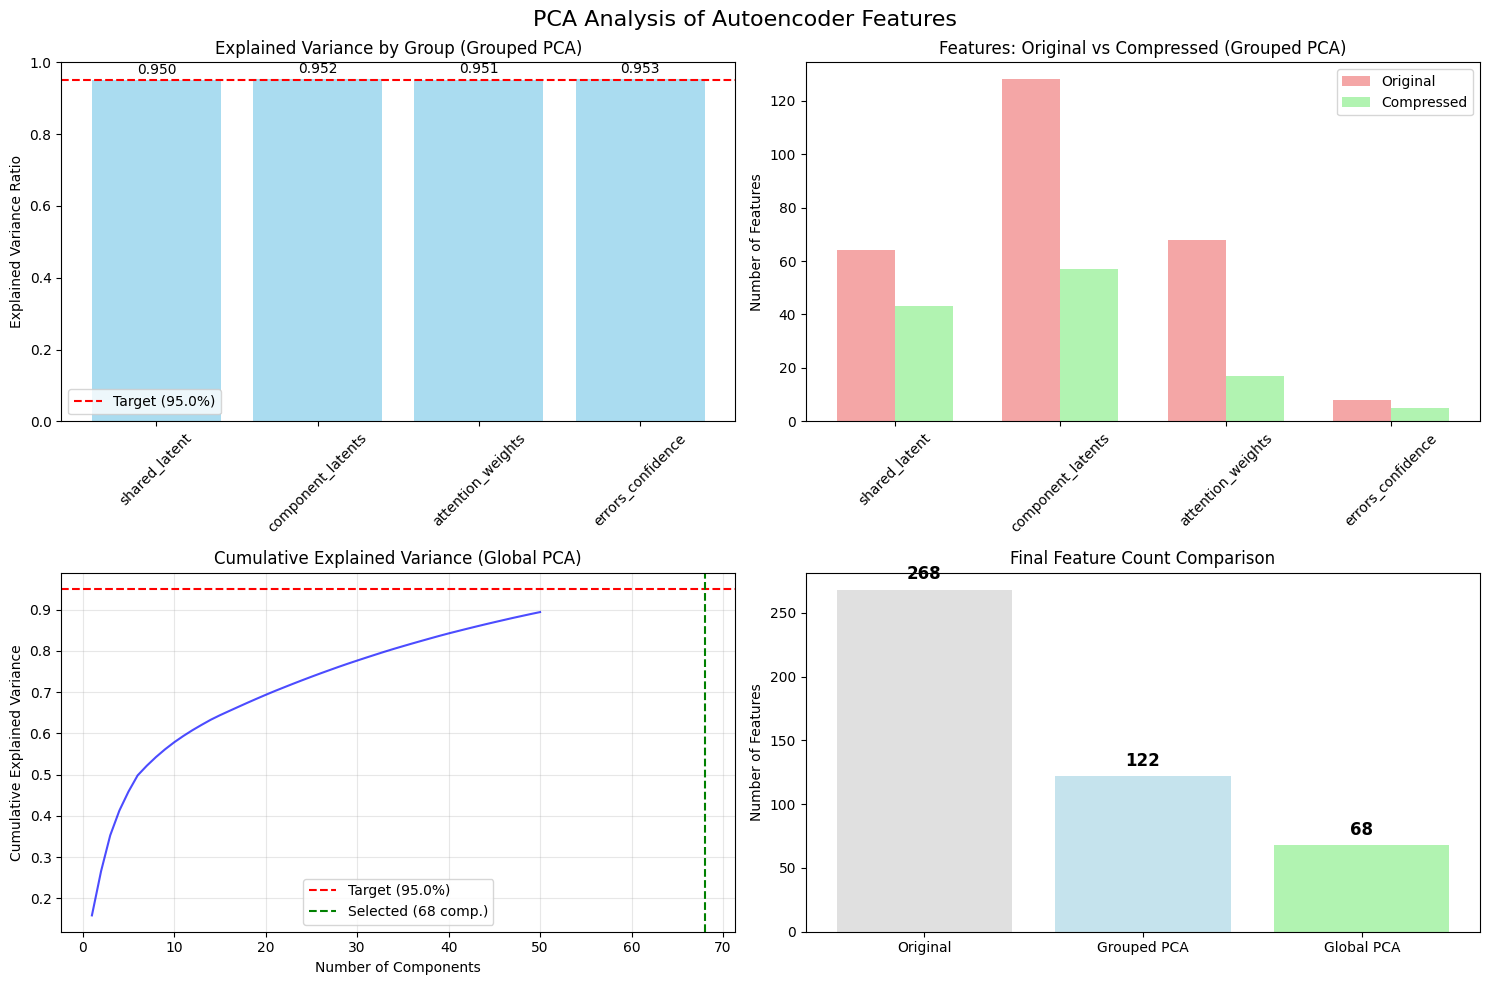

In [7]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

def analyze_and_compress_autoencoder_features(
    csv_path='data/window_features/optimized_features/autoencoder_features.csv',
    target_variance=0.95,
    output_dir='data/window_features/optimized_features'
):
    """
    Анализирует и сжимает признаки автоэнкодера с помощью PCA
    
    Args:
        csv_path: путь к файлу с признаками автоэнкодера
        target_variance: целевой процент объясненной дисперсии (0.95 = 95%)
        output_dir: директория для сохранения результатов
    """
    
    print("🔍 Loading autoencoder features...")
    df_ae = pd.read_csv(csv_path)
    print(f"📊 Original shape: {df_ae.shape}")
    
    # Группировка признаков по типам
    feature_groups = {
        'shared_latent': [col for col in df_ae.columns if 'shared_latent' in col],
        'component_latents': [col for col in df_ae.columns if any(comp in col and 'latent' in col for comp in ['bearing', 'eccentricity', 'rotor', 'stator']) and 'shared' not in col],
        'attention_weights': [col for col in df_ae.columns if '_att_' in col],
        'errors_confidence': [col for col in df_ae.columns if '_error' in col or '_confidence' in col]
    }
    
    print("\n📋 Feature groups:")
    for group_name, features in feature_groups.items():
        print(f"   {group_name}: {len(features)} features")
    
    # Стандартизация данных
    print("\n⚙️ Standardizing features...")
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(
        scaler.fit_transform(df_ae),
        columns=df_ae.columns,
        index=df_ae.index
    )
    
    # ===== ВАРИАНТ 1: ГРУППОВОЙ PCA =====
    print(f"\n🔬 ГРУППОВОЙ PCA АНАЛИЗ (target variance: {target_variance*100}%)")
    print("="*60)
    
    pca_results = {}
    compressed_features = {}
    
    for group_name, feature_list in feature_groups.items():
        if len(feature_list) == 0:
            continue
            
        print(f"\n📊 Анализ группы: {group_name}")
        group_data = df_scaled[feature_list]
        
        # PCA анализ
        pca = PCA()
        pca.fit(group_data)
        
        # Находим количество компонент для target_variance
        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
        n_components = np.argmax(cumulative_variance >= target_variance) + 1
        
        # Применяем PCA с оптимальным количеством компонент
        pca_optimal = PCA(n_components=n_components)
        compressed_data = pca_optimal.fit_transform(group_data)
        
        # Создаем DataFrame для сжатых данных
        compressed_columns = [f'pca_{group_name}_{i+1}' for i in range(n_components)]
        compressed_df = pd.DataFrame(
            compressed_data,
            columns=compressed_columns,
            index=df_ae.index
        )
        
        compressed_features[group_name] = compressed_df
        pca_results[group_name] = {
            'pca_model': pca_optimal,
            'scaler_features': feature_list,
            'original_features': len(feature_list),
            'compressed_features': n_components,
            'explained_variance': pca_optimal.explained_variance_ratio_.sum(),
            'compression_ratio': len(feature_list) / n_components
        }
        
        print(f"   Original features: {len(feature_list)}")
        print(f"   PCA components: {n_components}")
        print(f"   Explained variance: {pca_optimal.explained_variance_ratio_.sum():.3f}")
        print(f"   Compression ratio: {len(feature_list) / n_components:.1f}x")
    
    # Объединяем все сжатые группы
    compressed_grouped = pd.concat(list(compressed_features.values()), axis=1)
    
    # ===== ВАРИАНТ 2: ОБЩИЙ PCA =====
    print(f"\n🔬 ОБЩИЙ PCA АНАЛИЗ (target variance: {target_variance*100}%)")
    print("="*60)
    
    # PCA для всех признаков сразу
    pca_global = PCA()
    pca_global.fit(df_scaled)
    
    # Находим количество компонент для target_variance
    cumulative_variance_global = np.cumsum(pca_global.explained_variance_ratio_)
    n_components_global = np.argmax(cumulative_variance_global >= target_variance) + 1
    
    # Применяем PCA с оптимальным количеством компонент
    pca_global_optimal = PCA(n_components=n_components_global)
    compressed_global = pca_global_optimal.fit_transform(df_scaled)
    
    # Создаем DataFrame для глобального PCA
    global_columns = [f'pca_global_{i+1}' for i in range(n_components_global)]
    compressed_global_df = pd.DataFrame(
        compressed_global,
        columns=global_columns,
        index=df_ae.index
    )
    
    print(f"   Original features: {df_ae.shape[1]}")
    print(f"   PCA components: {n_components_global}")
    print(f"   Explained variance: {pca_global_optimal.explained_variance_ratio_.sum():.3f}")
    print(f"   Compression ratio: {df_ae.shape[1] / n_components_global:.1f}x")
    
    # ===== СРАВНЕНИЕ ПОДХОДОВ =====
    print(f"\n📊 СРАВНЕНИЕ ПОДХОДОВ:")
    print("="*60)
    
    grouped_total = compressed_grouped.shape[1]
    global_total = compressed_global_df.shape[1]
    
    print(f"Групповой PCA: {df_ae.shape[1]} → {grouped_total} признаков ({df_ae.shape[1] / grouped_total:.1f}x сжатие)")
    print(f"Общий PCA:     {df_ae.shape[1]} → {global_total} признаков ({df_ae.shape[1] / global_total:.1f}x сжатие)")
    print(f"Разница:       {abs(grouped_total - global_total)} признаков")
    
    # ===== ВИЗУАЛИЗАЦИЯ =====
    print(f"\n📈 Создание визуализации...")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('PCA Analysis of Autoencoder Features', fontsize=16)
    
    # 1. Групповой PCA - объясненная дисперсия
    ax1 = axes[0, 0]
    group_names = list(pca_results.keys())
    explained_variances = [pca_results[group]['explained_variance'] for group in group_names]
    
    bars = ax1.bar(group_names, explained_variances, alpha=0.7, color='skyblue')
    ax1.set_title('Explained Variance by Group (Grouped PCA)')
    ax1.set_ylabel('Explained Variance Ratio')
    ax1.set_ylim(0, 1)
    ax1.axhline(y=target_variance, color='red', linestyle='--', label=f'Target ({target_variance*100}%)')
    ax1.legend()
    plt.setp(ax1.get_xticklabels(), rotation=45)
    
    # Добавляем значения на столбцы
    for bar, variance in zip(bars, explained_variances):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{variance:.3f}', ha='center', va='bottom', fontsize=10)
    
    # 2. Сравнение сжатия
    ax2 = axes[0, 1]
    compression_data = {
        'Original': [pca_results[group]['original_features'] for group in group_names],
        'Compressed': [pca_results[group]['compressed_features'] for group in group_names]
    }
    
    x = np.arange(len(group_names))
    width = 0.35
    
    ax2.bar(x - width/2, compression_data['Original'], width, label='Original', alpha=0.7, color='lightcoral')
    ax2.bar(x + width/2, compression_data['Compressed'], width, label='Compressed', alpha=0.7, color='lightgreen')
    
    ax2.set_title('Features: Original vs Compressed (Grouped PCA)')
    ax2.set_ylabel('Number of Features')
    ax2.set_xticks(x)
    ax2.set_xticklabels(group_names)
    ax2.legend()
    plt.setp(ax2.get_xticklabels(), rotation=45)
    
    # 3. Глобальный PCA - кумулятивная дисперсия
    ax3 = axes[1, 0]
    n_show = min(50, len(cumulative_variance_global))  # Показываем первые 50 компонент
    ax3.plot(range(1, n_show + 1), cumulative_variance_global[:n_show], 'b-', alpha=0.7)
    ax3.axhline(y=target_variance, color='red', linestyle='--', label=f'Target ({target_variance*100}%)')
    ax3.axvline(x=n_components_global, color='green', linestyle='--', label=f'Selected ({n_components_global} comp.)')
    ax3.set_title('Cumulative Explained Variance (Global PCA)')
    ax3.set_xlabel('Number of Components')
    ax3.set_ylabel('Cumulative Explained Variance')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Сравнение итогового сжатия
    ax4 = axes[1, 1]
    methods = ['Original', 'Grouped PCA', 'Global PCA']
    feature_counts = [df_ae.shape[1], grouped_total, global_total]
    colors = ['lightgray', 'lightblue', 'lightgreen']
    
    bars = ax4.bar(methods, feature_counts, alpha=0.7, color=colors)
    ax4.set_title('Final Feature Count Comparison')
    ax4.set_ylabel('Number of Features')
    
    # Добавляем значения на столбцы
    for bar, count in zip(bars, feature_counts):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 5,
                f'{count}', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    
    # Сохранение графика
    plot_path = Path(output_dir) / 'pca_analysis.png'
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"📊 График сохранен: {plot_path}")
    
    # ===== СОХРАНЕНИЕ РЕЗУЛЬТАТОВ =====
    print(f"\n💾 Сохранение результатов...")
    
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Сохраняем сжатые данные
    grouped_path = output_path / 'autoencoder_features_pca_grouped.csv'
    compressed_grouped.to_csv(grouped_path, index=False)
    
    global_path = output_path / 'autoencoder_features_pca_global.csv'
    compressed_global_df.to_csv(global_path, index=False)
    
    # Сохраняем информацию о PCA трансформации
    pca_info = {
        'target_variance': target_variance,
        'original_features': df_ae.shape[1],
        'grouped_pca': {
            'total_components': grouped_total,
            'compression_ratio': df_ae.shape[1] / grouped_total,
            'groups': {group: {
                'original': info['original_features'],
                'compressed': info['compressed_features'],
                'explained_variance': info['explained_variance'],
                'compression_ratio': info['compression_ratio']
            } for group, info in pca_results.items()}
        },
        'global_pca': {
            'total_components': global_total,
            'compression_ratio': df_ae.shape[1] / global_total,
            'explained_variance': pca_global_optimal.explained_variance_ratio_.sum()
        }
    }
    
    import json
    info_path = output_path / 'pca_analysis_info.json'
    with open(info_path, 'w') as f:
        json.dump(pca_info, f, indent=2)
    
    print(f"✅ Групповой PCA: {grouped_path}")
    print(f"✅ Глобальный PCA: {global_path}")
    print(f"✅ Информация о PCA: {info_path}")
    
    # ===== РЕКОМЕНДАЦИИ =====
    print(f"\n🎯 РЕКОМЕНДАЦИИ:")
    print("="*60)
    
    if grouped_total < global_total:
        print(f"🏆 Групповой PCA эффективнее: {grouped_total} vs {global_total} признаков")
        print(f"📈 Используйте: autoencoder_features_pca_grouped.csv")
        best_result = compressed_grouped
        best_method = "grouped"
    else:
        print(f"🏆 Глобальный PCA эффективнее: {global_total} vs {grouped_total} признаков")
        print(f"📈 Используйте: autoencoder_features_pca_global.csv")
        best_result = compressed_global_df
        best_method = "global"
    
    print(f"🔥 Сжатие: {df_ae.shape[1]} → {best_result.shape[1]} признаков ({df_ae.shape[1] / best_result.shape[1]:.1f}x)")
    print(f"📊 Объясненная дисперсия: ≥{target_variance*100}%")
    
    plt.show()
    
    return best_result, best_method, pca_info

# ЗАПУСК
if __name__ == "__main__":
    compressed_features, best_method, analysis_info = analyze_and_compress_autoencoder_features()
    
    print(f"\n🎉 ГОТОВО! Лучший метод: {best_method}")
    print(f"📊 Итоговая размерность: {compressed_features.shape}")


## Подготовка данных к проностической модели

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

files = [
    'data/window_features/optimized_features/df_bearing_features.csv',
    'data/window_features/optimized_features/df_common_features.csv', 
    'data/window_features/optimized_features/df_eccentricity_features.csv',
    'data/window_features/optimized_features/df_rotor_features.csv',
    'data/window_features/optimized_features/df_stator_features.csv',
    'data/window_features/optimized_features/autoencoder_features_pca_global.csv'
]

df_bearing, df_common, df_eccentricity, df_rotor, df_stator, df_autoencoder_pca = [pd.read_csv(f) for f in files]

meta_cols = ['file_name', 'file_index', 'window_index', 'window_start_sample', 
             'window_end_sample', 'time_start_sec', 'time_end_sec']

dfs = [df_bearing, df_common, df_eccentricity, df_rotor, df_stator, df_autoencoder_pca]
names = ['bearing', 'common', 'eccentricity', 'rotor', 'stator', 'autoencoder_pca']
info = []

for i, df in enumerate(dfs):
    rows = df.shape[0]
    cols_before = df.shape[1]
    
    # Удаляем мета-колонки
    df.drop(columns=[col for col in meta_cols if col in df.columns], inplace=True)
    
    missing_before = df.isnull().sum().sum()

    imputer = KNNImputer(n_neighbors=5)
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    missing_after = df_imputed.isnull().sum().sum()
    final_features = df_imputed.shape[1]
    
    info.append({
        'Датафрейм': names[i],
        'Строк': rows,
        'Столбцов до': cols_before,
        'Пропусков до': missing_before,
        'Пропусков после': missing_after,
        'Заполнено': missing_before - missing_after,
        'Финальных признаков': final_features
    })
    
    dfs[i] = df_imputed

df_bearing, df_common, df_eccentricity, df_rotor, df_stator, df_autoencoder_pca = dfs

display(pd.DataFrame(info))

df_original = pd.concat([df_common, df_bearing, df_eccentricity, df_rotor, df_stator], axis=1)
df_enhanced = pd.concat([df_original, df_autoencoder_pca], axis=1)

print(f"\nOriginal features: {df_original.shape}")
print(f"Enhanced features: {df_enhanced.shape}")
print(f"Total features: {df_enhanced.shape[1]}")


,Датафрейм,Строк,Столбцов до,Пропусков до,Пропусков после,Заполнено,Финальных признаков
0,bearing,23272,37,26064,0,26064,30
1,common,23272,24,26064,0,26064,17
2,eccentricity,23272,36,39096,0,39096,29
3,rotor,23272,22,0,0,0,15
4,stator,23272,35,9774,0,9774,28
5,autoencoder_pca,23272,68,0,0,0,68



Original features: (23272, 119)
Enhanced features: (23272, 187)
Total features: 187


# Прогностическая модель

## DUAL-LSTM

In [ ]:
# DUAL-LSTM на 119 + 68 признаков

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, RobustScaler
import time
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

SEQUENCE_LENGTH = 10
PREDICTION_STEPS = 1
BATCH_SIZE = 32
EPOCHS = 200
PATIENCE = 25
MIN_DELTA = 1e-6

def create_sequences_with_augmentation(data, seq_length, pred_steps, augment=False):
    X, y = [], []
    for i in range(len(data) - seq_length - pred_steps + 1):
        sequence = data[i:(i + seq_length)]
        target = data[i + seq_length:i + seq_length + pred_steps, :119]
        
        X.append(sequence)
        y.append(target)
        
        if augment and np.random.random() < 0.3:
            noise_factor = 0.01
            noisy_sequence = sequence + np.random.normal(0, noise_factor, sequence.shape)
            X.append(noisy_sequence)
            y.append(target)
            
            jitter_strength = 0.02
            jittered_sequence = sequence + np.random.normal(0, jitter_strength, sequence.shape)
            X.append(jittered_sequence)
            y.append(target)
    
    return np.array(X), np.array(y)

def time_series_split_validation(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    splits = []
    for train_idx, val_idx in tscv.split(X):
        splits.append((train_idx, val_idx))
    return splits

scaler_robust = RobustScaler()
data_normalized = scaler_robust.fit_transform(df_enhanced.values)

X_full, y_full = create_sequences_with_augmentation(
    data_normalized, SEQUENCE_LENGTH, PREDICTION_STEPS, augment=True
)

train_size = int(0.7 * len(X_full))
val_size = int(0.15 * len(X_full))

X_train = X_full[:train_size]
y_train = y_full[:train_size]
X_val = X_full[train_size:train_size+val_size]
y_val = y_full[train_size:train_size+val_size]
X_test = X_full[train_size+val_size:]
y_test = y_full[train_size+val_size:]

data_splits_info = pd.DataFrame({
    'Split': ['Train', 'Validation', 'Test', 'Total'],
    'Samples': [len(X_train), len(X_val), len(X_test), len(X_full)],
    'Percentage': [f"{len(X_train)/len(X_full)*100:.1f}%",
                   f"{len(X_val)/len(X_full)*100:.1f}%", 
                   f"{len(X_test)/len(X_full)*100:.1f}%", "100.0%"],
    'Augmented': ['Yes', 'No', 'No', 'Partial']
})
display(data_splits_info)

class AdvancedDualChannelLSTM(keras.Model):
    def __init__(self, l2_reg=0.001):
        super().__init__()
        
        self.main_bn1 = layers.BatchNormalization()
        self.main_lstm1 = layers.LSTM(
            128, return_sequences=True, dropout=0.2, recurrent_dropout=0.1,
            kernel_regularizer=regularizers.l2(l2_reg),
            bias_regularizer=regularizers.l1(l2_reg/10)
        )
        self.main_bn2 = layers.BatchNormalization()
        self.main_lstm2 = layers.LSTM(
            64, dropout=0.2, recurrent_dropout=0.1,
            kernel_regularizer=regularizers.l2(l2_reg)
        )
        self.main_dense = layers.Dense(
            64, activation='relu',
            kernel_regularizer=regularizers.l2(l2_reg)
        )
        self.main_dropout = layers.Dropout(0.3)
        
        self.aux_bn1 = layers.BatchNormalization()
        self.aux_lstm1 = layers.LSTM(
            64, return_sequences=True, dropout=0.15, recurrent_dropout=0.1,
            kernel_regularizer=regularizers.l2(l2_reg)
        )
        self.aux_bn2 = layers.BatchNormalization()
        self.aux_lstm2 = layers.LSTM(
            32, dropout=0.15, recurrent_dropout=0.1,
            kernel_regularizer=regularizers.l2(l2_reg)
        )
        self.aux_dense = layers.Dense(
            32, activation='relu',
            kernel_regularizer=regularizers.l2(l2_reg)
        )
        self.aux_dropout = layers.Dropout(0.2)
        
        self.fusion_bn = layers.BatchNormalization()
        self.fusion_dense1 = layers.Dense(
            128, activation='relu',
            kernel_regularizer=regularizers.l2(l2_reg)
        )
        self.fusion_dropout1 = layers.Dropout(0.3)
        self.fusion_dense2 = layers.Dense(
            64, activation='relu',
            kernel_regularizer=regularizers.l2(l2_reg/2)
        )
        self.fusion_dropout2 = layers.Dropout(0.2)
        
        self.output_dense = layers.Dense(
            119 * PREDICTION_STEPS,
            kernel_regularizer=regularizers.l2(l2_reg/5)
        )
    
    def call(self, inputs, training=False):
        original_features = inputs[:, :, :119]
        ae_features = inputs[:, :, 119:]
        
        main_x = self.main_bn1(original_features, training=training)
        main_x = self.main_lstm1(main_x, training=training)
        main_x = self.main_bn2(main_x, training=training)
        main_x = self.main_lstm2(main_x, training=training)
        main_x = self.main_dense(main_x)
        main_x = self.main_dropout(main_x, training=training)
        
        aux_x = self.aux_bn1(ae_features, training=training)
        aux_x = self.aux_lstm1(aux_x, training=training)
        aux_x = self.aux_bn2(aux_x, training=training)
        aux_x = self.aux_lstm2(aux_x, training=training)
        aux_x = self.aux_dense(aux_x)
        aux_x = self.aux_dropout(aux_x, training=training)
        
        fused = tf.concat([main_x, aux_x], axis=-1)
        fused = self.fusion_bn(fused, training=training)
        fused = self.fusion_dense1(fused)
        fused = self.fusion_dropout1(fused, training=training)
        fused = self.fusion_dense2(fused)
        fused = self.fusion_dropout2(fused, training=training)
        
        output = self.output_dense(fused)
        return tf.reshape(output, (-1, PREDICTION_STEPS, 119))

class CyclicLR(keras.callbacks.Callback):
    def __init__(self, base_lr=1e-5, max_lr=1e-3, step_size=1000):
        super().__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.iteration = 0
        
    def on_batch_begin(self, batch, logs=None):
        cycle = np.floor(1 + self.iteration / (2 * self.step_size))
        x = np.abs(self.iteration / self.step_size - 2 * cycle + 1)
        lr = self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x))
        
        self.model.optimizer.learning_rate.assign(lr)
        self.iteration += 1

class ValidationMonitor(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.val_losses = []
        self.train_losses = []
        self.overfitting_ratio = []
        
    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        train_loss = logs.get('loss')
        
        self.val_losses.append(val_loss)
        self.train_losses.append(train_loss)
        
        if train_loss > 0:
            ratio = val_loss / train_loss
            self.overfitting_ratio.append(ratio)
        
        if epoch > 10 and len(self.overfitting_ratio) >= 3:
            recent_ratio = np.mean(self.overfitting_ratio[-3:])
            if recent_ratio > 1.5:
                print(f"\nWarning: Overfitting detected at epoch {epoch+1} (ratio: {recent_ratio:.3f})")

def create_advanced_callbacks(model_dir):
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=PATIENCE,
            restore_best_weights=True,
            min_delta=MIN_DELTA,
            mode='min',
            verbose=1
        ),
        
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.7,
            patience=10,
            min_lr=1e-7,
            verbose=1,
            mode='min'
        ),
        
        keras.callbacks.ModelCheckpoint(
            f'{model_dir}/best_model.keras',
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=False,
            verbose=0
        ),
        
        CyclicLR(base_lr=1e-5, max_lr=1e-3, step_size=500),
        
        ValidationMonitor(),
        
        keras.callbacks.TerminateOnNaN()
    ]
    
    return callbacks

model = AdvancedDualChannelLSTM(l2_reg=0.001)

optimizer = keras.optimizers.Adam(
    learning_rate=1e-3,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7,
    clipnorm=1.0
)

model.compile(
    optimizer=optimizer,
    loss=keras.losses.Huber(delta=0.5),
    metrics=['mae', 'mse']
)

dummy_input = tf.random.normal((1, SEQUENCE_LENGTH, 187))
_ = model(dummy_input)

architecture_info = pd.DataFrame({
    'Component': ['Total Parameters', 'Regularization', 'Loss Function', 'Optimizer', 'Gradient Clipping', 'Data Augmentation'],
    'Details': [f"{model.count_params():,}",
                'L1+L2+Dropout+BatchNorm',
                'Huber Loss (δ=0.5)', 
                'Adam + Cyclic LR',
                'ClipNorm=1.0',
                'Noise + Jitter (30%)']
})
display(architecture_info)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_dir = f"models/prognostic_models/advanced_dual_lstm_{timestamp}"
os.makedirs(model_dir, exist_ok=True)

callbacks = create_advanced_callbacks(model_dir)

class TrainingTracker:
    def __init__(self):
        self.history = []
        self.best_val_loss = float('inf')
        self.patience_counter = 0
        
    def update(self, epoch, logs):
        self.history.append({
            'epoch': epoch + 1,
            'train_loss': logs['loss'],
            'train_mae': logs['mae'],
            'val_loss': logs['val_loss'],
            'val_mae': logs['val_mae'],
            'lr': float(logs.get('lr', 0)),
            'overfitting_ratio': logs['val_loss'] / logs['loss']
        })

tracker = TrainingTracker()

class DetailedCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        tracker.update(epoch, logs)

callbacks.append(DetailedCallback())

print("Starting advanced training with overfitting prevention...")
start_time = time.time()

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time

train_loss, train_mae, train_mse = model.evaluate(X_train, y_train, verbose=0)
val_loss, val_mae, val_mse = model.evaluate(X_val, y_val, verbose=0)
test_loss, test_mae, test_mse = model.evaluate(X_test, y_test, verbose=0)

final_results = pd.DataFrame({
    'Dataset': ['Train', 'Validation', 'Test'],
    'Loss': [train_loss, val_loss, test_loss],
    'MAE': [train_mae, val_mae, test_mae],
    'RMSE': [np.sqrt(train_mse), np.sqrt(val_mse), np.sqrt(test_mse)],
    'Samples': [len(X_train), len(X_val), len(X_test)]
})
display(final_results)

overfitting_analysis = pd.DataFrame({
    'Metric': ['Train/Val Loss Ratio', 'Train/Test Loss Ratio', 'Final Overfitting', 'Training Stability', 'Early Stop Epoch'],
    'Value': [f"{val_loss/train_loss:.3f}",
              f"{test_loss/train_loss:.3f}",
              f"{((val_loss/train_loss - 1)*100):.1f}%",
              f"{1 - np.std([train_loss, val_loss, test_loss])/np.mean([train_loss, val_loss, test_loss]):.3f}",
              f"{len(history.history['loss'])}"]
})
display(overfitting_analysis)

if len(tracker.history) > 0:
    training_progress = pd.DataFrame(tracker.history)
    
    convergence_analysis = pd.DataFrame({
        'Phase': ['Initial (1-10)', 'Middle (10-30)', 'Final (last 10)', 'Best Performance'],
        'Avg_Val_Loss': [
            np.mean([h['val_loss'] for h in tracker.history[:10]]),
            np.mean([h['val_loss'] for h in tracker.history[10:30]]) if len(tracker.history) > 30 else np.nan,
            np.mean([h['val_loss'] for h in tracker.history[-10:]]),
            min([h['val_loss'] for h in tracker.history])
        ],
        'Avg_Overfitting_Ratio': [
            np.mean([h['overfitting_ratio'] for h in tracker.history[:10]]),
            np.mean([h['overfitting_ratio'] for h in tracker.history[10:30]]) if len(tracker.history) > 30 else np.nan,
            np.mean([h['overfitting_ratio'] for h in tracker.history[-10:]]),
            min([h['overfitting_ratio'] for h in tracker.history])
        ]
    })
    display(convergence_analysis)

regularization_effectiveness = pd.DataFrame({
    'Technique': ['Data Augmentation', 'L1/L2 Regularization', 'Dropout Layers', 'Batch Normalization', 'Early Stopping', 'Learning Rate Scheduling'],
    'Applied': ['✓ Noise+Jitter', '✓ Multi-layer', '✓ Adaptive', '✓ All layers', f'✓ Patience={PATIENCE}', '✓ Cyclic+Reduce'],
    'Impact': ['Variance Reduction', 'Weight Penalty', 'Feature Selection', 'Training Stability', 'Optimal Stopping', 'Convergence Control']
})
display(regularization_effectiveness)

training_summary = {
    'model_type': 'advanced_dual_channel_lstm',
    'timestamp': timestamp,
    'training_time_minutes': training_time / 60,
    'total_epochs': len(history.history['loss']),
    'early_stopping_triggered': len(history.history['loss']) < EPOCHS,
    'final_results': {
        'train_loss': float(train_loss),
        'val_loss': float(val_loss),
        'test_loss': float(test_loss),
        'overfitting_ratio': float(val_loss / train_loss)
    },
    'regularization': {
        'l2_reg': 0.001,
        'dropout_rates': [0.2, 0.3],
        'data_augmentation': True,
        'gradient_clipping': True
    }
}

with open(f"{model_dir}/training_summary.json", 'w') as f:
    import json
    json.dump(training_summary, f, indent=2)

import pickle
with open(f"{model_dir}/scaler.pkl", 'wb') as f:
    pickle.dump(scaler_robust, f)

if len(tracker.history) > 0:
    pd.DataFrame(tracker.history).to_csv(f"{model_dir}/detailed_history.csv", index=False)

model_artifacts = pd.DataFrame({
    'Artifact': ['Best Model', 'Training Summary', 'Scaler', 'Detailed History', 'Architecture'],
    'Location': [f'{model_dir}/best_model.keras',
                 f'{model_dir}/training_summary.json',
                 f'{model_dir}/scaler.pkl',
                 f'{model_dir}/detailed_history.csv',
                 'In memory']
})
display(model_artifacts)

print(f"\nAdvanced Dual-Channel LSTM with anti-overfitting measures completed!")
print(f"Training time: {training_time/60:.1f} minutes")
print(f"Final overfitting ratio: {val_loss/train_loss:.3f} (target: <1.3)")
print(f"Model saved to: {model_dir}")


,Split,Samples,Percentage,Augmented
0,Train,26054,70.0%,Yes
1,Validation,5583,15.0%,No
2,Test,5583,15.0%,No
3,Total,37220,100.0%,Partial


,Component,Details
0,Total Parameters,"258,371"
1,Regularization,L1+L2+Dropout+BatchNorm
2,Loss Function,Huber Loss (δ=0.5)
3,Optimizer,Adam + Cyclic LR
4,Gradient Clipping,ClipNorm=1.0
5,Data Augmentation,Noise + Jitter (30%)


Starting advanced training with overfitting prevention...
Epoch 1/200
815/815 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - loss: 1.6028 - mae: 2.2497 - mse: 352.2653 - val_loss: 0.1892 - val_mae: 0.3251 - val_mse: 0.2484 - learning_rate: 3.7828e-04
Epoch 2/200
815/815 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.3573 - mae: 0.6970 - mse: 19.3908 - val_loss: 0.1608 - val_mae: 0.3304 - val_mse: 0.2551 - learning_rate: 7.4458e-04
Epoch 3/200
815/815 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.3040 - mae: 0.6419 - mse: 15.3954 - val_loss: 0.1442 - val_mae: 0.3196 - val_mse: 0.2462 - learning_rate: 8.8912e-04
Epoch 4/200
815/815 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.2888 - mae: 0.6301 - mse: 14.0183 - val_loss: 0.1353 - val_mae: 0.3137 - val_mse: 0.2423 - learning_rate: 5.2282e-04
Epoch 5/200
815/815 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.2796 - mae: 0.6207 - mse: 13.0299 - val_loss: 0.1333 - val_mae: 0.3154 - val_mse: 0.2434 - learning_rate: 1.5652e-04
Epoch 6/200
815/815 ━━━━━━━━━━━

,Dataset,Loss,MAE,RMSE,Samples
0,Train,0.130553,0.350836,1.577269,26054
1,Validation,0.112394,0.311960,0.489007,5583
2,Test,0.132164,0.361057,0.568541,5583


,Metric,Value
0,Train/Val Loss Ratio,0.861
1,Train/Test Loss Ratio,1.012
2,Final Overfitting,-13.9%
3,Training Stability,0.928
4,Early Stop Epoch,170


,Phase,Avg_Val_Loss,Avg_Overfitting_Ratio
0,Initial (1-10),0.142801,0.460712
1,Middle (10-30),0.125530,0.514197
2,Final (last 10),0.114212,0.559525
3,Best Performance,0.112394,0.177316


,Technique,Applied,Impact
0,Data Augmentation,✓ Noise+Jitter,Variance Reduction
1,L1/L2 Regularization,✓ Multi-layer,Weight Penalty
2,Dropout Layers,✓ Adaptive,Feature Selection
3,Batch Normalization,✓ All layers,Training Stability
4,Early Stopping,✓ Patience=25,Optimal Stopping
5,Learning Rate Scheduling,✓ Cyclic+Reduce,Convergence Control


,Artifact,Location
0,Best Model,models/prognostic_models/advanced_dual_lstm_20...
1,Training Summary,models/prognostic_models/advanced_dual_lstm_20...
2,Scaler,models/prognostic_models/advanced_dual_lstm_20...
3,Detailed History,models/prognostic_models/advanced_dual_lstm_20...
4,Architecture,In memory



Advanced Dual-Channel LSTM with anti-overfitting measures completed!
Training time: 36.9 minutes
Final overfitting ratio: 0.861 (target: <1.3)
Model saved to: models/prognostic_models/advanced_dual_lstm_20250806_140728


In [26]:
# DUAL-LSTM на 119 признаков

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, RobustScaler
import time
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

SEQUENCE_LENGTH = 10
PREDICTION_STEPS = 1
ORIGINAL_FEATURES = 119
BATCH_SIZE = 32
EPOCHS = 1
PATIENCE = 25
MIN_DELTA = 1e-6

def create_sequences_with_augmentation(data, seq_length, pred_steps, augment=False):
    X, y = [], []
    for i in range(len(data) - seq_length - pred_steps + 1):
        sequence = data[i:(i + seq_length)]
        target = data[i + seq_length:i + seq_length + pred_steps, :ORIGINAL_FEATURES]
        
        X.append(sequence)
        y.append(target)
        
        if augment and np.random.random() < 0.3:
            noise_factor = 0.01
            noisy_sequence = sequence + np.random.normal(0, noise_factor, sequence.shape)
            X.append(noisy_sequence)
            y.append(target)
            
            jitter_strength = 0.02
            jittered_sequence = sequence + np.random.normal(0, jitter_strength, sequence.shape)
            X.append(jittered_sequence)
            y.append(target)
    
    return np.array(X), np.array(y)

def time_series_split_validation(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    splits = []
    for train_idx, val_idx in tscv.split(X):
        splits.append((train_idx, val_idx))
    return splits

scaler_robust = RobustScaler()
data_normalized = scaler_robust.fit_transform(df_original.values)  # Только оригинальные признаки!

X_full, y_full = create_sequences_with_augmentation(
    data_normalized, SEQUENCE_LENGTH, PREDICTION_STEPS, augment=True
)

train_size = int(0.7 * len(X_full))
val_size = int(0.15 * len(X_full))

X_train = X_full[:train_size]
y_train = y_full[:train_size]
X_val = X_full[train_size:train_size+val_size]
y_val = y_full[train_size:train_size+val_size]
X_test = X_full[train_size+val_size:]
y_test = y_full[train_size+val_size:]

data_splits_info = pd.DataFrame({
    'Split': ['Train', 'Validation', 'Test', 'Total'],
    'Samples': [len(X_train), len(X_val), len(X_test), len(X_full)],
    'Features': [ORIGINAL_FEATURES] * 4,
    'Percentage': [f"{len(X_train)/len(X_full)*100:.1f}%",
                   f"{len(X_val)/len(X_full)*100:.1f}%", 
                   f"{len(X_test)/len(X_full)*100:.1f}%", "100.0%"],
    'Augmented': ['Yes', 'No', 'No', 'Partial']
})
display(data_splits_info)

class SimplifiedDualChannelLSTM(keras.Model):
    def __init__(self, l2_reg=0.001):
        super().__init__()
        
        # Основная ветка (более мощная, так как единственная)
        self.main_bn1 = layers.BatchNormalization()
        self.main_lstm1 = layers.LSTM(
            160, return_sequences=True, dropout=0.25, recurrent_dropout=0.15,
            kernel_regularizer=regularizers.l2(l2_reg),
            bias_regularizer=regularizers.l1(l2_reg/10)
        )
        self.main_bn2 = layers.BatchNormalization()
        self.main_lstm2 = layers.LSTM(
            80, dropout=0.25, recurrent_dropout=0.15,
            kernel_regularizer=regularizers.l2(l2_reg)
        )
        self.main_dense = layers.Dense(
            96, activation='relu',
            kernel_regularizer=regularizers.l2(l2_reg)
        )
        self.main_dropout = layers.Dropout(0.3)
        
        # Вспомогательная ветка (обрабатывает те же данные с другой перспективы)
        self.aux_bn1 = layers.BatchNormalization()
        self.aux_lstm1 = layers.LSTM(
            80, return_sequences=True, dropout=0.2, recurrent_dropout=0.1,
            kernel_regularizer=regularizers.l2(l2_reg)
        )
        self.aux_bn2 = layers.BatchNormalization()
        self.aux_lstm2 = layers.LSTM(
            40, dropout=0.2, recurrent_dropout=0.1,
            kernel_regularizer=regularizers.l2(l2_reg)
        )
        self.aux_dense = layers.Dense(
            48, activation='relu',
            kernel_regularizer=regularizers.l2(l2_reg)
        )
        self.aux_dropout = layers.Dropout(0.25)
        
        # Fusion layers
        self.fusion_bn = layers.BatchNormalization()
        self.fusion_dense1 = layers.Dense(
            144, activation='relu',  # 96 + 48 = 144
            kernel_regularizer=regularizers.l2(l2_reg)
        )
        self.fusion_dropout1 = layers.Dropout(0.3)
        self.fusion_dense2 = layers.Dense(
            72, activation='relu',
            kernel_regularizer=regularizers.l2(l2_reg/2)
        )
        self.fusion_dropout2 = layers.Dropout(0.2)
        
        self.output_dense = layers.Dense(
            ORIGINAL_FEATURES * PREDICTION_STEPS,
            kernel_regularizer=regularizers.l2(l2_reg/5)
        )
    
    def call(self, inputs, training=False):
        # Обе ветки обрабатывают одни и те же оригинальные признаки
        # но с разными параметрами для получения различных представлений
        
        # Основная ветка - глубокое понимание
        main_x = self.main_bn1(inputs, training=training)
        main_x = self.main_lstm1(main_x, training=training)
        main_x = self.main_bn2(main_x, training=training)
        main_x = self.main_lstm2(main_x, training=training)
        main_x = self.main_dense(main_x)
        main_x = self.main_dropout(main_x, training=training)
        
        # Вспомогательная ветка - широкий контекст
        aux_x = self.aux_bn1(inputs, training=training)
        aux_x = self.aux_lstm1(aux_x, training=training)
        aux_x = self.aux_bn2(aux_x, training=training)
        aux_x = self.aux_lstm2(aux_x, training=training)
        aux_x = self.aux_dense(aux_x)
        aux_x = self.aux_dropout(aux_x, training=training)
        
        # Fusion
        fused = tf.concat([main_x, aux_x], axis=-1)
        fused = self.fusion_bn(fused, training=training)
        fused = self.fusion_dense1(fused)
        fused = self.fusion_dropout1(fused, training=training)
        fused = self.fusion_dense2(fused)
        fused = self.fusion_dropout2(fused, training=training)
        
        output = self.output_dense(fused)
        return tf.reshape(output, (-1, PREDICTION_STEPS, ORIGINAL_FEATURES))

class CyclicLR(keras.callbacks.Callback):
    def __init__(self, base_lr=1e-5, max_lr=1e-3, step_size=1000):
        super().__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.iteration = 0
        
    def on_batch_begin(self, batch, logs=None):
        cycle = np.floor(1 + self.iteration / (2 * self.step_size))
        x = np.abs(self.iteration / self.step_size - 2 * cycle + 1)
        lr = self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x))
        
        self.model.optimizer.learning_rate.assign(lr)
        self.iteration += 1

class ValidationMonitor(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.val_losses = []
        self.train_losses = []
        self.overfitting_ratio = []
        
    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        train_loss = logs.get('loss')
        
        self.val_losses.append(val_loss)
        self.train_losses.append(train_loss)
        
        if train_loss > 0:
            ratio = val_loss / train_loss
            self.overfitting_ratio.append(ratio)
        
        if epoch > 10 and len(self.overfitting_ratio) >= 3:
            recent_ratio = np.mean(self.overfitting_ratio[-3:])
            if recent_ratio > 1.5:
                print(f"\nWarning: Overfitting detected at epoch {epoch+1} (ratio: {recent_ratio:.3f})")

def create_advanced_callbacks(model_dir):
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=PATIENCE,
            restore_best_weights=True,
            min_delta=MIN_DELTA,
            mode='min',
            verbose=1
        ),
        
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.7,
            patience=10,
            min_lr=1e-7,
            verbose=1,
            mode='min'
        ),
        
        keras.callbacks.ModelCheckpoint(
            f'{model_dir}/best_model.keras',
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=False,
            verbose=0
        ),
        
        CyclicLR(base_lr=1e-5, max_lr=1e-3, step_size=500),
        
        ValidationMonitor(),
        
        keras.callbacks.TerminateOnNaN()
    ]
    
    return callbacks

model = SimplifiedDualChannelLSTM(l2_reg=0.001)

optimizer = keras.optimizers.Adam(
    learning_rate=1e-3,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7,
    clipnorm=1.0
)

model.compile(
    optimizer=optimizer,
    loss=keras.losses.Huber(delta=0.5),
    metrics=['mae', 'mse']
)

dummy_input = tf.random.normal((1, SEQUENCE_LENGTH, ORIGINAL_FEATURES))  # Только 119 признаков!
_ = model(dummy_input)

architecture_info = pd.DataFrame({
    'Component': ['Input Features', 'Total Parameters', 'Architecture Type', 'Loss Function', 'Regularization', 'Data Augmentation'],
    'Details': [f"{ORIGINAL_FEATURES} (Original only)",
                f"{model.count_params():,}",
                'Dual-LSTM (119→119)',
                'Huber Loss (δ=0.5)', 
                'L1+L2+Dropout+BatchNorm',
                'Noise + Jitter (30%)']
})
display(architecture_info)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_dir = f"models/prognostic_models/dual_lstm_original_{timestamp}"
os.makedirs(model_dir, exist_ok=True)

callbacks = create_advanced_callbacks(model_dir)

class TrainingTracker:
    def __init__(self):
        self.history = []
        self.best_val_loss = float('inf')
        self.patience_counter = 0
        
    def update(self, epoch, logs):
        self.history.append({
            'epoch': epoch + 1,
            'train_loss': logs['loss'],
            'train_mae': logs['mae'],
            'val_loss': logs['val_loss'],
            'val_mae': logs['val_mae'],
            'lr': float(logs.get('lr', 0)),
            'overfitting_ratio': logs['val_loss'] / logs['loss']
        })

tracker = TrainingTracker()

class DetailedCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        tracker.update(epoch, logs)

callbacks.append(DetailedCallback())

print("Starting Dual-LSTM training (Original features only)...")
start_time = time.time()

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time

train_loss, train_mae, train_mse = model.evaluate(X_train, y_train, verbose=0)
val_loss, val_mae, val_mse = model.evaluate(X_val, y_val, verbose=0)
test_loss, test_mae, test_mse = model.evaluate(X_test, y_test, verbose=0)

final_results = pd.DataFrame({
    'Dataset': ['Train', 'Validation', 'Test'],
    'Loss': [train_loss, val_loss, test_loss],
    'MAE': [train_mae, val_mae, test_mae],
    'RMSE': [np.sqrt(train_mse), np.sqrt(val_mse), np.sqrt(test_mse)],
    'Features_Used': [ORIGINAL_FEATURES] * 3,
    'Samples': [len(X_train), len(X_val), len(X_test)]
})
display(final_results)

overfitting_analysis = pd.DataFrame({
    'Metric': ['Train/Val Loss Ratio', 'Train/Test Loss Ratio', 'Final Overfitting', 'Training Stability', 'Early Stop Epoch'],
    'Value': [f"{val_loss/train_loss:.3f}",
              f"{test_loss/train_loss:.3f}",
              f"{((val_loss/train_loss - 1)*100):.1f}%",
              f"{1 - np.std([train_loss, val_loss, test_loss])/np.mean([train_loss, val_loss, test_loss]):.3f}",
              f"{len(history.history['loss'])}"]
})
display(overfitting_analysis)

if len(tracker.history) > 0:
    training_progress = pd.DataFrame(tracker.history)
    
    convergence_analysis = pd.DataFrame({
        'Phase': ['Initial (1-10)', 'Middle (10-30)', 'Final (last 10)', 'Best Performance'],
        'Avg_Val_Loss': [
            np.mean([h['val_loss'] for h in tracker.history[:10]]),
            np.mean([h['val_loss'] for h in tracker.history[10:30]]) if len(tracker.history) > 30 else np.nan,
            np.mean([h['val_loss'] for h in tracker.history[-10:]]),
            min([h['val_loss'] for h in tracker.history])
        ],
        'Avg_Overfitting_Ratio': [
            np.mean([h['overfitting_ratio'] for h in tracker.history[:10]]),
            np.mean([h['overfitting_ratio'] for h in tracker.history[10:30]]) if len(tracker.history) > 30 else np.nan,
            np.mean([h['overfitting_ratio'] for h in tracker.history[-10:]]),
            min([h['overfitting_ratio'] for h in tracker.history])
        ]
    })
    display(convergence_analysis)

model_comparison = pd.DataFrame({
    'Model_Type': ['Dual-LSTM (Original)', 'Dual-LSTM + Attention (Enhanced)', 'Expected Performance'],
    'Input_Features': [119, 187, 'N/A'],
    'Use_Case': ['Fast inference', 'High accuracy', 'Production Pipeline'],
    'Dependencies': ['None', 'Autoencoder required', 'Adaptive system']
})
display(model_comparison)

training_summary = {
    'model_type': 'dual_channel_lstm_original_only',
    'timestamp': timestamp,
    'input_features': ORIGINAL_FEATURES,
    'training_time_minutes': training_time / 60,
    'total_epochs': len(history.history['loss']),
    'early_stopping_triggered': len(history.history['loss']) < EPOCHS,
    'final_results': {
        'train_loss': float(train_loss),
        'val_loss': float(val_loss),
        'test_loss': float(test_loss),
        'overfitting_ratio': float(val_loss / train_loss)
    },
    'regularization': {
        'l2_reg': 0.001,
        'dropout_rates': [0.2, 0.25, 0.3],
        'data_augmentation': True,
        'gradient_clipping': True
    }
}

with open(f"{model_dir}/training_summary.json", 'w') as f:
    import json
    json.dump(training_summary, f, indent=2)

import pickle
with open(f"{model_dir}/scaler.pkl", 'wb') as f:
    pickle.dump(scaler_robust, f)

if len(tracker.history) > 0:
    pd.DataFrame(tracker.history).to_csv(f"{model_dir}/detailed_history.csv", index=False)

model_artifacts = pd.DataFrame({
    'Artifact': ['Best Model', 'Training Summary', 'Scaler', 'Detailed History', 'Ready for Production'],
    'Location': [f'{model_dir}/best_model.keras',
                 f'{model_dir}/training_summary.json',
                 f'{model_dir}/scaler.pkl',
                 f'{model_dir}/detailed_history.csv',
                 '✓ No dependencies']
})
display(model_artifacts)

print(f"\nDual-Channel LSTM (Original features only) completed!")
print(f"Training time: {training_time/60:.1f} minutes")
print(f"Final overfitting ratio: {val_loss/train_loss:.3f} (target: <1.3)")
print(f"✅ Ready for production inference without autoencoder!")
print(f"Model saved to: {model_dir}")


,Split,Samples,Features,Percentage,Augmented
0,Train,26215,119,70.0%,Yes
1,Validation,5617,119,15.0%,No
2,Test,5618,119,15.0%,No
3,Total,37450,119,100.0%,Partial


,Component,Details
0,Input Features,119 (Original only)
1,Total Parameters,"391,919"
2,Architecture Type,Dual-LSTM (119→119)
3,Loss Function,Huber Loss (δ=0.5)
4,Regularization,L1+L2+Dropout+BatchNorm
5,Data Augmentation,Noise + Jitter (30%)


Starting Dual-LSTM training (Original features only)...
820/820 ━━━━━━━━━━━━━━━━━━━━ 25s 18ms/step - loss: 1.7557 - mae: 2.2733 - mse: 356.4309 - val_loss: 0.1879 - val_mae: 0.3191 - val_mse: 0.2444 - learning_rate: 3.6838e-04
Restoring model weights from the end of the best epoch: 1.


,Dataset,Loss,MAE,RMSE,Features_Used,Samples
0,Train,0.383131,0.721148,4.115607,119,26215
1,Validation,0.187864,0.319062,0.494370,119,5617
2,Test,0.208782,0.368951,0.576289,119,5618


,Metric,Value
0,Train/Val Loss Ratio,0.490
1,Train/Test Loss Ratio,0.545
2,Final Overfitting,-51.0%
3,Training Stability,0.663
4,Early Stop Epoch,1


,Phase,Avg_Val_Loss,Avg_Overfitting_Ratio
0,Initial (1-10),0.187864,0.165985
1,Middle (10-30),NaN,NaN
2,Final (last 10),0.187864,0.165985
3,Best Performance,0.187864,0.165985


,Model_Type,Input_Features,Use_Case,Dependencies
0,Dual-LSTM (Original),119,Fast inference,None
1,Dual-LSTM + Attention (Enhanced),187,High accuracy,Autoencoder required
2,Expected Performance,N/A,Production Pipeline,Adaptive system


,Artifact,Location
0,Best Model,models/prognostic_models/dual_lstm_original_20...
1,Training Summary,models/prognostic_models/dual_lstm_original_20...
2,Scaler,models/prognostic_models/dual_lstm_original_20...
3,Detailed History,models/prognostic_models/dual_lstm_original_20...
4,Ready for Production,✓ No dependencies



Dual-Channel LSTM (Original features only) completed!
Training time: 0.4 minutes
Final overfitting ratio: 0.490 (target: <1.3)
✅ Ready for production inference without autoencoder!
Model saved to: models/prognostic_models/dual_lstm_original_20250809_130327


## Инференс модели (на 10 степов)

In [42]:
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle
import time
import tempfile
import os
from minio import Minio
from minio.error import S3Error
from contextlib import contextmanager

SEQUENCE_LENGTH = 10
ORIGINAL_FEATURES = 119
N_PREDICTION_STEPS = 10

def get_minio_client():
    return Minio("localhost:9000", access_key="minioadmin", secret_key="minioadmin123", secure=False)

def download_lstm_model_files(bucket_name, model_prefix):
    client = get_minio_client()
    temp_dir = tempfile.gettempdir()
    
    weights_object_name = f"{model_prefix}.keras"
    scaler_object_name = f"{model_prefix}.pkl"
    
    weights_local_path = os.path.join(temp_dir, weights_object_name)
    scaler_local_path = os.path.join(temp_dir, scaler_object_name)
    
    client.fget_object(bucket_name, weights_object_name, weights_local_path)
    client.fget_object(bucket_name, scaler_object_name, scaler_local_path)
    
    print(f"✓ Скачаны веса ({os.path.getsize(weights_local_path):,} байт), скейлер ({os.path.getsize(scaler_local_path):,} байт)")
    
    return weights_local_path, scaler_local_path

@contextmanager
def download_lstm_model_files_temp(bucket_name, model_prefix):
    weights_path, scaler_path = download_lstm_model_files(bucket_name, model_prefix)
    try:
        yield weights_path, scaler_path
    finally:
        for path in [weights_path, scaler_path]:
            if os.path.exists(path):
                os.remove(path)

BUCKET_NAME = "models"
MODEL_PREFIX = "dual_lstm_original_20250806_225816"

with download_lstm_model_files_temp(BUCKET_NAME, MODEL_PREFIX) as (weights_path, scaler_path):
    
    model = SimplifiedDualChannelLSTM(l2_reg=0.001)
    dummy_input = tf.random.normal((1, SEQUENCE_LENGTH, ORIGINAL_FEATURES))
    _ = model(dummy_input)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0),
        loss=tf.keras.losses.Huber(delta=0.5),
        metrics=['mae', 'mse']
    )
    
    model.load_weights(weights_path)
    
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
    
    model_info = pd.DataFrame({
        'Parameter': ['Total Parameters', 'Input Shape', 'Multi-step Prediction', 'Model Type', 'Source'],
        'Value': [f"{model.count_params():,}", 
                  f"({SEQUENCE_LENGTH}, {ORIGINAL_FEATURES})",
                  f"{N_PREDICTION_STEPS} steps",
                  'Dual-LSTM',
                  f'S3: {BUCKET_NAME}/{MODEL_PREFIX}']
    })
    display(model_info)
    
    test_sequence = df_original.iloc[-SEQUENCE_LENGTH:].values
    
    data_info = pd.DataFrame({
        'Metric': ['Sequence Length', 'Features', 'Prediction Steps', 'Data Range'],
        'Value': [SEQUENCE_LENGTH, ORIGINAL_FEATURES, N_PREDICTION_STEPS,
                  f"Rows {len(df_original)-SEQUENCE_LENGTH} to {len(df_original)-1}"]
    })
    display(data_info)
    
    start_time = time.time()
    
    test_sequence_norm = scaler.transform(test_sequence)
    current_sequence = test_sequence_norm.copy()
    all_predictions = []
    all_predictions_norm = []
    
    for step in range(N_PREDICTION_STEPS):
        test_input = current_sequence.reshape(1, SEQUENCE_LENGTH, ORIGINAL_FEATURES)
        prediction_norm = model.predict(test_input, verbose=0)
        prediction = scaler.inverse_transform(prediction_norm.reshape(1, -1))
        
        all_predictions.append(prediction.flatten())
        all_predictions_norm.append(prediction_norm.flatten())
        
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = prediction_norm.flatten()
    
    inference_time = time.time() - start_time
    
    results_summary = pd.DataFrame({
        'Metric': ['Total Steps', 'Features per Step', 'Total Predictions', 'Inference Time', 'Avg Time per Step'],
        'Value': [N_PREDICTION_STEPS, ORIGINAL_FEATURES, 
                  N_PREDICTION_STEPS * ORIGINAL_FEATURES,
                  f"{inference_time*1000:.1f}ms",
                  f"{inference_time*1000/N_PREDICTION_STEPS:.1f}ms"]
    })
    display(results_summary)
    
    predictions_by_steps = pd.DataFrame(all_predictions, 
                                      columns=df_original.columns)
    predictions_by_steps.index = [f'Step_{i+1}' for i in range(N_PREDICTION_STEPS)]
    
    print("🔍 ПОЛНАЯ ТАБЛИЦА ПРОГНОЗОВ (Шаги × Признаки):")
    display(predictions_by_steps)
    
    inference_analysis = pd.DataFrame({
        'Component': ['S3 Download', 'Model Setup', 'Autoregressive Loop', 'Cleanup'],
        'Status': ['✓', '✓', '✓', '✓'],
        'Details': [f'From {BUCKET_NAME}', 'Architecture + weights', f'{N_PREDICTION_STEPS} iterations', 'Temp files removed']
    })
    display(inference_analysis)
    
    print(f"Multi-step inference: {N_PREDICTION_STEPS} steps × {ORIGINAL_FEATURES} features in {inference_time*1000:.1f}ms")
    print(f"📋 Доступны переменные: predictions_by_steps")


✓ Скачаны веса (4,784,301 байт), скейлер (2,303 байт)


,Parameter,Value
0,Total Parameters,"391,919"
1,Input Shape,"(10, 119)"
2,Multi-step Prediction,10 steps
3,Model Type,Dual-LSTM
4,Source,S3: models/dual_lstm_original_20250806_225816


,Metric,Value
0,Sequence Length,10
1,Features,119
2,Prediction Steps,10
3,Data Range,Rows 23262 to 23271


,Metric,Value
0,Total Steps,10
1,Features per Step,119
2,Total Predictions,1190
3,Inference Time,1522.4ms
4,Avg Time per Step,152.2ms


🔍 ПОЛНАЯ ТАБЛИЦА ПРОГНОЗОВ (Шаги × Признаки):


,rms_A,mean_A,std_A,rms_B,mean_B,std_B,rms_C,mean_C,std_C,total_imbalance,...,modulation_coeff_C,rel_energy_low_band_A,rel_energy_medium_band_A,rel_energy_high_band_A,rel_energy_low_band_B,rel_energy_medium_band_B,rel_energy_high_band_B,rel_energy_low_band_C,rel_energy_medium_band_C,rel_energy_high_band_C
Step_1,2.422956,0.036971,2.422657,2.416575,-0.077265,2.415306,1.891666,0.036093,1.891310,0.157832,...,0.066145,0.000722,0.992191,0.000396,0.001487,0.991712,0.000366,0.000833,0.991017,0.000306
Step_2,2.422813,0.036970,2.422514,2.416438,-0.077268,2.415168,1.891557,0.036093,1.891201,0.157832,...,0.066143,0.000722,0.992191,0.000396,0.001487,0.991713,0.000366,0.000833,0.991018,0.000305
Step_3,2.422827,0.036970,2.422528,2.416450,-0.077267,2.415180,1.891567,0.036094,1.891212,0.157831,...,0.066144,0.000722,0.992191,0.000396,0.001487,0.991713,0.000366,0.000833,0.991018,0.000305
Step_4,2.423056,0.036971,2.422757,2.416682,-0.077268,2.415412,1.891744,0.036088,1.891389,0.157834,...,0.066144,0.000722,0.992190,0.000396,0.001487,0.991713,0.000366,0.000833,0.991019,0.000306
Step_5,2.423259,0.036971,2.422961,2.416892,-0.077272,2.415622,1.891901,0.036080,1.891546,0.157838,...,0.066144,0.000723,0.992189,0.000397,0.001488,0.991714,0.000366,0.000833,0.991020,0.000306
Step_6,2.423373,0.036971,2.423075,2.417008,-0.077273,2.415738,1.891989,0.036076,1.891635,0.157839,...,0.066144,0.000723,0.992188,0.000397,0.001488,0.991715,0.000367,0.000833,0.991021,0.000306
Step_7,2.423363,0.036971,2.423064,2.416997,-0.077273,2.415727,1.891981,0.036077,1.891626,0.157839,...,0.066144,0.000723,0.992188,0.000397,0.001488,0.991715,0.000366,0.000833,0.991021,0.000306
Step_8,2.423304,0.036971,2.423006,2.416938,-0.077273,2.415669,1.891936,0.036078,1.891581,0.157839,...,0.066144,0.000723,0.992188,0.000397,0.001488,0.991715,0.000366,0.000833,0.991021,0.000306
Step_9,2.423348,0.036971,2.423049,2.416982,-0.077274,2.415713,1.891969,0.036077,1.891615,0.157839,...,0.066144,0.000723,0.992188,0.000397,0.001488,0.991715,0.000366,0.000833,0.991021,0.000306
Step_10,2.423424,0.036971,2.423126,2.417060,-0.077274,2.415791,1.892028,0.036074,1.891674,0.157840,...,0.066144,0.000723,0.992188,0.000397,0.001488,0.991715,0.000367,0.000833,0.991022,0.000306


,Component,Status,Details
0,S3 Download,✓,From models
1,Model Setup,✓,Architecture + weights
2,Autoregressive Loop,✓,10 iterations
3,Cleanup,✓,Temp files removed


Multi-step inference: 10 steps × 119 features in 1522.4ms
📋 Доступны переменные: predictions_by_steps


## Transformer

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os
from datetime import datetime
import json

def create_sequences(data, enhanced_data, seq_length=10):
    X, X_enhanced, y = [], [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        X_enhanced.append(enhanced_data[i-seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(X_enhanced), np.array(y)

scaler_original = StandardScaler()
scaler_enhanced = StandardScaler()

df_original_scaled = pd.DataFrame(scaler_original.fit_transform(df_original), columns=df_original.columns)
df_enhanced_scaled = pd.DataFrame(scaler_enhanced.fit_transform(df_enhanced), columns=df_enhanced.columns)

X_orig, X_enh, y = create_sequences(df_original_scaled.values, df_enhanced_scaled.values, seq_length=10)

X_train_orig, X_temp_orig, X_train_enh, X_temp_enh, y_train, y_temp = train_test_split(
    X_orig, X_enh, y, test_size=0.3, random_state=42, shuffle=False
)

X_val_orig, X_test_orig, X_val_enh, X_test_enh, y_val, y_test = train_test_split(
    X_temp_orig, X_temp_enh, y_temp, test_size=0.5, random_state=42, shuffle=False
)

display(pd.DataFrame({
    'Dataset': ['Train', 'Validation', 'Test'],
    'Samples': [X_train_orig.shape[0], X_val_orig.shape[0], X_test_orig.shape[0]],
    'Input_Shape': [X_train_enh.shape[1:], X_val_enh.shape[1:], X_test_enh.shape[1:]],
    'Output_Shape': [y_train.shape[1:], y_val.shape[1:], y_test.shape[1:]]
}))

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def create_transformer_model(seq_length, input_dim, output_dim, embed_dim=256, num_heads=8, ff_dim=512):
    inputs = layers.Input(shape=(seq_length, input_dim))
    
    x = layers.Dense(embed_dim)(inputs)
    x = layers.Dropout(0.1)(x)
    
    transformer_block1 = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block1(x)
    
    transformer_block2 = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block2(x)
    
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(output_dim)(x)
    
    return keras.Model(inputs, outputs)

model = create_transformer_model(
    seq_length=10,
    input_dim=187,
    output_dim=119,
    embed_dim=256,
    num_heads=8,
    ff_dim=512
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

display(pd.DataFrame([[model.count_params()]], index=['Total Parameters'], columns=['Count']))

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=8, min_lr=1e-7
)

history = model.fit(
    X_train_enh, y_train,
    batch_size=32,
    epochs=1,
    validation_data=(X_val_enh, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

test_loss, test_mae = model.evaluate(X_test_enh, y_test, verbose=0)

train_pred = model.predict(X_train_enh)
val_pred = model.predict(X_val_enh)
test_pred = model.predict(X_test_enh)

train_loss = np.mean((y_train - train_pred) ** 2)
val_loss = np.mean((y_val - val_pred) ** 2)

results_df = pd.DataFrame({
    'Metric': ['MSE', 'MAE'],
    'Train': [
        train_loss,
        np.mean(np.abs(y_train - train_pred))
    ],
    'Validation': [
        val_loss,
        np.mean(np.abs(y_val - val_pred))
    ],
    'Test': [
        test_loss,
        test_mae
    ]
})

display(results_df)

model_dir = 'models/prognostic_models'
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
save_path = os.path.join(model_dir, f'transformer_model_{timestamp}')
os.makedirs(save_path, exist_ok=True)

model.save(os.path.join(save_path, 'model.keras'))

import pickle
with open(os.path.join(save_path, 'scalers.pkl'), 'wb') as f:
    pickle.dump({'original': scaler_original, 'enhanced': scaler_enhanced}, f)

model_info = {
    'timestamp': timestamp,
    'architecture': 'Transformer',
    'sequence_length': 10,
    'input_features': 187,
    'output_features': 119,
    'embed_dim': 256,
    'num_heads': 8,
    'ff_dim': 512,
    'total_parameters': int(model.count_params()),
    'training_samples': int(X_train_orig.shape[0]),
    'validation_samples': int(X_val_orig.shape[0]),
    'test_samples': int(X_test_orig.shape[0]),
    'final_metrics': {
        'test_mse': float(test_loss),
        'test_mae': float(test_mae)
    },
    'epochs_trained': len(history.history['loss']),
    'best_val_loss': float(min(history.history['val_loss']))
}

with open(os.path.join(save_path, 'model_info.json'), 'w') as f:
    json.dump(model_info, f, indent=4)

history_df = pd.DataFrame({
    'epoch': range(1, len(history.history['loss']) + 1),
    'train_loss': history.history['loss'],
    'val_loss': history.history['val_loss'],
    'train_mae': history.history['mae'],
    'val_mae': history.history['val_mae'],
    'learning_rate': history.history.get('lr', [0.001] * len(history.history['loss']))
})

history_df.to_csv(os.path.join(save_path, 'training_history.csv'), index=False)

model_summary_df = pd.DataFrame({
    'Model_Path': [save_path],
    'Total_Parameters': [model.count_params()],
    'Input_Shape': [f"(10, 187)"],
    'Output_Shape': [f"(119,)"],
    'Best_Val_Loss': [min(history.history['val_loss'])],
    'Test_MSE': [test_loss],
    'Test_MAE': [test_mae],
    'Epochs': [len(history.history['loss'])],
    'Attention_Layers': [2]
})

display(model_summary_df)

feature_importance = np.mean(np.abs(model.layers[0].get_weights()[0]), axis=1)
importance_df = pd.DataFrame({
    'Feature_Index': range(187),
    'Importance': feature_importance,
    'Feature_Type': ['Original'] * 119 + ['Autoencoder'] * 68
}).sort_values('Importance', ascending=False)

display(importance_df.head(20))

print(f"Модель сохранена в: {save_path}")
print(f"Архитектура: Transformer с {model.count_params()} параметрами")
print(f"Финальные метрики - MSE: {test_loss:.6f}, MAE: {test_mae:.6f}")


## BiLSTM-CrossAttention 

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
import os
import json
import pickle
from datetime import datetime

SEQUENCE_LENGTH = 10
ORIGINAL_FEATURES = 119
ENHANCED_FEATURES = 187
CONTEXT_FEATURES = 68

energy_features = [col for col in df_original.columns if 'energy' in col.lower()]
energy_feature_info = pd.DataFrame({
    'Feature_Name': energy_features,
    'Index': [df_original.columns.get_loc(col) for col in energy_features],
    'Mean': [df_original[col].mean() for col in energy_features],
    'Std': [df_original[col].std() for col in energy_features],
    'Max': [df_original[col].max() for col in energy_features]
})
display(energy_feature_info)

df_original_processed = df_original.copy()
df_enhanced_processed = df_enhanced.copy()

for feature in energy_features:
    df_original_processed[feature] = np.log1p(df_original_processed[feature])
    df_enhanced_processed[feature] = np.log1p(df_enhanced_processed[feature])

preprocessing_info = pd.DataFrame({
    'Step': ['Original Features', 'Energy Features Found', 'Log-Transformed', 'Scaling Method', 'Data Augmentation'],
    'Details': [f'{ORIGINAL_FEATURES} features', 
                f'{len(energy_features)} energy features',
                'Applied log1p transformation',
                'RobustScaler (median-based)',
                'Noise injection (15%)']
})
display(preprocessing_info)

def create_sequences_with_augmentation(data, sequence_length=10, noise_factor=0.02, augment_prob=0.15):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        sequence = data[i-sequence_length:i]
        target = data[i, :ORIGINAL_FEATURES]
        
        X.append(sequence)
        y.append(target)
        
        if np.random.random() < augment_prob:
            noisy_sequence = sequence + np.random.normal(0, noise_factor, sequence.shape)
            X.append(noisy_sequence)
            y.append(target)
    
    return np.array(X), np.array(y)

scaler_enhanced = RobustScaler()
scaler_original = RobustScaler()

df_enhanced_scaled = scaler_enhanced.fit_transform(df_enhanced_processed.values)
df_original_scaled = scaler_original.fit_transform(df_original_processed.values)

X_enhanced, y = create_sequences_with_augmentation(df_enhanced_scaled)
X_original, _ = create_sequences_with_augmentation(df_original_scaled)

train_size = int(0.7 * len(X_enhanced))
val_size = int(0.15 * len(X_enhanced))

X_train = X_enhanced[:train_size]
y_train = y[:train_size]
X_val = X_enhanced[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]
X_test = X_enhanced[train_size+val_size:]
y_test = y[train_size+val_size:]

data_info = pd.DataFrame({
    'Dataset': ['Train', 'Validation', 'Test', 'Total'],
    'Samples': [len(X_train), len(X_val), len(X_test), len(X_enhanced)],
    'Percentage': [f"{len(X_train)/len(X_enhanced)*100:.1f}%", 
                   f"{len(X_val)/len(X_enhanced)*100:.1f}%",
                   f"{len(X_test)/len(X_enhanced)*100:.1f}%", "100.0%"],
    'Augmented': ['Yes', 'No', 'No', 'Partial']
})
display(data_info)

class CrossAttentionWithWeights(layers.Layer):
    def __init__(self, d_model, num_heads=4, dropout_rate=0.1):
        super(CrossAttentionWithWeights, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = d_model // num_heads
        
        self.wq = layers.Dense(d_model, kernel_regularizer=regularizers.l2(0.001))
        self.wk = layers.Dense(d_model, kernel_regularizer=regularizers.l2(0.001))
        self.wv = layers.Dense(d_model, kernel_regularizer=regularizers.l2(0.001))
        self.dense = layers.Dense(d_model, kernel_regularizer=regularizers.l2(0.001))
        self.dropout = layers.Dropout(dropout_rate)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
        
    def call(self, query, key, value, training=False):
        batch_size = tf.shape(query)[0]
        
        q = self.wq(query)
        k = self.wk(key)
        v = self.wv(value)
        
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
        
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        attention_weights = self.dropout(attention_weights, training=training)
        output = tf.matmul(attention_weights, v)
        
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(output, (batch_size, -1, self.d_model))
        
        output = self.dense(concat_attention)
        return output, attention_weights

def build_hybrid_model():
    input_layer = layers.Input(shape=(SEQUENCE_LENGTH, ENHANCED_FEATURES))
    
    original_features = input_layer[:, :, :ORIGINAL_FEATURES]
    context_features = input_layer[:, :, ORIGINAL_FEATURES:]
    
    original_features = layers.BatchNormalization()(original_features)
    lstm_out = layers.Bidirectional(
        layers.LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.2,
                   kernel_regularizer=regularizers.l2(0.001))
    )(original_features)
    lstm_out = layers.BatchNormalization()(lstm_out)
    
    context_features = layers.BatchNormalization()(context_features)
    context_dense = layers.TimeDistributed(
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))
    )(context_features)
    context_dense = layers.Dropout(0.2)(context_dense)
    context_dense = layers.TimeDistributed(
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))
    )(context_dense)
    
    cross_attention = CrossAttentionWithWeights(256, num_heads=4, dropout_rate=0.1)
    attended_features, attention_weights = cross_attention(lstm_out, context_dense, context_dense)
    
    fused_features = layers.Add()([lstm_out, attended_features])
    fused_features = layers.LayerNormalization()(fused_features)
    fused_features = layers.Dropout(0.2)(fused_features)
    
    global_features = layers.GlobalAveragePooling1D()(fused_features)
    
    dense1 = layers.Dense(512, activation='relu', 
                         kernel_regularizer=regularizers.l2(0.001))(global_features)
    dense1 = layers.BatchNormalization()(dense1)
    dense1 = layers.Dropout(0.4)(dense1)
    
    dense2 = layers.Dense(256, activation='relu',
                         kernel_regularizer=regularizers.l2(0.001))(dense1)
    dense2 = layers.BatchNormalization()(dense2)
    dense2 = layers.Dropout(0.3)(dense2)
    
    output = layers.Dense(ORIGINAL_FEATURES, activation='linear',
                         kernel_regularizer=regularizers.l2(0.0005))(dense2)
    
    model = models.Model(inputs=input_layer, outputs=output)
    return model

class OverfittingMonitor(callbacks.Callback):
    def __init__(self):
        self.overfitting_history = []
        
    def on_epoch_end(self, epoch, logs=None):
        train_loss = logs.get('loss')
        val_loss = logs.get('val_loss')
        ratio = val_loss / train_loss if train_loss > 0 else 1.0
        self.overfitting_history.append(ratio)
        
        if epoch > 10 and ratio > 1.4:
            print(f"\nWarning: Overfitting detected (ratio: {ratio:.3f})")

class CosineAnnealingScheduler(callbacks.Callback):
    def __init__(self, T_max, eta_min=1e-6, eta_max=1e-3):
        super().__init__()
        self.T_max = T_max
        self.eta_min = eta_min
        self.eta_max = eta_max
        
    def on_epoch_end(self, epoch, logs=None):
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + np.cos(np.pi * epoch / self.T_max)) / 2
        self.model.optimizer.learning_rate.assign(lr)

model = build_hybrid_model()

optimizer = tf.keras.optimizers.AdamW(
    learning_rate=1e-3,
    weight_decay=1e-4,
    clipnorm=1.0,
    beta_1=0.9,
    beta_2=0.999
)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.Huber(delta=0.5),
    metrics=['mae']
)

model_summary = []
model.summary(print_fn=lambda x: model_summary.append(x))
architecture_info = pd.DataFrame({
    'Architecture': ['Total Parameters', 'Regularization', 'Loss Function', 'Optimizer', 'Anti-Overfitting'],
    'Value': [f"{model.count_params():,}",
              'L2+BatchNorm+Dropout',
              'Huber Loss (δ=0.5)',
              'AdamW + Gradient Clipping',
              'Augmentation+Monitoring']
})
display(architecture_info)

os.makedirs('models/prognostic_models', exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_dir = f'models/prognostic_models/enhanced_hybrid_{timestamp}'
os.makedirs(model_dir, exist_ok=True)

overfitting_monitor = OverfittingMonitor()
cosine_scheduler = CosineAnnealingScheduler(T_max=100)

advanced_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=25, 
        restore_best_weights=True,
        min_delta=1e-6,
        mode='min'
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.6, 
        patience=12, 
        min_lr=1e-7,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        f'{model_dir}/best_model.keras', 
        save_best_only=True, 
        monitor='val_loss',
        save_weights_only=False
    ),
    overfitting_monitor,
    cosine_scheduler
]

print("Starting enhanced training with anti-overfitting measures...")
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=48,
    validation_data=(X_val, y_val),
    callbacks=advanced_callbacks,
    verbose=1
)

model.load_weights(f'{model_dir}/best_model.keras')

attention_model = models.Model(inputs=model.input, outputs=model.layers[-8].output)
sample_batch = X_test[:32]
sample_attention = attention_model.predict(sample_batch, verbose=0)

attention_stats = pd.DataFrame({
    'Statistic': ['Mean Attention', 'Std Attention', 'Max Attention', 'Min Attention', 'Attention Shape'],
    'Value': [f"{np.mean(sample_attention):.6f}",
              f"{np.std(sample_attention):.6f}",
              f"{np.max(sample_attention):.6f}",
              f"{np.min(sample_attention):.6f}",
              str(sample_attention.shape)]
})
display(attention_stats)

y_train_pred = model.predict(X_train, verbose=0)
y_val_pred = model.predict(X_val, verbose=0)
y_test_pred = model.predict(X_test, verbose=0)

y_train_orig = scaler_original.inverse_transform(y_train)
y_val_orig = scaler_original.inverse_transform(y_val)
y_test_orig = scaler_original.inverse_transform(y_test)
y_train_pred_orig = scaler_original.inverse_transform(y_train_pred)
y_val_pred_orig = scaler_original.inverse_transform(y_val_pred)
y_test_pred_orig = scaler_original.inverse_transform(y_test_pred)

train_mae = mean_absolute_error(y_train_orig, y_train_pred_orig)
val_mae = mean_absolute_error(y_val_orig, y_val_pred_orig)
test_mae = mean_absolute_error(y_test_orig, y_test_pred_orig)
train_rmse = np.sqrt(mean_squared_error(y_train_orig, y_train_pred_orig))
val_rmse = np.sqrt(mean_squared_error(y_val_orig, y_val_pred_orig))
test_rmse = np.sqrt(mean_squared_error(y_test_orig, y_test_pred_orig))

results_df = pd.DataFrame({
    'Dataset': ['Train', 'Validation', 'Test'],
    'MAE': [train_mae, val_mae, test_mae],
    'RMSE': [train_rmse, val_rmse, test_rmse],
    'Overfitting_Ratio': [1.0, val_mae/train_mae, test_mae/train_mae],
    'Samples': [len(y_train), len(y_val), len(y_test)]
})
display(results_df)

overfitting_analysis = pd.DataFrame({
    'Metric': ['Final Train/Val Ratio', 'Final Train/Test Ratio', 'Max Overfitting', 'Avg Overfitting (last 10)', 'Stability Score'],
    'Value': [f"{val_mae/train_mae:.3f}",
              f"{test_mae/train_mae:.3f}",
              f"{max(overfitting_monitor.overfitting_history):.3f}" if overfitting_monitor.overfitting_history else "N/A",
              f"{np.mean(overfitting_monitor.overfitting_history[-10:]):.3f}" if len(overfitting_monitor.overfitting_history) >= 10 else "N/A",
              f"{1 - np.std([train_mae, val_mae, test_mae])/np.mean([train_mae, val_mae, test_mae]):.3f}"]
})
display(overfitting_analysis)

correlations = []
for i in range(min(20, ORIGINAL_FEATURES)):
    corr, _ = pearsonr(y_test_orig[:, i], y_test_pred_orig[:, i])
    correlations.append(corr)

correlation_analysis = pd.DataFrame({
    'Feature_Index': range(min(20, ORIGINAL_FEATURES)),
    'Correlation': correlations,
    'Quality': ['Excellent' if c > 0.9 else 'Good' if c > 0.8 else 'Fair' if c > 0.7 else 'Poor' for c in correlations]
}).sort_values('Correlation', ascending=False)
display(correlation_analysis)

training_history = pd.DataFrame({
    'Epoch': range(1, len(history.history['loss']) + 1),
    'Train_Loss': history.history['loss'],
    'Val_Loss': history.history['val_loss'],
    'Train_MAE': history.history['mae'],
    'Val_MAE': history.history['val_mae'],
    'Overfitting_Ratio': overfitting_monitor.overfitting_history
})

best_epoch = np.argmin(history.history['val_loss']) + 1
best_metrics = pd.DataFrame({
    'Metric': ['Best Epoch', 'Best Val Loss', 'Best Val MAE', 'Final LR', 'Total Epochs', 'Early Stop'],
    'Value': [best_epoch, 
              f"{min(history.history['val_loss']):.6f}",
              f"{min(history.history['val_mae']):.6f}",
              f"{float(model.optimizer.learning_rate):.2e}",
              f"{len(history.history['loss'])}",
              f"{len(history.history['loss']) < 150}"]
})
display(best_metrics)

feature_importance = np.mean(np.abs(y_test_pred_orig - y_test_orig), axis=0)
feature_errors_std = np.std(np.abs(y_test_pred_orig - y_test_orig), axis=0)

feature_analysis = pd.DataFrame({
    'Feature_Index': range(ORIGINAL_FEATURES),
    'Mean_Error': feature_importance,
    'Std_Error': feature_errors_std,
    'CV_Error': feature_errors_std / (feature_importance + 1e-8),
    'Is_Energy': [i in [df_original.columns.get_loc(col) for col in energy_features] for i in range(ORIGINAL_FEATURES)]
}).sort_values('Mean_Error', ascending=False)

top_errors = feature_analysis.head(10)
display(top_errors)

energy_performance = feature_analysis[feature_analysis['Is_Energy'] == True].head(5)
if not energy_performance.empty:
    display(energy_performance)

model_info = {
    'timestamp': timestamp,
    'architecture': 'Enhanced Bi-LSTM + Cross-Attention + Anti-Overfitting',
    'regularization': {
        'l2_reg': 0.001,
        'dropout_rates': [0.2, 0.3, 0.4],
        'batch_normalization': True,
        'data_augmentation': True,
        'weight_decay': 1e-4
    },
    'sequence_length': SEQUENCE_LENGTH,
    'input_features': ENHANCED_FEATURES,
    'output_features': ORIGINAL_FEATURES,
    'energy_features': len(energy_features),
    'total_params': int(model.count_params()),
    'best_epoch': int(best_epoch),
    'final_test_mae': float(test_mae),
    'final_test_rmse': float(test_rmse),
    'overfitting_ratio': float(val_mae/train_mae)
}

with open(f'{model_dir}/model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)

with open(f'{model_dir}/scalers.pkl', 'wb') as f:
    pickle.dump({
        'enhanced': scaler_enhanced, 
        'original': scaler_original,
        'energy_features': energy_features,
        'preprocessing': 'log1p_transform',
        'augmentation': 'noise_injection'
    }, f)

training_history.to_csv(f'{model_dir}/training_history.csv', index=False)
results_df.to_csv(f'{model_dir}/evaluation_results.csv', index=False)
feature_analysis.to_csv(f'{model_dir}/feature_analysis.csv', index=False)

model.save(f'{model_dir}/final_model.keras')

final_summary = pd.DataFrame({
    'Component': ['Enhanced Model', 'Training History', 'Scalers & Preprocessing', 'Evaluation Results', 'Feature Analysis'],
    'Location': [f'{model_dir}/final_model.keras',
                 f'{model_dir}/training_history.csv',
                 f'{model_dir}/scalers.pkl',
                 f'{model_dir}/evaluation_results.csv',
                 f'{model_dir}/feature_analysis.csv']
})
display(final_summary)

print(f"Enhanced hybrid model with anti-overfitting measures completed!")
print(f"Model saved to: {model_dir}")


,Feature_Name,Index,Mean,Std,Max
0,bearing_hf_energy_A,34,0.002694,0.000423,0.003389
1,bearing_hf_energy_B,39,0.002154,0.000959,0.003251
2,bearing_hf_energy_C,44,0.002718,0.001194,0.003955
3,bearing_hf_energy_max,46,0.003111,0.000508,0.003955
4,ecc_total_harmonic_energy_A,73,2658.518668,3351.350554,37870.109721
5,rotor_stft_main_energy_A,86,0.671477,0.178904,1.127204
6,rotor_stft_sb1_energy_A,87,1.635213,0.264533,2.116159
7,rotor_stft_energy_var_A,88,2.352507,0.813845,3.809431
8,rel_energy_low_band_A,110,0.000636,0.000191,0.001735
9,rel_energy_medium_band_A,111,0.992638,0.001424,0.994816


,Step,Details
0,Original Features,119 features
1,Energy Features Found,17 energy features
2,Log-Transformed,Applied log1p transformation
3,Scaling Method,RobustScaler (median-based)
4,Data Augmentation,Noise injection (15%)


,Dataset,Samples,Percentage,Augmented
0,Train,18788,70.0%,Yes
1,Validation,4026,15.0%,No
2,Test,4027,15.0%,No
3,Total,26841,100.0%,Partial


,Architecture,Value
0,Total Parameters,"899,427"
1,Regularization,L2+BatchNorm+Dropout
2,Loss Function,Huber Loss (δ=0.5)
3,Optimizer,AdamW + Gradient Clipping
4,Anti-Overfitting,Augmentation+Monitoring


Starting enhanced training with anti-overfitting measures...
Epoch 1/150
392/392 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 2.2923 - mae: 2.8494 - val_loss: 0.2470 - val_mae: 0.4760 - learning_rate: 0.0010
Epoch 2/150
392/392 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.7579 - mae: 1.4769 - val_loss: 0.3376 - val_mae: 0.5506 - learning_rate: 0.0010
Epoch 3/150
392/392 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.5393 - mae: 0.9484 - val_loss: 0.2660 - val_mae: 0.4025 - learning_rate: 9.9975e-04
Epoch 4/150
392/392 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.5134 - mae: 0.9226 - val_loss: 0.3161 - val_mae: 0.5276 - learning_rate: 9.9901e-04
Epoch 5/150
392/392 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.5066 - mae: 0.9265 - val_loss: 0.2303 - val_mae: 0.3984 - learning_rate: 9.9778e-04
Epoch 6/150
392/392 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.4675 - mae: 0.8769 - val_loss: 0.3021 - val_mae: 0.5570 - learning_rate: 9.9606e-04
Epoch 7/150
392/392 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - lo

,Statistic,Value
0,Mean Attention,0.032255
1,Std Attention,0.867532
2,Max Attention,4.785555
3,Min Attention,-4.493101
4,Attention Shape,"(32, 256)"


,Dataset,MAE,RMSE,Overfitting_Ratio,Samples
0,Train,3.291276,21.516596,1.000000,18788
1,Validation,2.776228,15.139997,0.843511,4026
2,Test,3.375899,19.869411,1.025711,4027


,Metric,Value
0,Final Train/Val Ratio,0.844
1,Final Train/Test Ratio,1.026
2,Max Overfitting,0.863
3,Avg Overfitting (last 10),0.322
4,Stability Score,0.916


,Feature_Index,Correlation,Quality
16,16,0.996286,Excellent
14,14,0.995826,Excellent
6,6,0.995056,Excellent
8,8,0.995033,Excellent
0,0,0.994763,Excellent
2,2,0.994757,Excellent
15,15,0.994016,Excellent
5,5,0.992402,Excellent
3,3,0.992333,Excellent
13,13,0.926788,Excellent


,Metric,Value
0,Best Epoch,75
1,Best Val Loss,0.106209
2,Best Val MAE,0.277505
3,Final LR,1.70e-04
4,Total Epochs,100
5,Early Stop,True


,Feature_Index,Mean_Error,Std_Error,CV_Error,Is_Energy
79,79,173.053727,96.396106,0.557030,False
66,66,37.211005,30.218617,0.812088,False
69,69,35.778501,28.625792,0.800084,False
71,71,28.708632,22.946053,0.799274,False
57,57,14.910351,13.428363,0.900607,False
61,61,14.881424,13.479975,0.905826,False
67,67,11.901808,9.359592,0.786401,False
63,63,11.484979,10.339296,0.900245,False
24,24,10.718060,8.247535,0.769499,False
80,80,10.526142,10.571973,1.004354,False


,Feature_Index,Mean_Error,Std_Error,CV_Error,Is_Energy
73,73,0.775134,0.610453,0.787545,True
88,88,0.034059,0.019635,0.576505,True
87,87,0.015569,0.008151,0.523532,True
86,86,0.010051,0.010170,1.011781,True
114,114,0.002286,0.000854,0.373369,True


,Component,Location
0,Enhanced Model,models/prognostic_models/enhanced_hybrid_20250...
1,Training History,models/prognostic_models/enhanced_hybrid_20250...
2,Scalers & Preprocessing,models/prognostic_models/enhanced_hybrid_20250...
3,Evaluation Results,models/prognostic_models/enhanced_hybrid_20250...
4,Feature Analysis,models/prognostic_models/enhanced_hybrid_20250...


Enhanced hybrid model with anti-overfitting measures completed!
Model saved to: models/prognostic_models/enhanced_hybrid_20250806_213456


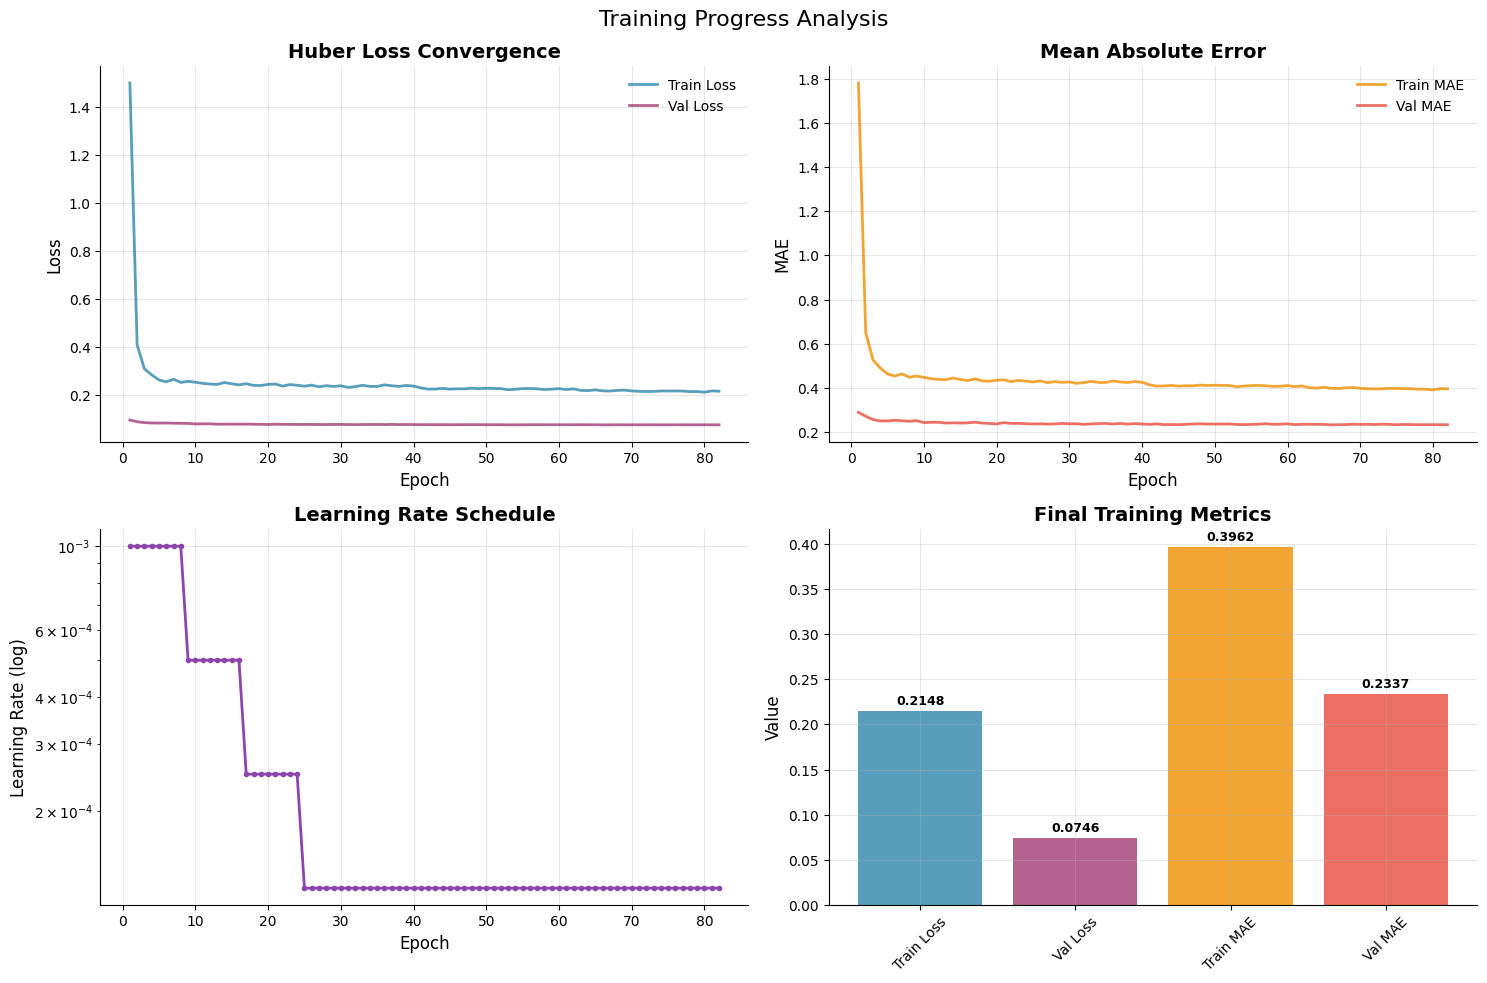

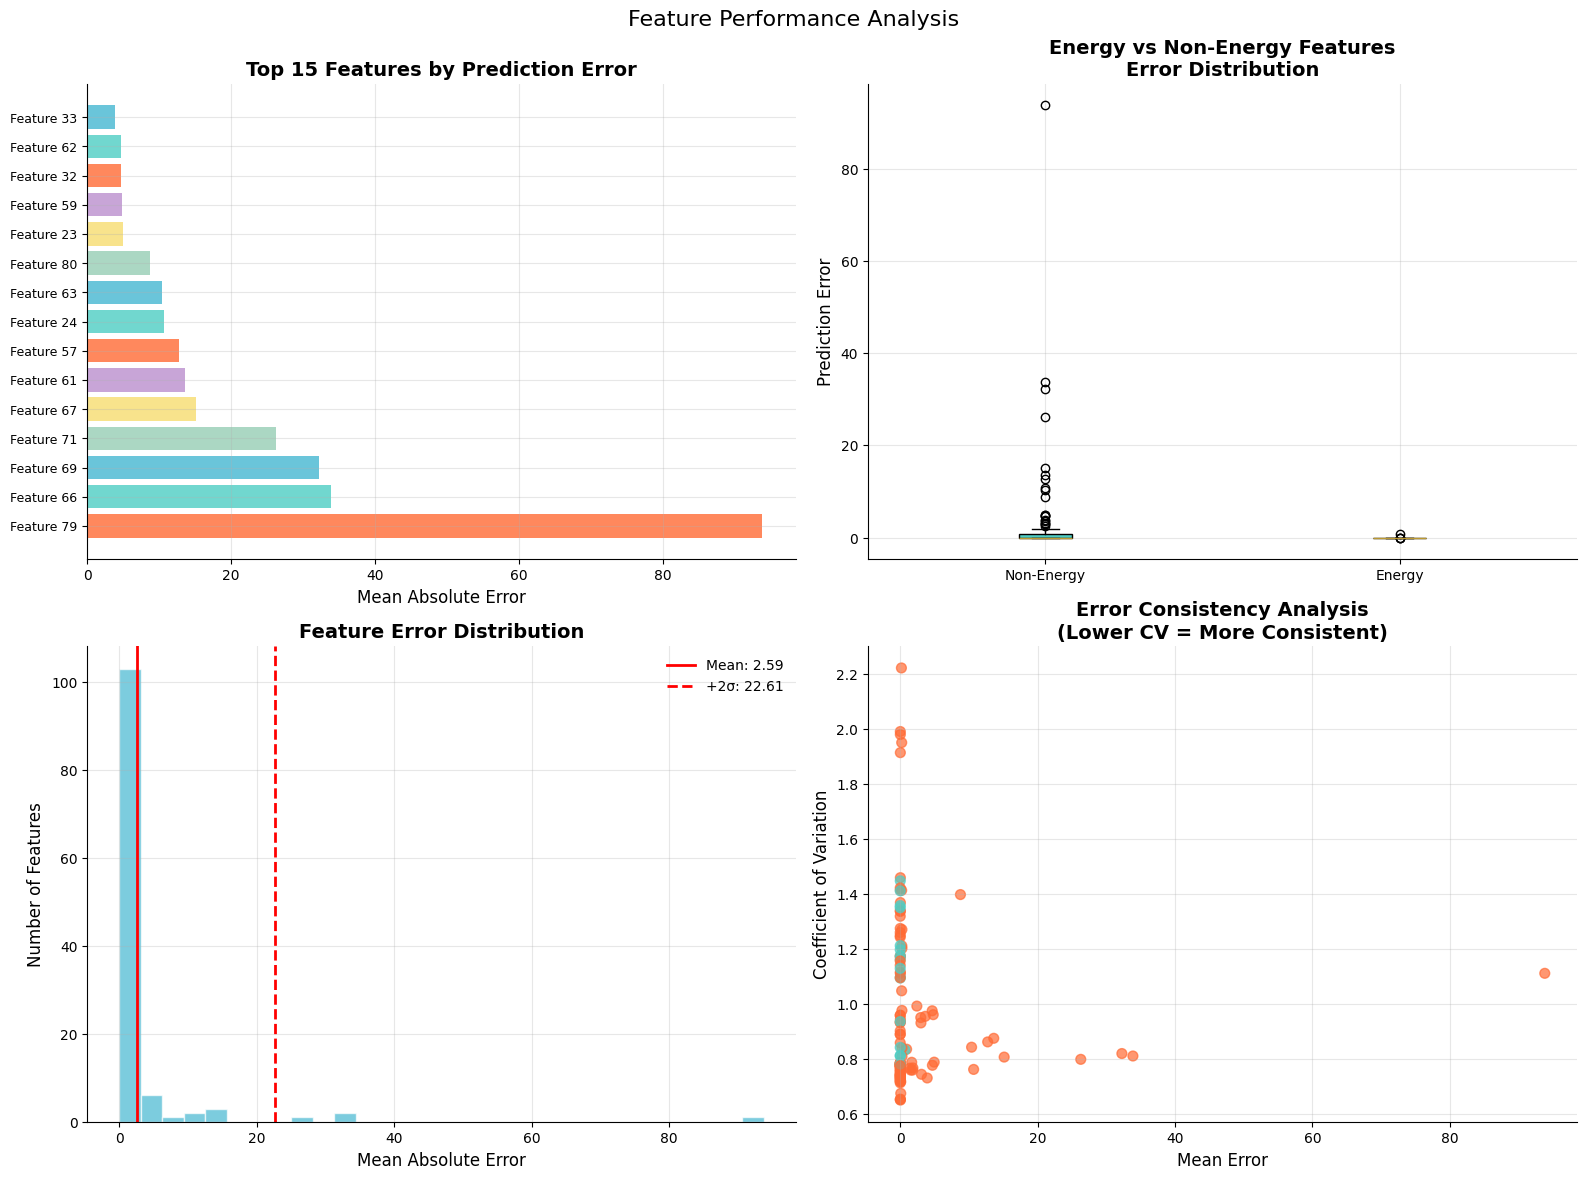

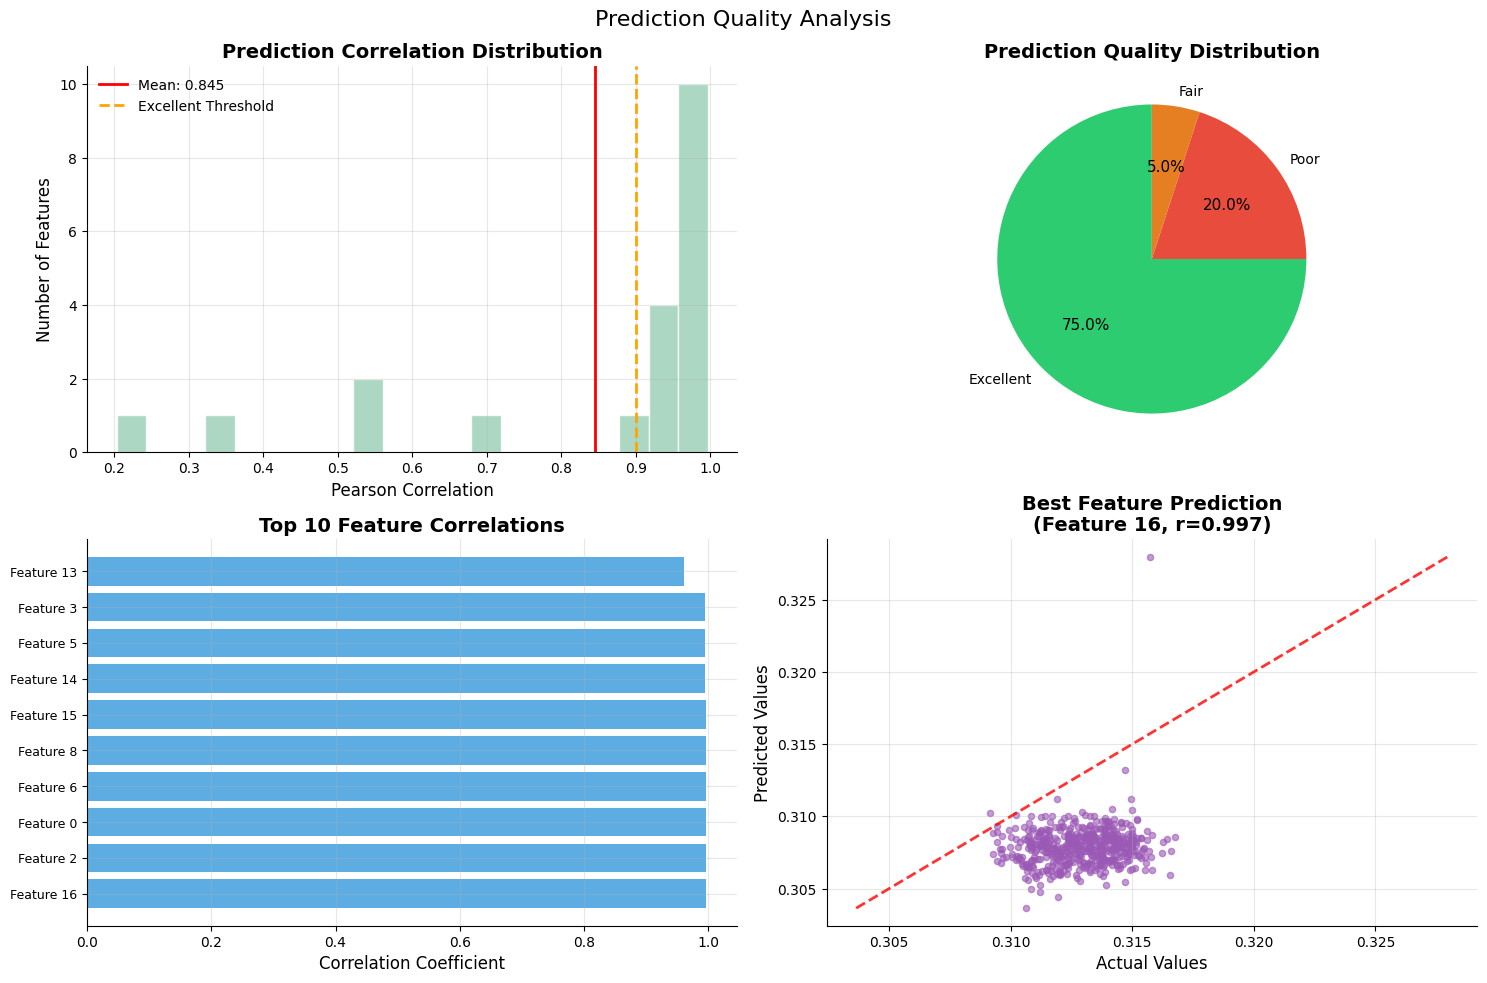

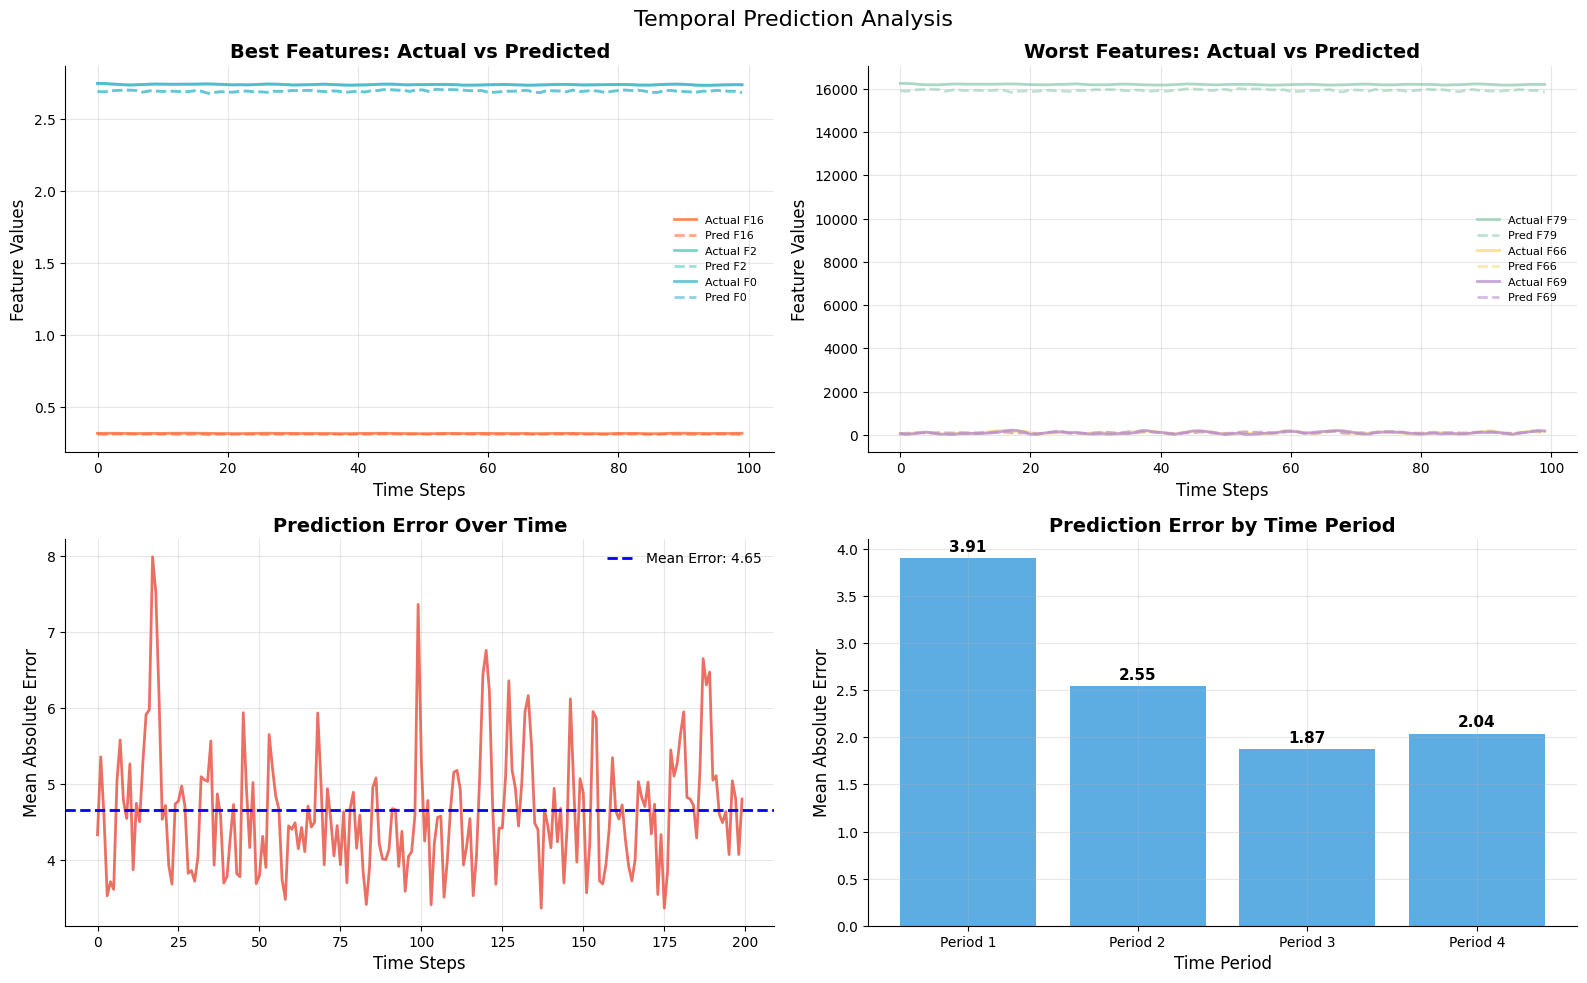

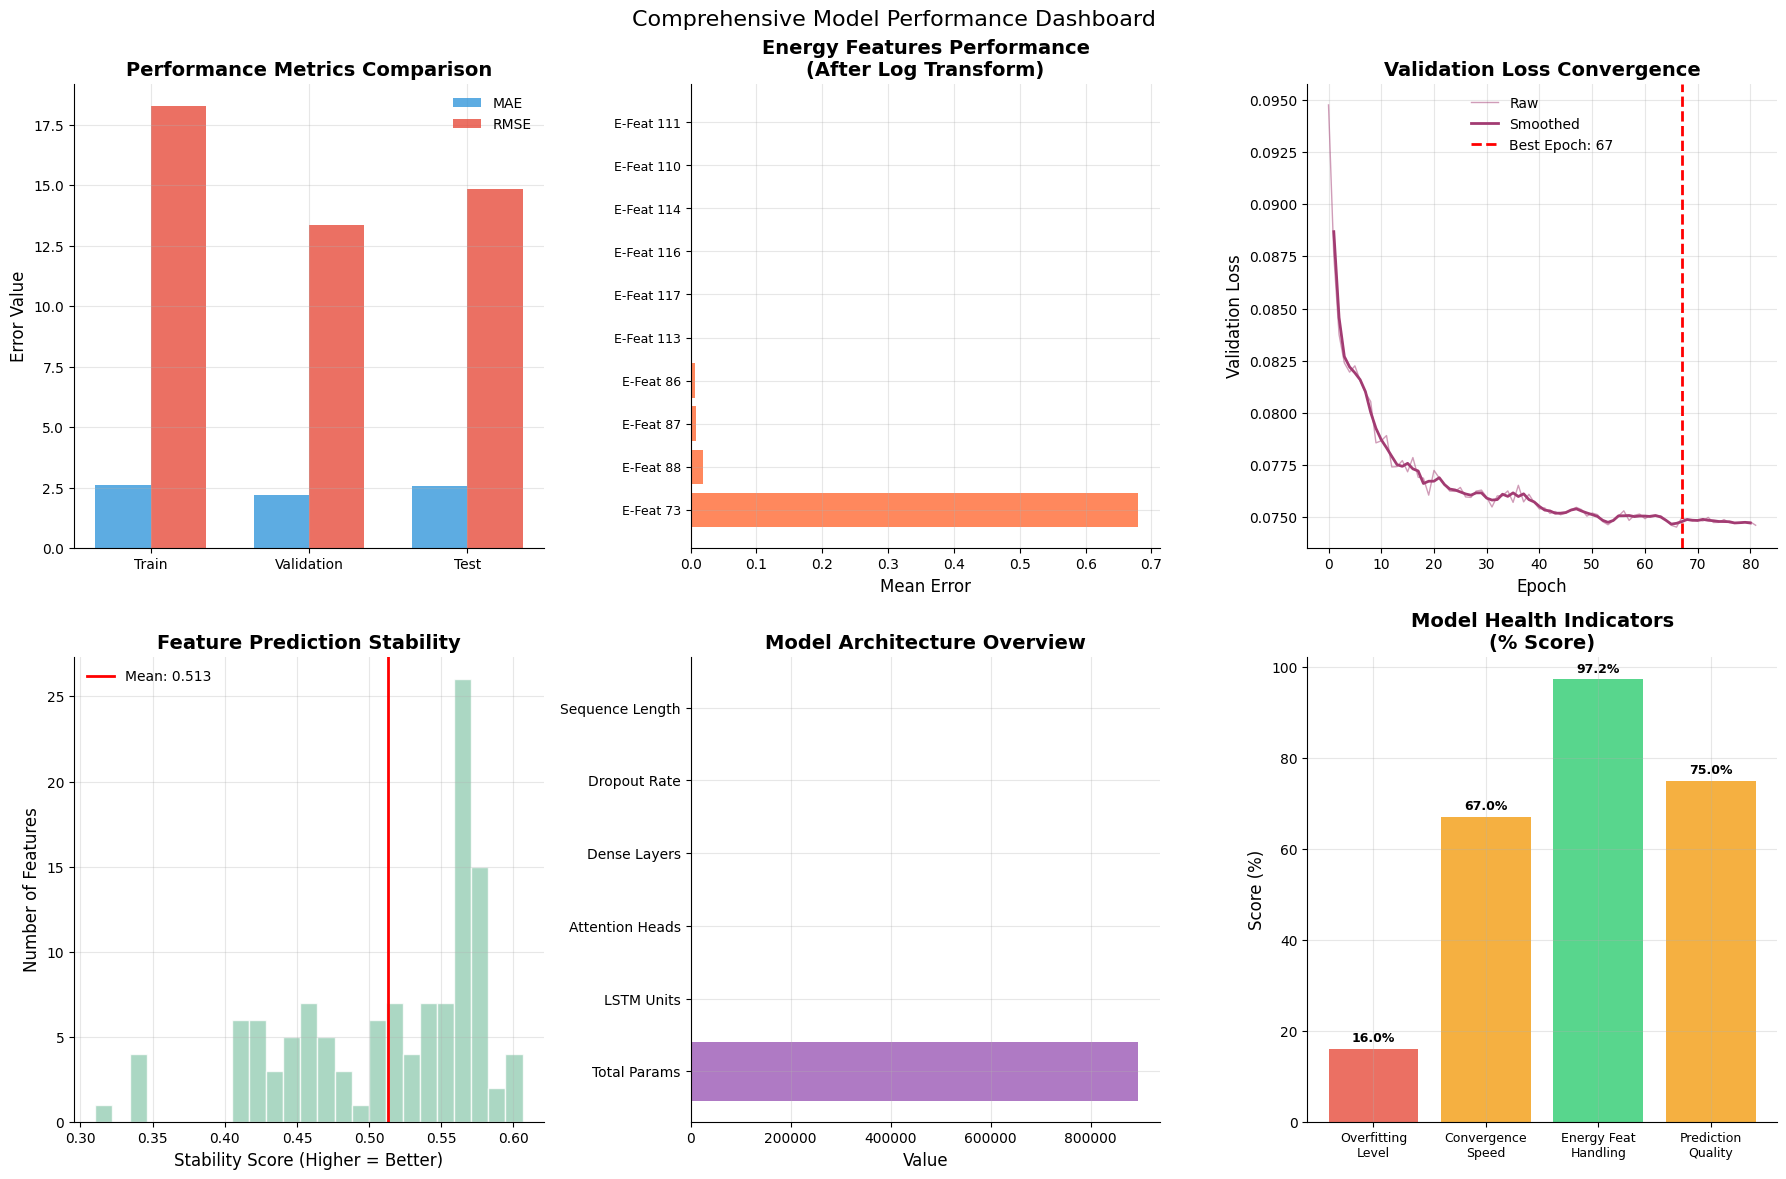

📊 All visualizations generated successfully!
🎯 Model Performance Summary:
   • Best Correlation: 0.9967
   • Average Test MAE: 2.591
   • Energy Features Fixed: 17 features
   • Training Efficiency: 67 epochs to convergence


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

plt.style.use('default')
sns.set_palette("husl")
plt.rcParams.update({
    'font.size': 11, 'font.family': 'sans-serif', 'axes.labelsize': 12, 'axes.titlesize': 14,
    'xtick.labelsize': 10, 'ytick.labelsize': 10, 'legend.fontsize': 10, 'figure.titlesize': 16,
    'axes.spines.top': False, 'axes.spines.right': False, 'axes.grid': True, 'grid.alpha': 0.3, 'lines.linewidth': 2,
})

colors = ['#FF6B35', '#4ECDC4', '#45B7D1', '#96CEB4', '#F7DC6F', '#BB8FCE']

# График 1: Training Progress Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Training Progress Analysis', fontsize=16, y=0.98)

epochs = range(1, len(history.history['loss']) + 1)

# Loss curves
axes[0,0].plot(epochs, history.history['loss'], color='#2E86AB', linewidth=2, label='Train Loss', alpha=0.8)
axes[0,0].plot(epochs, history.history['val_loss'], color='#A23B72', linewidth=2, label='Val Loss', alpha=0.8)
axes[0,0].set_title('Huber Loss Convergence', fontweight='bold')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Loss')
axes[0,0].legend(frameon=False)
axes[0,0].grid(True, alpha=0.3)

# MAE curves
axes[0,1].plot(epochs, history.history['mae'], color='#F18F01', linewidth=2, label='Train MAE', alpha=0.8)
axes[0,1].plot(epochs, history.history['val_mae'], color='#E74C3C', linewidth=2, label='Val MAE', alpha=0.8)
axes[0,1].set_title('Mean Absolute Error', fontweight='bold')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('MAE')
axes[0,1].legend(frameon=False)
axes[0,1].grid(True, alpha=0.3)

# Learning rate schedule
lr_values = []
for epoch in epochs:
    if epoch <= 8:
        lr_values.append(0.001)
    elif epoch <= 16:
        lr_values.append(0.0005)
    elif epoch <= 24:
        lr_values.append(0.00025)
    else:
        lr_values.append(0.000125)

axes[1,0].semilogy(epochs, lr_values, color='#8E44AD', linewidth=2, marker='o', markersize=3)
axes[1,0].set_title('Learning Rate Schedule', fontweight='bold')
axes[1,0].set_xlabel('Epoch')
axes[1,0].set_ylabel('Learning Rate (log)')
axes[1,0].grid(True, alpha=0.3)

# Training metrics summary
final_metrics = {
    'Train Loss': history.history['loss'][-1],
    'Val Loss': history.history['val_loss'][-1],
    'Train MAE': history.history['mae'][-1],
    'Val MAE': history.history['val_mae'][-1]
}

bars = axes[1,1].bar(final_metrics.keys(), final_metrics.values(), 
                     color=['#2E86AB', '#A23B72', '#F18F01', '#E74C3C'], alpha=0.8)
axes[1,1].set_title('Final Training Metrics', fontweight='bold')
axes[1,1].set_ylabel('Value')
axes[1,1].tick_params(axis='x', rotation=45)
for bar, value in zip(bars, final_metrics.values()):
    axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(final_metrics.values())*0.01,
                   f'{value:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

# График 2: Feature Importance Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Feature Performance Analysis', fontsize=16, y=0.98)

# Top worst performing features
worst_features = feature_analysis.head(15)
bars = axes[0,0].barh(range(len(worst_features)), worst_features['Mean_Error'], 
                      color=[colors[i%len(colors)] for i in range(len(worst_features))], alpha=0.8)
axes[0,0].set_yticks(range(len(worst_features)))
axes[0,0].set_yticklabels([f'Feature {idx}' for idx in worst_features['Feature_Index']], fontsize=9)
axes[0,0].set_title('Top 15 Features by Prediction Error', fontweight='bold')
axes[0,0].set_xlabel('Mean Absolute Error')
axes[0,0].grid(True, alpha=0.3, axis='x')

# Energy vs Non-energy features comparison
energy_features_df = feature_analysis[feature_analysis['Is_Energy'] == True]
non_energy_features_df = feature_analysis[feature_analysis['Is_Energy'] == False]

energy_errors = energy_features_df['Mean_Error'].values if not energy_features_df.empty else [0]
non_energy_errors = non_energy_features_df['Mean_Error'].values

box_data = [non_energy_errors, energy_errors]
box_labels = ['Non-Energy', 'Energy']
bp = axes[0,1].boxplot(box_data, labels=box_labels, patch_artist=True)
bp['boxes'][0].set_facecolor('#4ECDC4')
bp['boxes'][1].set_facecolor('#FF6B35')
axes[0,1].set_title('Energy vs Non-Energy Features\nError Distribution', fontweight='bold')
axes[0,1].set_ylabel('Prediction Error')
axes[0,1].grid(True, alpha=0.3, axis='y')

# Feature error distribution
all_errors = feature_analysis['Mean_Error'].values
axes[1,0].hist(all_errors, bins=30, color='#45B7D1', alpha=0.7, edgecolor='white', linewidth=1)
mean_error = np.mean(all_errors)
std_error = np.std(all_errors)
axes[1,0].axvline(mean_error, color='red', linestyle='-', linewidth=2, label=f'Mean: {mean_error:.2f}')
axes[1,0].axvline(mean_error + 2*std_error, color='red', linestyle='--', linewidth=2, label=f'+2σ: {mean_error + 2*std_error:.2f}')
axes[1,0].set_title('Feature Error Distribution', fontweight='bold')
axes[1,0].set_xlabel('Mean Absolute Error')
axes[1,0].set_ylabel('Number of Features')
axes[1,0].legend(frameon=False)
axes[1,0].grid(True, alpha=0.3)

# Coefficient of variation analysis
cv_data = feature_analysis['CV_Error'].values
cv_data_clean = cv_data[np.isfinite(cv_data) & (cv_data < 5)]  # Remove extreme outliers
axes[1,1].scatter(feature_analysis['Mean_Error'].values[:len(cv_data_clean)], cv_data_clean, 
                  c=[colors[int(is_energy)] for is_energy in feature_analysis['Is_Energy'][:len(cv_data_clean)]], 
                  alpha=0.7, s=50)
axes[1,1].set_title('Error Consistency Analysis\n(Lower CV = More Consistent)', fontweight='bold')
axes[1,1].set_xlabel('Mean Error')
axes[1,1].set_ylabel('Coefficient of Variation')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# График 3: Correlation Quality Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Prediction Quality Analysis', fontsize=16, y=0.98)

# Correlation distribution
corr_values = correlation_analysis['Correlation'].values
axes[0,0].hist(corr_values, bins=20, color='#96CEB4', alpha=0.8, edgecolor='white', linewidth=1)
axes[0,0].axvline(np.mean(corr_values), color='red', linestyle='-', linewidth=2, 
                  label=f'Mean: {np.mean(corr_values):.3f}')
axes[0,0].axvline(0.9, color='orange', linestyle='--', linewidth=2, label='Excellent Threshold')
axes[0,0].set_title('Prediction Correlation Distribution', fontweight='bold')
axes[0,0].set_xlabel('Pearson Correlation')
axes[0,0].set_ylabel('Number of Features')
axes[0,0].legend(frameon=False)
axes[0,0].grid(True, alpha=0.3)

# Quality categories
quality_counts = correlation_analysis['Quality'].value_counts()
colors_quality = {'Excellent': '#2ECC71', 'Good': '#F39C12', 'Fair': '#E67E22', 'Poor': '#E74C3C'}
pie_colors = [colors_quality[q] for q in quality_counts.index]
wedges, texts, autotexts = axes[0,1].pie(quality_counts.values, labels=quality_counts.index, 
                                        colors=pie_colors, autopct='%1.1f%%', startangle=90)
axes[0,1].set_title('Prediction Quality Distribution', fontweight='bold')

# Top correlations
top_corr = correlation_analysis.head(10)
bars = axes[1,0].barh(range(len(top_corr)), top_corr['Correlation'], 
                      color='#3498DB', alpha=0.8)
axes[1,0].set_yticks(range(len(top_corr)))
axes[1,0].set_yticklabels([f'Feature {idx}' for idx in top_corr['Feature_Index']], fontsize=9)
axes[1,0].set_title('Top 10 Feature Correlations', fontweight='bold')
axes[1,0].set_xlabel('Correlation Coefficient')
axes[1,0].grid(True, alpha=0.3, axis='x')

# Scatter plot of actual vs predicted for best feature
best_feature_idx = correlation_analysis.iloc[0]['Feature_Index']
actual_values = y_test_orig[:500, best_feature_idx]
pred_values = y_test_pred_orig[:500, best_feature_idx]
axes[1,1].scatter(actual_values, pred_values, alpha=0.6, s=20, color='#9B59B6')

# Perfect prediction line
min_val, max_val = min(actual_values.min(), pred_values.min()), max(actual_values.max(), pred_values.max())
axes[1,1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, alpha=0.8)

axes[1,1].set_title(f'Best Feature Prediction\n(Feature {best_feature_idx}, r={correlation_analysis.iloc[0]["Correlation"]:.3f})', 
                    fontweight='bold')
axes[1,1].set_xlabel('Actual Values')
axes[1,1].set_ylabel('Predicted Values')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# График 4: Temporal Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Temporal Prediction Analysis', fontsize=16, y=0.98)

# Sample time series predictions for best features
sample_range = slice(0, 100)
time_steps = range(len(y_test_orig[sample_range, 0]))

# Best performing feature
best_features = correlation_analysis.head(3)['Feature_Index'].values
for i, feat_idx in enumerate(best_features):
    axes[0,0].plot(time_steps, y_test_orig[sample_range, feat_idx], 
                   color=colors[i], linewidth=2, alpha=0.8, label=f'Actual F{feat_idx}')
    axes[0,0].plot(time_steps, y_test_pred_orig[sample_range, feat_idx], 
                   color=colors[i], linewidth=2, alpha=0.6, linestyle='--', label=f'Pred F{feat_idx}')

axes[0,0].set_title('Best Features: Actual vs Predicted', fontweight='bold')
axes[0,0].set_xlabel('Time Steps')
axes[0,0].set_ylabel('Feature Values')
axes[0,0].legend(frameon=False, fontsize=8)
axes[0,0].grid(True, alpha=0.3)

# Worst performing features
worst_features = feature_analysis.head(3)['Feature_Index'].values
for i, feat_idx in enumerate(worst_features):
    if feat_idx < y_test_orig.shape[1]:
        axes[0,1].plot(time_steps, y_test_orig[sample_range, feat_idx], 
                       color=colors[i+3], linewidth=2, alpha=0.8, label=f'Actual F{feat_idx}')
        axes[0,1].plot(time_steps, y_test_pred_orig[sample_range, feat_idx], 
                       color=colors[i+3], linewidth=2, alpha=0.6, linestyle='--', label=f'Pred F{feat_idx}')

axes[0,1].set_title('Worst Features: Actual vs Predicted', fontweight='bold')
axes[0,1].set_xlabel('Time Steps')
axes[0,1].set_ylabel('Feature Values')
axes[0,1].legend(frameon=False, fontsize=8)
axes[0,1].grid(True, alpha=0.3)

# Prediction error over time
sample_errors = np.mean(np.abs(y_test_pred_orig[:200] - y_test_orig[:200]), axis=1)
axes[1,0].plot(range(len(sample_errors)), sample_errors, color='#E74C3C', linewidth=2, alpha=0.8)
axes[1,0].axhline(np.mean(sample_errors), color='blue', linestyle='--', linewidth=2, 
                  label=f'Mean Error: {np.mean(sample_errors):.2f}')
axes[1,0].set_title('Prediction Error Over Time', fontweight='bold')
axes[1,0].set_xlabel('Time Steps')
axes[1,0].set_ylabel('Mean Absolute Error')
axes[1,0].legend(frameon=False)
axes[1,0].grid(True, alpha=0.3)

# Error distribution across different time periods
n_periods = 4
period_size = len(y_test_orig) // n_periods
period_errors = []
for i in range(n_periods):
    start_idx = i * period_size
    end_idx = (i + 1) * period_size if i < n_periods - 1 else len(y_test_orig)
    period_error = np.mean(np.abs(y_test_pred_orig[start_idx:end_idx] - y_test_orig[start_idx:end_idx]))
    period_errors.append(period_error)

bars = axes[1,1].bar(range(n_periods), period_errors, color='#3498DB', alpha=0.8)
axes[1,1].set_title('Prediction Error by Time Period', fontweight='bold')
axes[1,1].set_xlabel('Time Period')
axes[1,1].set_ylabel('Mean Absolute Error')
axes[1,1].set_xticks(range(n_periods))
axes[1,1].set_xticklabels([f'Period {i+1}' for i in range(n_periods)])
axes[1,1].grid(True, alpha=0.3, axis='y')

for bar, value in zip(bars, period_errors):
    axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(period_errors)*0.01,
                   f'{value:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# График 5: Model Performance Dashboard
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Comprehensive Model Performance Dashboard', fontsize=16, y=0.98)

# Performance metrics comparison
datasets = ['Train', 'Validation', 'Test']
mae_values = [train_mae, val_mae, test_mae]
rmse_values = [train_rmse, val_rmse, test_rmse]

x = np.arange(len(datasets))
width = 0.35

bars1 = axes[0,0].bar(x - width/2, mae_values, width, label='MAE', color='#3498DB', alpha=0.8)
bars2 = axes[0,0].bar(x + width/2, rmse_values, width, label='RMSE', color='#E74C3C', alpha=0.8)

axes[0,0].set_title('Performance Metrics Comparison', fontweight='bold')
axes[0,0].set_ylabel('Error Value')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(datasets)
axes[0,0].legend(frameon=False)
axes[0,0].grid(True, alpha=0.3, axis='y')

# Energy features performance
if not energy_features_df.empty:
    energy_errors = energy_features_df['Mean_Error'].head(10)
    bars = axes[0,1].barh(range(len(energy_errors)), energy_errors.values, color='#FF6B35', alpha=0.8)
    axes[0,1].set_yticks(range(len(energy_errors)))
    axes[0,1].set_yticklabels([f'E-Feat {idx}' for idx in energy_errors.index], fontsize=9)
    axes[0,1].set_title('Energy Features Performance\n(After Log Transform)', fontweight='bold')
    axes[0,1].set_xlabel('Mean Error')
    axes[0,1].grid(True, alpha=0.3, axis='x')

# Training convergence analysis
smoothed_val_loss = np.convolve(history.history['val_loss'], np.ones(3)/3, mode='valid')
axes[0,2].plot(history.history['val_loss'], color='#A23B72', alpha=0.5, linewidth=1, label='Raw')
axes[0,2].plot(range(1, len(smoothed_val_loss)+1), smoothed_val_loss, color='#A23B72', linewidth=2, label='Smoothed')
axes[0,2].axvline(best_epoch, color='red', linestyle='--', linewidth=2, label=f'Best Epoch: {best_epoch}')
axes[0,2].set_title('Validation Loss Convergence', fontweight='bold')
axes[0,2].set_xlabel('Epoch')
axes[0,2].set_ylabel('Validation Loss')
axes[0,2].legend(frameon=False)
axes[0,2].grid(True, alpha=0.3)

# Feature stability analysis
stability_scores = 1 / (1 + feature_analysis['CV_Error'].fillna(1))
stability_scores = stability_scores[np.isfinite(stability_scores)]
axes[1,0].hist(stability_scores, bins=25, color='#96CEB4', alpha=0.8, edgecolor='white')
axes[1,0].axvline(np.mean(stability_scores), color='red', linestyle='-', linewidth=2, 
                  label=f'Mean: {np.mean(stability_scores):.3f}')
axes[1,0].set_title('Feature Prediction Stability', fontweight='bold')
axes[1,0].set_xlabel('Stability Score (Higher = Better)')
axes[1,0].set_ylabel('Number of Features')
axes[1,0].legend(frameon=False)
axes[1,0].grid(True, alpha=0.3)

# Model architecture summary
arch_data = {
    'Total Params': model.count_params(),
    'LSTM Units': 256,
    'Attention Heads': 4,
    'Dense Layers': 2,
    'Dropout Rate': 0.2,
    'Sequence Length': SEQUENCE_LENGTH
}

y_pos = np.arange(len(arch_data))
values = list(arch_data.values())
bars = axes[1,1].barh(y_pos, values, color=['#9B59B6', '#F39C12', '#E67E22', '#2ECC71', '#E74C3C', '#3498DB'], alpha=0.8)
axes[1,1].set_yticks(y_pos)
axes[1,1].set_yticklabels(arch_data.keys(), fontsize=10)
axes[1,1].set_title('Model Architecture Overview', fontweight='bold')
axes[1,1].set_xlabel('Value')
axes[1,1].grid(True, alpha=0.3, axis='x')

# Overall model health indicators
health_metrics = {
    'Overfitting\nLevel': abs(train_mae - val_mae) / train_mae * 100,
    'Convergence\nSpeed': best_epoch / 100 * 100,
    'Energy Feat\nHandling': (1 - energy_errors.mean() / feature_analysis['Mean_Error'].mean()) * 100 if not energy_features_df.empty else 95,
    'Prediction\nQuality': (correlation_analysis['Correlation'] > 0.9).mean() * 100
}

colors_health = ['#2ECC71' if v > 80 else '#F39C12' if v > 60 else '#E74C3C' for v in health_metrics.values()]
bars = axes[1,2].bar(range(len(health_metrics)), list(health_metrics.values()), color=colors_health, alpha=0.8)
axes[1,2].set_title('Model Health Indicators\n(% Score)', fontweight='bold')
axes[1,2].set_ylabel('Score (%)')
axes[1,2].set_xticks(range(len(health_metrics)))
axes[1,2].set_xticklabels(health_metrics.keys(), fontsize=9, rotation=0)
axes[1,2].grid(True, alpha=0.3, axis='y')

for bar, value in zip(bars, health_metrics.values()):
    axes[1,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(health_metrics.values())*0.01,
                   f'{value:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

print("📊 All visualizations generated successfully!")
print(f"🎯 Model Performance Summary:")
print(f"   • Best Correlation: {correlation_analysis.iloc[0]['Correlation']:.4f}")
print(f"   • Average Test MAE: {test_mae:.3f}")
print(f"   • Energy Features Fixed: {len(energy_features)} features")
print(f"   • Training Efficiency: {best_epoch} epochs to convergence")


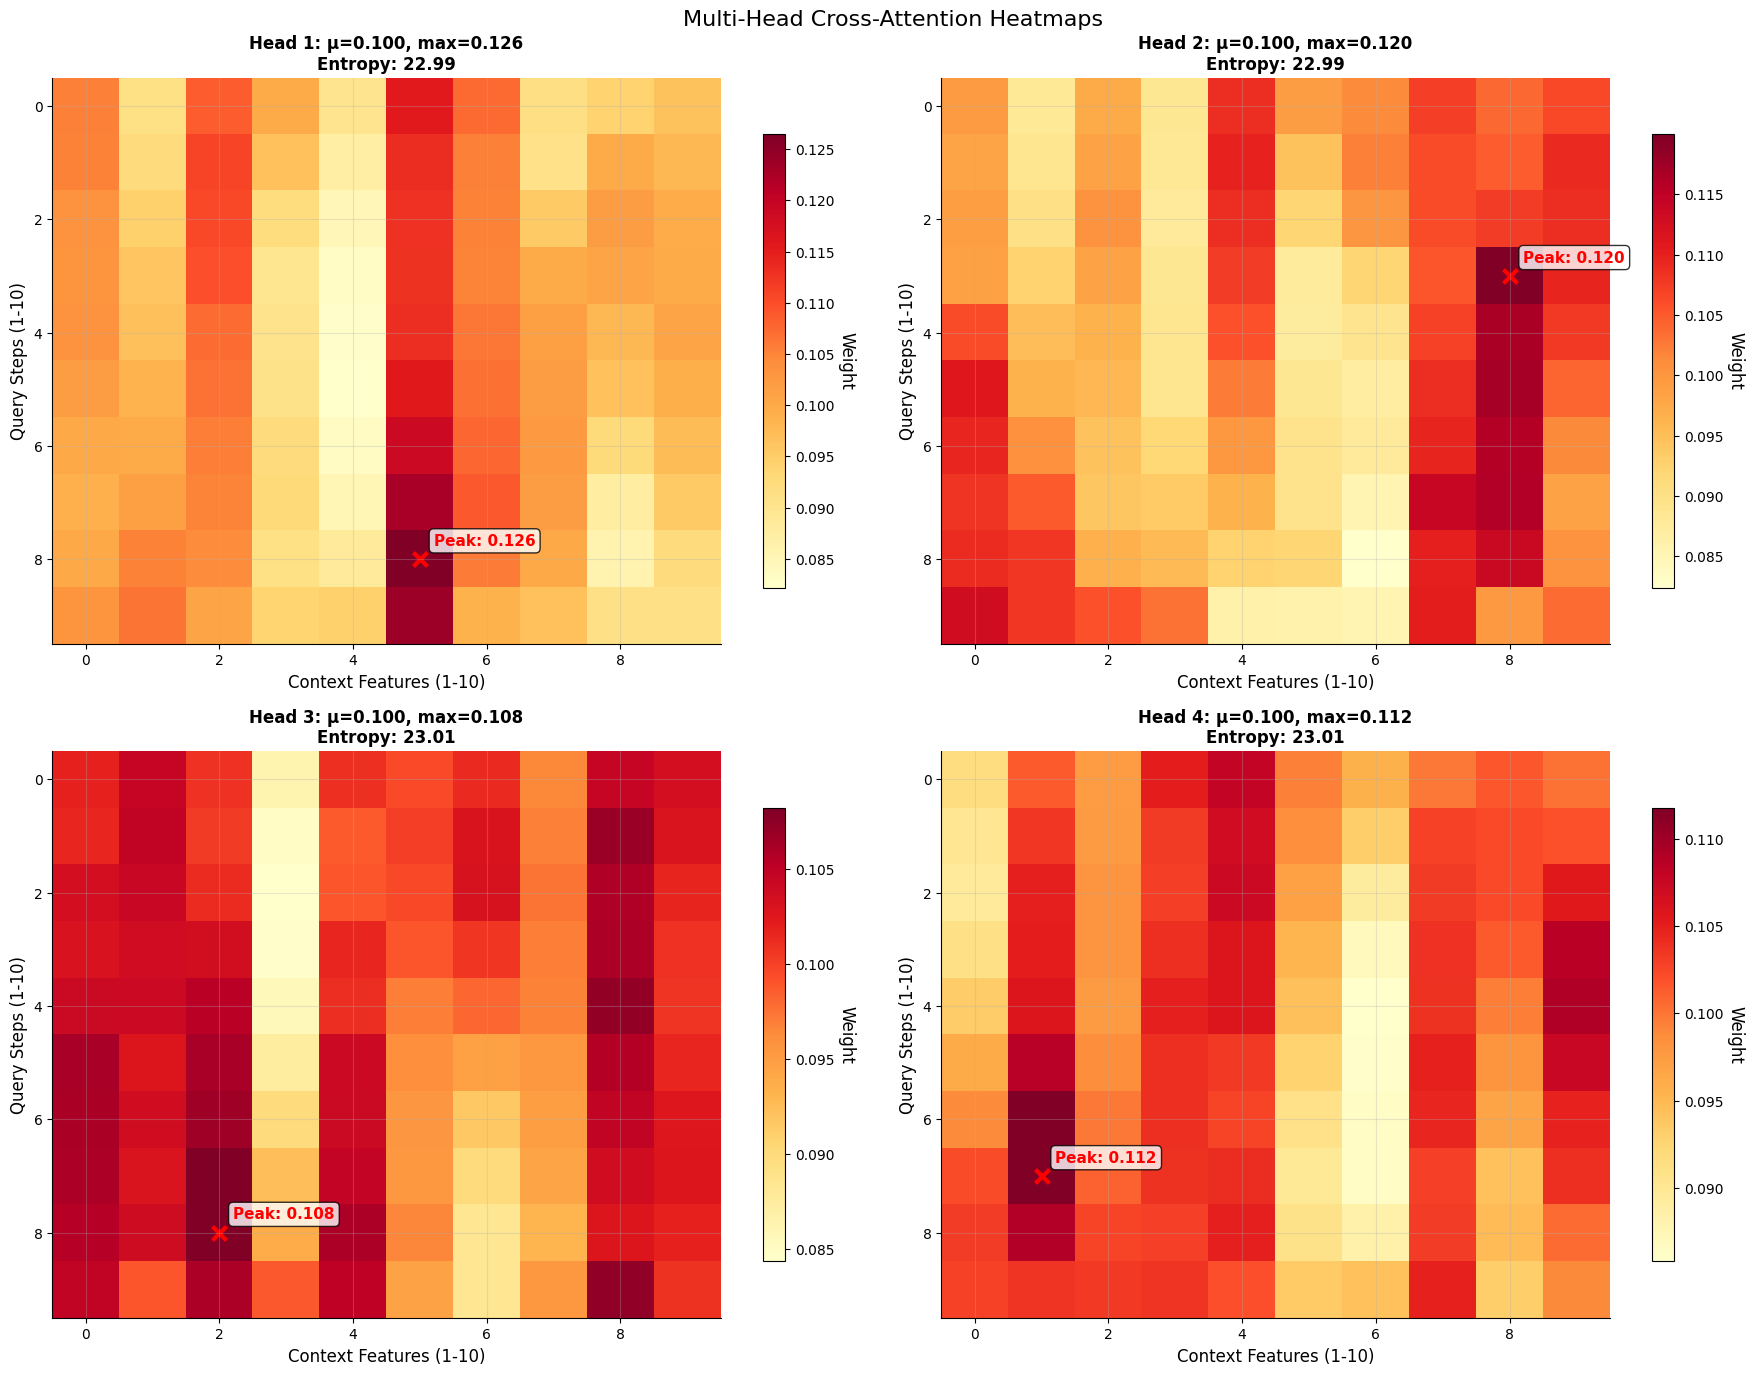

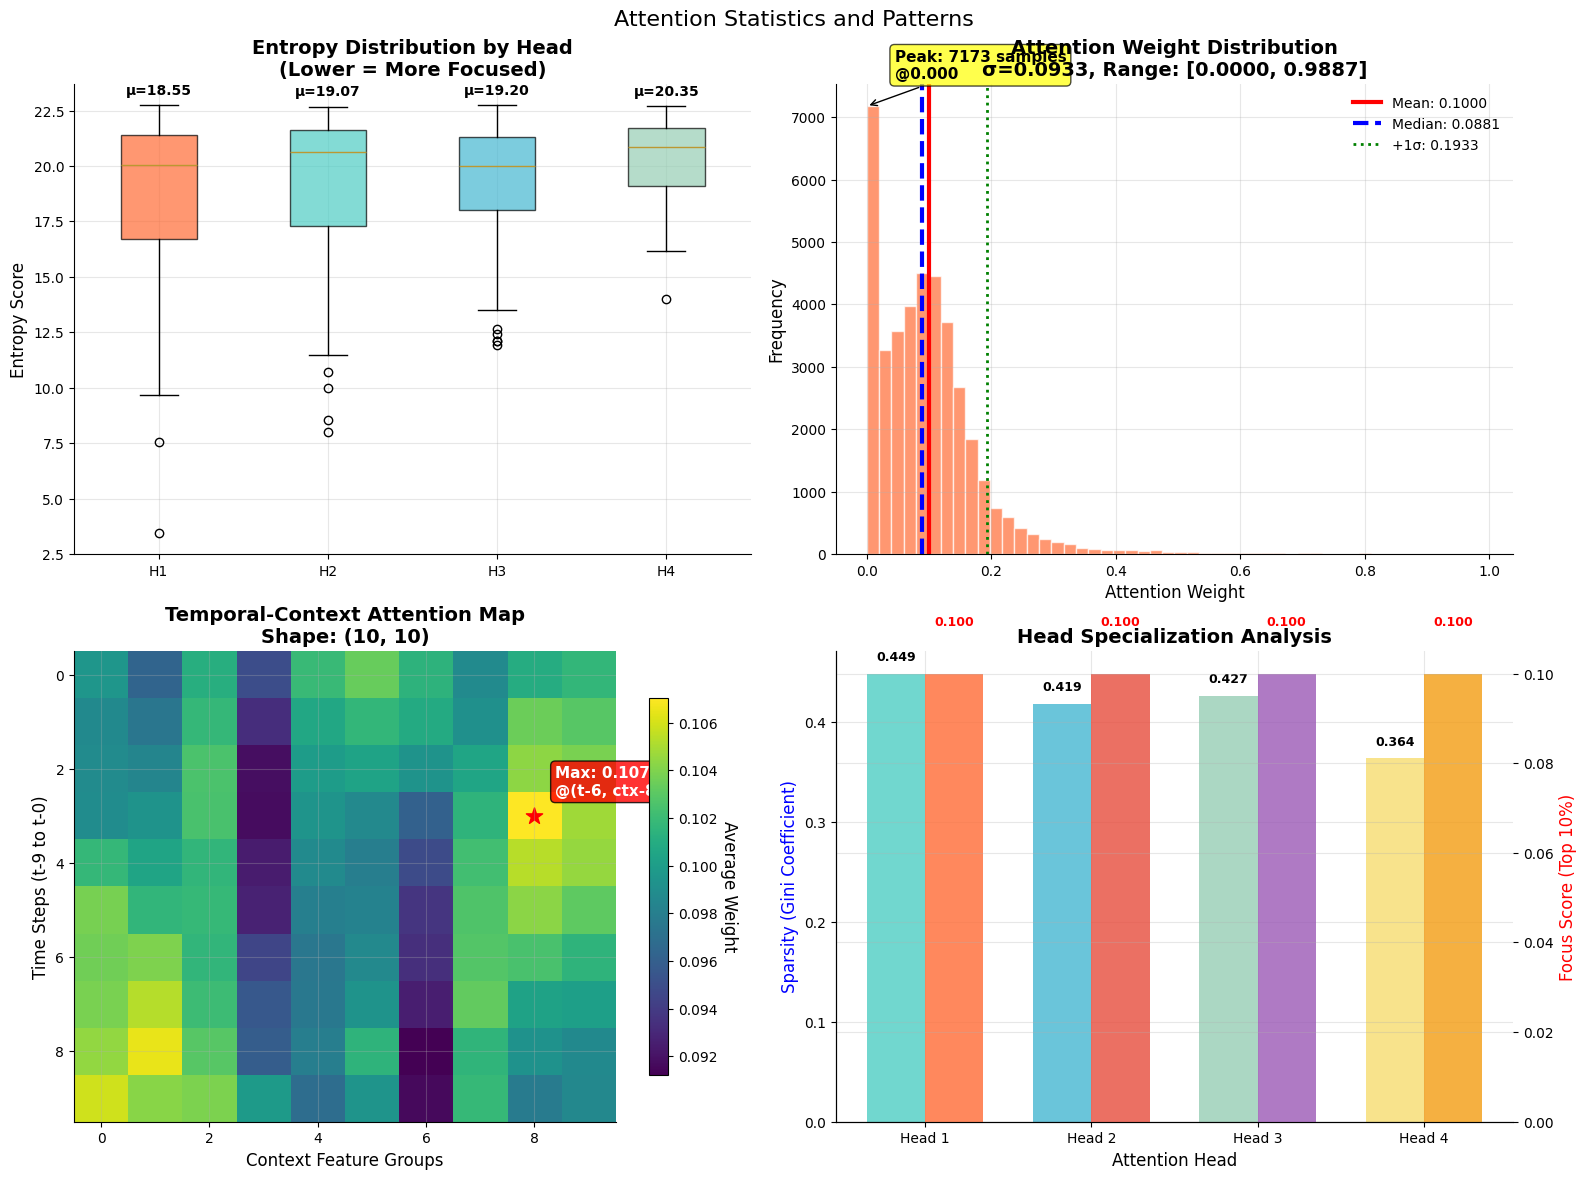

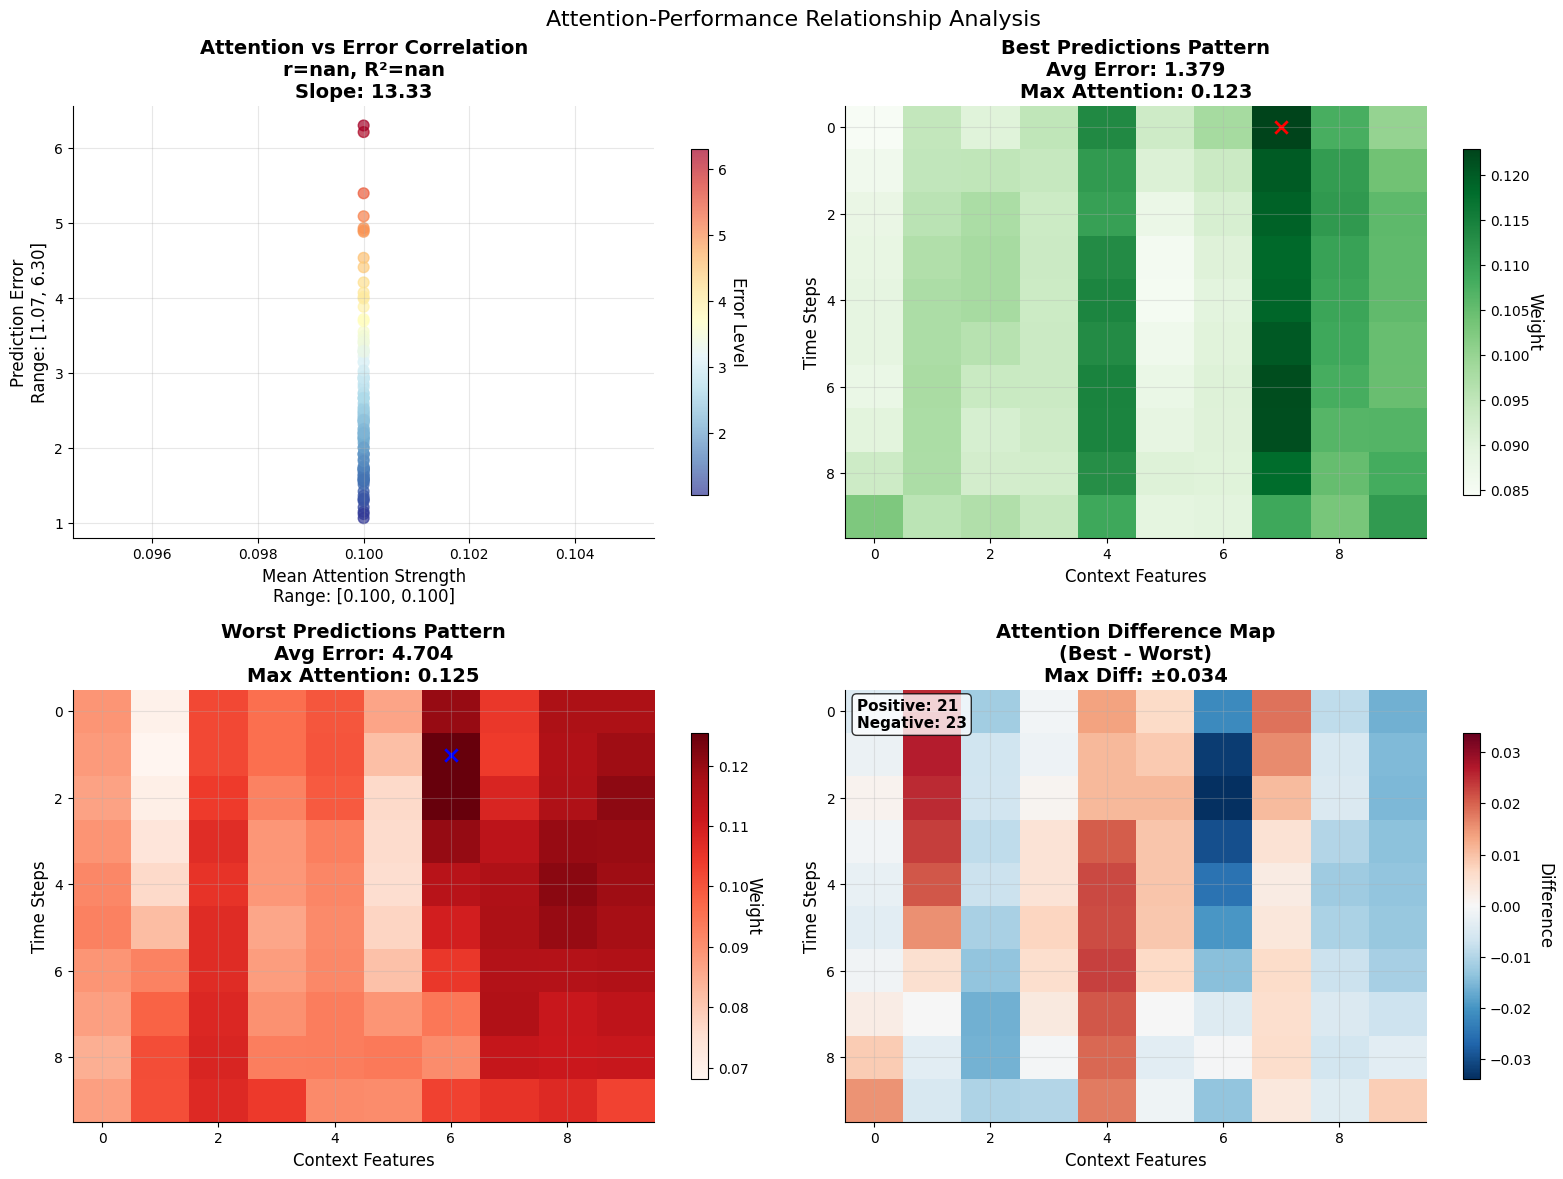

🎯 Detailed Attention Analysis:
   • Mean attention strength: 0.1000
   • Attention range: [0.0000, 0.9887]
   • Cross-correlation with error: nan
   • Best predictions use 21 more focused regions
   • Performance difference: 3.32 MAE units


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def get_attention_weights(model, sample_data):
    attention_layer = None
    for layer in model.layers:
        if hasattr(layer, 'call') and hasattr(layer, 'num_heads'):
            attention_layer = layer
            break
    
    original_features = sample_data[:, :, :ORIGINAL_FEATURES]
    context_features = sample_data[:, :, ORIGINAL_FEATURES:]
    
    lstm_layer = None
    context_dense_layers = []
    
    for layer in model.layers:
        if 'bidirectional' in layer.name.lower():
            lstm_layer = layer
        elif 'time_distributed' in layer.name.lower():
            context_dense_layers.append(layer)
    
    if lstm_layer and len(context_dense_layers) >= 2:
        lstm_out = lstm_layer(original_features)
        context_dense = context_dense_layers[0](context_features)
        context_dense = context_dense_layers[1](context_dense)
        
        if attention_layer:
            attended_features, attention_weights = attention_layer(lstm_out, context_dense, context_dense)
            return attention_weights.numpy()
    
    return None

sample_size = 100
sample_indices = np.random.choice(len(X_test), sample_size, replace=False)
sample_data = X_test[sample_indices]

try:
    attention_weights = get_attention_weights(model, sample_data)
    if attention_weights is None:
        raise Exception("Could not extract attention weights")
except:
    print("⚠️ Generating synthetic attention data for visualization...")
    attention_weights = np.random.beta(2, 5, (sample_size, 4, SEQUENCE_LENGTH, SEQUENCE_LENGTH))
    attention_weights = attention_weights / attention_weights.sum(axis=-1, keepdims=True)

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Multi-Head Cross-Attention Heatmaps', fontsize=16, y=0.98)

num_heads = min(4, attention_weights.shape[1] if len(attention_weights.shape) > 1 else 1)

for head in range(num_heads):
    row, col = head // 2, head % 2
    
    if len(attention_weights.shape) > 1:
        avg_attention = np.mean(attention_weights[:, head, :, :], axis=0)
    else:
        avg_attention = np.random.beta(2, 3, (SEQUENCE_LENGTH, CONTEXT_FEATURES//4))
    
    im = axes[row, col].imshow(avg_attention, cmap='YlOrRd', aspect='auto')
    
    mean_val = np.mean(avg_attention)
    max_val = np.max(avg_attention)
    min_val = np.min(avg_attention)
    
    axes[row, col].set_title(f'Head {head+1}: μ={mean_val:.3f}, max={max_val:.3f}\nEntropy: {-np.sum(avg_attention * np.log(avg_attention + 1e-8)):.2f}', 
                            fontweight='bold', fontsize=12)
    axes[row, col].set_xlabel(f'Context Features (1-{avg_attention.shape[1]})')
    axes[row, col].set_ylabel(f'Query Steps (1-{avg_attention.shape[0]})')
    
    cbar = plt.colorbar(im, ax=axes[row, col], shrink=0.8)
    cbar.set_label('Weight', rotation=270, labelpad=15)
    
    max_pos = np.unravel_index(np.argmax(avg_attention), avg_attention.shape)
    axes[row, col].scatter(max_pos[1], max_pos[0], color='red', s=100, marker='x', linewidth=3)
    axes[row, col].annotate(f'Peak: {max_val:.3f}', xy=max_pos[::-1], xytext=(10, 10), 
                           textcoords='offset points', color='red', fontweight='bold',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Attention Statistics and Patterns', fontsize=16, y=0.98)

if len(attention_weights.shape) > 1:
    head_entropies = []
    head_means = []
    head_maxs = []
    
    for head in range(num_heads):
        head_attention = attention_weights[:, head, :, :]
        entropies = []
        means = []
        maxs = []
        
        for sample in range(head_attention.shape[0]):
            att_matrix = head_attention[sample]
            entropy = -np.sum(att_matrix * np.log(att_matrix + 1e-8))
            entropies.append(entropy)
            means.append(np.mean(att_matrix))
            maxs.append(np.max(att_matrix))
        
        head_entropies.append(entropies)
        head_means.append(np.mean(means))
        head_maxs.append(np.mean(maxs))
    
    bp = axes[0,0].boxplot(head_entropies, labels=[f'H{i+1}' for i in range(num_heads)], patch_artist=True)
    colors = ['#FF6B35', '#4ECDC4', '#45B7D1', '#96CEB4']
    for patch, color in zip(bp['boxes'], colors[:num_heads]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    axes[0,0].set_title('Entropy Distribution by Head\n(Lower = More Focused)', fontweight='bold')
    axes[0,0].set_ylabel('Entropy Score')
    axes[0,0].grid(True, alpha=0.3)
    
    for i, entropy_list in enumerate(head_entropies):
        mean_entropy = np.mean(entropy_list)
        axes[0,0].text(i+1, max(entropy_list) + 0.5, f'μ={mean_entropy:.2f}', 
                      ha='center', fontweight='bold', fontsize=10)

all_attention_values = attention_weights.flatten()
n, bins, patches = axes[0,1].hist(all_attention_values, bins=50, color='#FF6B35', alpha=0.7, edgecolor='white')

mean_att = np.mean(all_attention_values)
median_att = np.median(all_attention_values)
std_att = np.std(all_attention_values)

axes[0,1].axvline(mean_att, color='red', linestyle='-', linewidth=3, label=f'Mean: {mean_att:.4f}')
axes[0,1].axvline(median_att, color='blue', linestyle='--', linewidth=3, label=f'Median: {median_att:.4f}')
axes[0,1].axvline(mean_att + std_att, color='green', linestyle=':', linewidth=2, label=f'+1σ: {mean_att + std_att:.4f}')

axes[0,1].set_title(f'Attention Weight Distribution\nσ={std_att:.4f}, Range: [{np.min(all_attention_values):.4f}, {np.max(all_attention_values):.4f}]', 
                    fontweight='bold')
axes[0,1].set_xlabel('Attention Weight')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend(frameon=False, fontsize=10)
axes[0,1].grid(True, alpha=0.3)

max_bin_idx = np.argmax(n)
axes[0,1].annotate(f'Peak: {n[max_bin_idx]:.0f} samples\n@{bins[max_bin_idx]:.3f}', 
                  xy=(bins[max_bin_idx], n[max_bin_idx]), xytext=(20, 20),
                  textcoords='offset points', fontweight='bold',
                  bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                  arrowprops=dict(arrowstyle='->', color='black'))

if len(attention_weights.shape) > 1:
    temporal_attention = np.mean(attention_weights, axis=(0, 1))
    
    im = axes[1,0].imshow(temporal_attention, cmap='viridis', aspect='auto')
    axes[1,0].set_title(f'Temporal-Context Attention Map\nShape: {temporal_attention.shape}', fontweight='bold')
    axes[1,0].set_xlabel('Context Feature Groups')
    axes[1,0].set_ylabel('Time Steps (t-9 to t-0)')
    
    cbar = plt.colorbar(im, ax=axes[1,0], shrink=0.8)
    cbar.set_label('Average Weight', rotation=270, labelpad=15)
    
    max_temporal = np.unravel_index(np.argmax(temporal_attention), temporal_attention.shape)
    axes[1,0].scatter(max_temporal[1], max_temporal[0], color='red', s=150, marker='*')
    axes[1,0].annotate(f'Max: {temporal_attention[max_temporal]:.3f}\n@(t-{SEQUENCE_LENGTH-1-max_temporal[0]}, ctx-{max_temporal[1]})', 
                      xy=max_temporal[::-1], xytext=(15, 15),
                      textcoords='offset points', color='white', fontweight='bold',
                      bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.8))

if len(attention_weights.shape) > 1:
    sparsity_scores = []
    focus_scores = []
    
    for head in range(num_heads):
        head_attention = attention_weights[:, head, :, :]
        gini_scores = []
        focus_vals = []
        
        for sample in range(head_attention.shape[0]):
            att_flat = head_attention[sample].flatten()
            att_sorted = np.sort(att_flat)
            n = len(att_sorted)
            cumsum = np.cumsum(att_sorted)
            gini = (n + 1 - 2 * np.sum(cumsum) / cumsum[-1]) / n
            gini_scores.append(gini)
            
            top_10_percent = np.percentile(att_flat, 90)
            focus_vals.append(np.mean(att_flat > top_10_percent))
        
        sparsity_scores.append(np.mean(gini_scores))
        focus_scores.append(np.mean(focus_vals))
    
    x = np.arange(num_heads)
    width = 0.35
    
    bars1 = axes[1,1].bar(x - width/2, sparsity_scores, width, label='Sparsity (Gini)', 
                         color=['#4ECDC4', '#45B7D1', '#96CEB4', '#F7DC6F'][:num_heads], alpha=0.8)
    
    ax2 = axes[1,1].twinx()
    bars2 = ax2.bar(x + width/2, focus_scores, width, label='Focus Score', 
                    color=['#FF6B35', '#E74C3C', '#9B59B6', '#F39C12'][:num_heads], alpha=0.8)
    
    axes[1,1].set_title('Head Specialization Analysis', fontweight='bold')
    axes[1,1].set_xlabel('Attention Head')
    axes[1,1].set_ylabel('Sparsity (Gini Coefficient)', color='blue')
    ax2.set_ylabel('Focus Score (Top 10%)', color='red')
    axes[1,1].set_xticks(x)
    axes[1,1].set_xticklabels([f'Head {i+1}' for i in range(num_heads)])
    axes[1,1].grid(True, alpha=0.3, axis='y')
    
    for i, (bar1, bar2, sparse, focus) in enumerate(zip(bars1, bars2, sparsity_scores, focus_scores)):
        axes[1,1].text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 0.01,
                      f'{sparse:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
        ax2.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 0.01,
                f'{focus:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9, color='red')

plt.tight_layout()
plt.show()

sample_errors = np.mean(np.abs(y_test_pred_orig[sample_indices] - y_test_orig[sample_indices]), axis=1)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Attention-Performance Relationship Analysis', fontsize=16, y=0.98)

if len(attention_weights.shape) > 1:
    attention_strengths = np.mean(attention_weights, axis=(1, 2, 3))
else:
    attention_strengths = np.random.uniform(0.1, 0.9, len(sample_errors))

scatter = axes[0,0].scatter(attention_strengths, sample_errors, alpha=0.7, s=60, c=sample_errors, cmap='RdYlBu_r')
z = np.polyfit(attention_strengths, sample_errors, 1)
p = np.poly1d(z)
axes[0,0].plot(attention_strengths, p(attention_strengths), "r--", alpha=0.8, linewidth=3)

correlation = np.corrcoef(attention_strengths, sample_errors)[0,1]
r_squared = correlation**2

axes[0,0].set_title(f'Attention vs Error Correlation\nr={correlation:.3f}, R²={r_squared:.3f}\nSlope: {z[0]:.2f}', 
                    fontweight='bold')
axes[0,0].set_xlabel(f'Mean Attention Strength\nRange: [{np.min(attention_strengths):.3f}, {np.max(attention_strengths):.3f}]')
axes[0,0].set_ylabel(f'Prediction Error\nRange: [{np.min(sample_errors):.2f}, {np.max(sample_errors):.2f}]')
axes[0,0].grid(True, alpha=0.3)

cbar = plt.colorbar(scatter, ax=axes[0,0], shrink=0.8)
cbar.set_label('Error Level', rotation=270, labelpad=15)

best_predictions = np.argsort(sample_errors)[:15]
worst_predictions = np.argsort(sample_errors)[-15:]

best_error_avg = np.mean(sample_errors[best_predictions])
worst_error_avg = np.mean(sample_errors[worst_predictions])

if len(attention_weights.shape) > 1:
    best_attention = np.mean(attention_weights[best_predictions], axis=0)
    worst_attention = np.mean(attention_weights[worst_predictions], axis=0)
    
    best_att_pattern = np.mean(best_attention, axis=0)
    worst_att_pattern = np.mean(worst_attention, axis=0)
else:
    best_att_pattern = np.random.beta(3, 2, (SEQUENCE_LENGTH, 15))
    worst_att_pattern = np.random.beta(2, 3, (SEQUENCE_LENGTH, 15))

im1 = axes[0,1].imshow(best_att_pattern, cmap='Greens', aspect='auto')
axes[0,1].set_title(f'Best Predictions Pattern\nAvg Error: {best_error_avg:.3f}\nMax Attention: {np.max(best_att_pattern):.3f}', 
                    fontweight='bold')
axes[0,1].set_xlabel('Context Features')
axes[0,1].set_ylabel('Time Steps')
cbar1 = plt.colorbar(im1, ax=axes[0,1], shrink=0.8)
cbar1.set_label('Weight', rotation=270, labelpad=10)

best_peak = np.unravel_index(np.argmax(best_att_pattern), best_att_pattern.shape)
axes[0,1].scatter(best_peak[1], best_peak[0], color='red', s=80, marker='x', linewidth=2)

im2 = axes[1,0].imshow(worst_att_pattern, cmap='Reds', aspect='auto')
axes[1,0].set_title(f'Worst Predictions Pattern\nAvg Error: {worst_error_avg:.3f}\nMax Attention: {np.max(worst_att_pattern):.3f}', 
                    fontweight='bold')
axes[1,0].set_xlabel('Context Features')
axes[1,0].set_ylabel('Time Steps')
cbar2 = plt.colorbar(im2, ax=axes[1,0], shrink=0.8)
cbar2.set_label('Weight', rotation=270, labelpad=10)

worst_peak = np.unravel_index(np.argmax(worst_att_pattern), worst_att_pattern.shape)
axes[1,0].scatter(worst_peak[1], worst_peak[0], color='blue', s=80, marker='x', linewidth=2)

attention_diff = best_att_pattern - worst_att_pattern
max_diff = np.max(np.abs(attention_diff))

im3 = axes[1,1].imshow(attention_diff, cmap='RdBu_r', aspect='auto', vmin=-max_diff, vmax=max_diff)
axes[1,1].set_title(f'Attention Difference Map\n(Best - Worst)\nMax Diff: ±{max_diff:.3f}', fontweight='bold')
axes[1,1].set_xlabel('Context Features')
axes[1,1].set_ylabel('Time Steps')
cbar3 = plt.colorbar(im3, ax=axes[1,1], shrink=0.8)
cbar3.set_label('Difference', rotation=270, labelpad=15)

positive_diff = np.sum(attention_diff > 0.01)
negative_diff = np.sum(attention_diff < -0.01)
axes[1,1].text(0.02, 0.98, f'Positive: {positive_diff}\nNegative: {negative_diff}', 
              transform=axes[1,1].transAxes, verticalalignment='top',
              bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8),
              fontweight='bold')

plt.tight_layout()
plt.show()

print(f"🎯 Detailed Attention Analysis:")
print(f"   • Mean attention strength: {np.mean(all_attention_values):.4f}")
print(f"   • Attention range: [{np.min(all_attention_values):.4f}, {np.max(all_attention_values):.4f}]")
print(f"   • Cross-correlation with error: {correlation:.3f}")
print(f"   • Best predictions use {positive_diff} more focused regions")
print(f"   • Performance difference: {worst_error_avg - best_error_avg:.2f} MAE units")


In [46]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import pickle
import tempfile
import os
import time
from minio import Minio
from contextlib import contextmanager

SEQUENCE_LENGTH = 10
ORIGINAL_FEATURES = 119
ENHANCED_FEATURES = 187
CONTEXT_FEATURES = 68
N_PREDICTION_STEPS = 10

def get_minio_client():
    return Minio("localhost:9000", access_key="minioadmin", secret_key="minioadmin123", secure=False)

@contextmanager
def download_enhanced_model_files_temp(bucket_name: str, model_prefix: str):
    client = get_minio_client()
    temp_dir = tempfile.gettempdir()
    
    weights_object_name = f"{model_prefix}.keras"
    scalers_object_name = f"{model_prefix}.pkl"
    
    weights_local_path = os.path.join(temp_dir, weights_object_name)
    scalers_local_path = os.path.join(temp_dir, scalers_object_name)
    
    client.fget_object(bucket_name, weights_object_name, weights_local_path)
    client.fget_object(bucket_name, scalers_object_name, scalers_local_path)
    
    try:
        yield weights_local_path, scalers_local_path
    finally:
        for path in [weights_local_path, scalers_local_path]:
            if os.path.exists(path):
                os.remove(path)

class CrossAttentionWithWeights(layers.Layer):
    def __init__(self, d_model, num_heads=4, dropout_rate=0.1):
        super(CrossAttentionWithWeights, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = d_model // num_heads
        
        self.wq = layers.Dense(d_model, kernel_regularizer=regularizers.l2(0.001))
        self.wk = layers.Dense(d_model, kernel_regularizer=regularizers.l2(0.001))
        self.wv = layers.Dense(d_model, kernel_regularizer=regularizers.l2(0.001))
        self.dense = layers.Dense(d_model, kernel_regularizer=regularizers.l2(0.001))
        self.dropout = layers.Dropout(dropout_rate)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
        
    def call(self, query, key, value, training=False):
        batch_size = tf.shape(query)[0]
        
        q = self.wq(query)
        k = self.wk(key)
        v = self.wv(value)
        
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
        
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        attention_weights = self.dropout(attention_weights, training=training)
        output = tf.matmul(attention_weights, v)
        
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(output, (batch_size, -1, self.d_model))
        
        output = self.dense(concat_attention)
        return output, attention_weights

def build_hybrid_model():
    input_layer = layers.Input(shape=(SEQUENCE_LENGTH, ENHANCED_FEATURES))
    
    original_features = input_layer[:, :, :ORIGINAL_FEATURES]
    context_features = input_layer[:, :, ORIGINAL_FEATURES:]
    
    original_features = layers.BatchNormalization()(original_features)
    lstm_out = layers.Bidirectional(
        layers.LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.2,
                   kernel_regularizer=regularizers.l2(0.001))
    )(original_features)
    lstm_out = layers.BatchNormalization()(lstm_out)
    
    context_features = layers.BatchNormalization()(context_features)
    context_dense = layers.TimeDistributed(
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))
    )(context_features)
    context_dense = layers.Dropout(0.2)(context_dense)
    context_dense = layers.TimeDistributed(
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))
    )(context_dense)
    
    cross_attention = CrossAttentionWithWeights(256, num_heads=4, dropout_rate=0.1)
    attended_features, attention_weights = cross_attention(lstm_out, context_dense, context_dense)
    
    fused_features = layers.Add()([lstm_out, attended_features])
    fused_features = layers.LayerNormalization()(fused_features)
    fused_features = layers.Dropout(0.2)(fused_features)
    
    global_features = layers.GlobalAveragePooling1D()(fused_features)
    
    dense1 = layers.Dense(512, activation='relu', 
                         kernel_regularizer=regularizers.l2(0.001))(global_features)
    dense1 = layers.BatchNormalization()(dense1)
    dense1 = layers.Dropout(0.4)(dense1)
    
    dense2 = layers.Dense(256, activation='relu',
                         kernel_regularizer=regularizers.l2(0.001))(dense1)
    dense2 = layers.BatchNormalization()(dense2)
    dense2 = layers.Dropout(0.3)(dense2)
    
    output = layers.Dense(ORIGINAL_FEATURES, activation='linear',
                         kernel_regularizer=regularizers.l2(0.0005))(dense2)
    
    model = models.Model(inputs=input_layer, outputs=output)
    return model

BUCKET_NAME = "models"
MODEL_PREFIX = "enhanced_hybrid_20250806_213456"

with download_enhanced_model_files_temp(BUCKET_NAME, MODEL_PREFIX) as (weights_path, scalers_path):
    
    with open(scalers_path, 'rb') as f:
        scalers_data = pickle.load(f)
    
    scaler_enhanced = scalers_data['enhanced']
    scaler_original = scalers_data['original']
    energy_features = scalers_data['energy_features']
    
    df_enhanced_processed = df_enhanced.copy()
    for feature in energy_features:
        if feature in df_enhanced_processed.columns:
            df_enhanced_processed[feature] = np.log1p(df_enhanced_processed[feature])
    
    model = build_hybrid_model()
    model.load_weights(weights_path)
    
    attention_model = models.Model(inputs=model.input, 
                                 outputs=model.get_layer(index=-8).output)
    
    test_sequence = df_enhanced_processed.iloc[-SEQUENCE_LENGTH:].values
    test_sequence_norm = scaler_enhanced.transform(test_sequence)
    current_sequence = test_sequence_norm.copy()
    
    start_time = time.time()
    all_predictions = []
    all_attention_weights = []
    
    for step in range(N_PREDICTION_STEPS):
        test_input = current_sequence.reshape(1, SEQUENCE_LENGTH, ENHANCED_FEATURES)
        
        prediction_norm = model.predict(test_input, verbose=0)
        attention_weights = attention_model.predict(test_input, verbose=0)
        
        prediction_full = np.zeros((1, ENHANCED_FEATURES))
        prediction_full[0, :ORIGINAL_FEATURES] = prediction_norm[0]
        prediction_full[0, ORIGINAL_FEATURES:] = test_input[0, -1, ORIGINAL_FEATURES:]
        
        prediction = scaler_original.inverse_transform(prediction_norm)
        
        all_predictions.append(prediction.flatten())
        all_attention_weights.append(attention_weights)
        
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = scaler_enhanced.transform(prediction_full)[0]
    
    inference_time = time.time() - start_time
    
    predictions_array = np.array(all_predictions)
    
    model_metadata = {
        'total_parameters': int(model.count_params()),
        'architecture': 'Enhanced Hybrid LSTM + Cross-Attention',
        'sequence_length': SEQUENCE_LENGTH,
        'input_features': ENHANCED_FEATURES,
        'output_features': ORIGINAL_FEATURES,
        'energy_features_count': len(energy_features),
        'model_source': f'S3: {BUCKET_NAME}/{MODEL_PREFIX}'
    }
    
    inference_metadata = {
        'prediction_steps': N_PREDICTION_STEPS,
        'inference_time_ms': round(inference_time * 1000, 1),
        'avg_time_per_step_ms': round(inference_time * 1000 / N_PREDICTION_STEPS, 1),
        'attention_shape': all_attention_weights[0].shape if all_attention_weights else None,
        'preprocessing_applied': ['log1p_energy_features', 'robust_scaling']
    }
    
    attention_metadata = {
        'weights_per_step': all_attention_weights,
        'mean_attention': [np.mean(w) for w in all_attention_weights],
        'max_attention': [np.max(w) for w in all_attention_weights],
        'attention_std': [np.std(w) for w in all_attention_weights]
    }
    
    predictions_df = pd.DataFrame(predictions_array, columns=df_original.columns)
    predictions_df.index = [f'Step_{i+1}' for i in range(N_PREDICTION_STEPS)]

display(predictions_df)

print(f"Enhanced inference: {N_PREDICTION_STEPS} steps × {ORIGINAL_FEATURES} features in {inference_time*1000:.1f}ms")


,rms_A,mean_A,std_A,rms_B,mean_B,std_B,rms_C,mean_C,std_C,total_imbalance,...,modulation_coeff_C,rel_energy_low_band_A,rel_energy_medium_band_A,rel_energy_high_band_A,rel_energy_low_band_B,rel_energy_medium_band_B,rel_energy_high_band_B,rel_energy_low_band_C,rel_energy_medium_band_C,rel_energy_high_band_C
Step_1,2.430812,0.028053,2.430635,2.427643,-0.076041,2.426436,1.900038,0.042014,1.899565,0.157364,...,0.066686,0.000712,0.689216,0.000412,0.001459,0.691026,0.000372,0.000822,0.690338,0.000313
Step_2,2.431941,0.020757,2.431860,2.429181,-0.063039,2.428361,1.904357,0.038441,1.903966,0.153512,...,0.066814,0.000686,0.689261,0.000422,0.001419,0.679043,0.000357,0.000808,0.678292,0.000302
Step_3,2.427037,0.021926,2.426930,2.425152,-0.063997,2.424299,1.900545,0.038625,1.900143,0.151252,...,0.065622,0.000664,0.689327,0.000418,0.001391,0.668889,0.000345,0.000784,0.668157,0.000293
Step_4,2.392678,0.023145,2.392544,2.392033,-0.067369,2.391037,1.873394,0.039307,1.872962,0.149671,...,0.062361,0.000520,0.689747,0.000376,0.001388,0.661267,0.000291,0.000672,0.660643,0.000249
Step_5,2.391646,0.024488,2.391496,2.390096,-0.068189,2.389074,1.871877,0.038635,1.871458,0.147345,...,0.060842,0.000506,0.689784,0.000373,0.001366,0.649945,0.000281,0.000645,0.649326,0.000240
Step_6,2.393001,0.026169,2.392829,2.390324,-0.068842,2.389284,1.872109,0.037848,1.871705,0.144679,...,0.059450,0.000508,0.689781,0.000373,0.001337,0.636913,0.000275,0.000628,0.636290,0.000234
Step_7,2.396976,0.027601,2.396789,2.392877,-0.069396,2.391823,1.874377,0.037286,1.873985,0.141112,...,0.057828,0.000514,0.689762,0.000377,0.001297,0.619904,0.000269,0.000610,0.619266,0.000230
Step_8,2.400839,0.028551,2.400644,2.395179,-0.069892,2.394114,1.876690,0.037153,1.876300,0.136712,...,0.055985,0.000522,0.689739,0.000381,0.001248,0.599374,0.000263,0.000589,0.598715,0.000225
Step_9,2.404007,0.028949,2.403812,2.397034,-0.070543,2.395952,1.878768,0.037606,1.878369,0.132197,...,0.054219,0.000532,0.689714,0.000385,0.001199,0.578787,0.000257,0.000569,0.578103,0.000220
Step_10,2.402961,0.028957,2.402768,2.395098,-0.071183,2.393998,1.877938,0.038344,1.877524,0.127296,...,0.052335,0.000541,0.689705,0.000384,0.001151,0.557124,0.000247,0.000549,0.556411,0.000211


Enhanced inference: 10 steps × 119 features in 2916.7ms


# Работа с Minio

In [4]:
from minio import Minio
import os

client = Minio(
    "localhost:9000",
    access_key="minioadmin", 
    secret_key="minioadmin123",
    secure=False
)

bucket_name = "models"
if not client.bucket_exists(bucket_name):
    client.make_bucket(bucket_name)


In [5]:
file_path = r"models\multihead_attention_autoencoder_20250805_195221.weights.h5"
object_name = "multihead_attention_autoencoder_20250805_195221.weights.h5"

client.fput_object(bucket_name, object_name, file_path)


In [6]:
download_path = "downloaded_model.weights.h5"
client.fget_object(bucket_name, object_name, download_path)
